# NFL Field Goal Kicker Analysis

Exploratory data analysis and modeling.


2025-07-07 02:41:52 | INFO | Inspecting kickers file columns: ['player_id', 'player_name', 'birthdate']
2025-07-07 02:41:52 | INFO | Inspecting attempts file columns: ['season', 'season_type', 'week', 'game_date', 'game_key', 'play_id', 'play_sequence', 'player_id', 'field_goal_result', 'attempt_yards']
2025-07-07 02:41:52 | INFO | Reading kickers.csv with parse_dates=['birthdate']
2025-07-07 02:41:52 | INFO | Reading field_goal_attempts.csv with parse_dates=['game_date']
2025-07-07 02:41:52 | INFO | Merged shape: 10866 rows × 12 cols
2025-07-07 02:41:52 | INFO | Prepared tidy dataset → 8703 rows


── Section 1 Load & Merge ──
Merged dataset shape: (10866, 12)
Total field goal attempts: 10,866
Attempts with missing kicker info: 0

First 5 rows of merged dataset:
   season season_type  week  game_date  game_key  play_id  play_sequence  \
0    2010         Pre     1 2010-08-08     55073      433             17   
1    2010         Pre     1 2010-08-08     55073     2661            104   
2    2010         Pre     1 2010-08-08     55073     2772            109   
3    2010         Pre     1 2010-08-08     55073     1604             64   
4    2010         Pre     2 2010-08-12     55076     3086            123   

   player_id field_goal_result  attempt_yards    player_name  birthdate  
0      34623              Made             20  DAVID BUEHLER 1987-02-05  
1      34623            Missed             49  DAVID BUEHLER 1987-02-05  
2      34623              Made             23  DAVID BUEHLER 1987-02-05  
3      34623              Made             34  DAVID BUEHLER 1987-02-05  
4     

/tmp/ipykernel_68304/1993359737.py:185: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_68304/1993359737.py:256: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(



Success rates by distance range:
Short (18-29): 97.0% (2,284 attempts)
Medium-Short (30-39): 90.0% (2,552 attempts)
Medium (40-49): 77.9% (2,621 attempts)
Long (50-59): 64.5% (1,207 attempts)
Extreme (60+): 28.2% (39 attempts)
── Section 6 Kicker Performance ──
── Section 7 Temporal Factors ──

Success rate by season-quarter weeks:
Weeks 1-4: 85.0%
Weeks 5-8: 85.9%
Weeks 9-12: 82.4%
Weeks 13-16: 84.1%

Success rate by age group:
 0-25: 82.6% (1,525 attempts, avg 37.5 yds)
25-30: 84.0% (3,101 attempts, avg 37.8 yds)
30-35: 85.2% (2,243 attempts, avg 37.3 yds)
35-45: 85.3% (1,813 attempts, avg 37.4 yds)


2025-07-07 02:41:53 | WARNING | Distance-success curve violations at 8 yardages; tol=4.00%  – continuing because check_monotonic=False
2025-07-07 02:41:53 | INFO | All figures saved in /workspace/figures
2025-07-07 02:41:53 | INFO | Processed dataset saved → data/processed/field_goal_modeling_data.csv (8703 rows)


── Section 8 Feature Engineering ──
── Section 9 Sanity Checks ──
COMPREHENSIVE EDA SUMMARY AND MODELING RECOMMENDATIONS

     PROBLEM DEFINITION
    • Binary classification problem: Predict field goal success (Made vs Missed/Blocked)
    • Target distribution: 84.4% success rate (manageable imbalance)
    • Dataset: 8,703 regular season field goal attempts (2010-2018)

     KEY FINDINGS

    1. DISTANCE IS THE DOMINANT FACTOR
    • Strong negative correlation with success (-0.685)
    • Non-linear relationship: ~99% success at 18-20 yards → ~0% at 60+ yards
    • Success drops sharply after 50 yards (long range threshold)

    2. KICKER DIFFERENCES ARE SIGNIFICANT
    • 86 unique kickers with vastly different performance levels
    • Raw success rates range from ~60% to ~95% among experienced kickers
    • Sample sizes vary dramatically: 1 to 300+ attempts per kicker
    • Clear evidence for kicker-specific modeling

    3. TEMPORAL PATTERNS ARE MINIMAL
    • Success rates stable acro

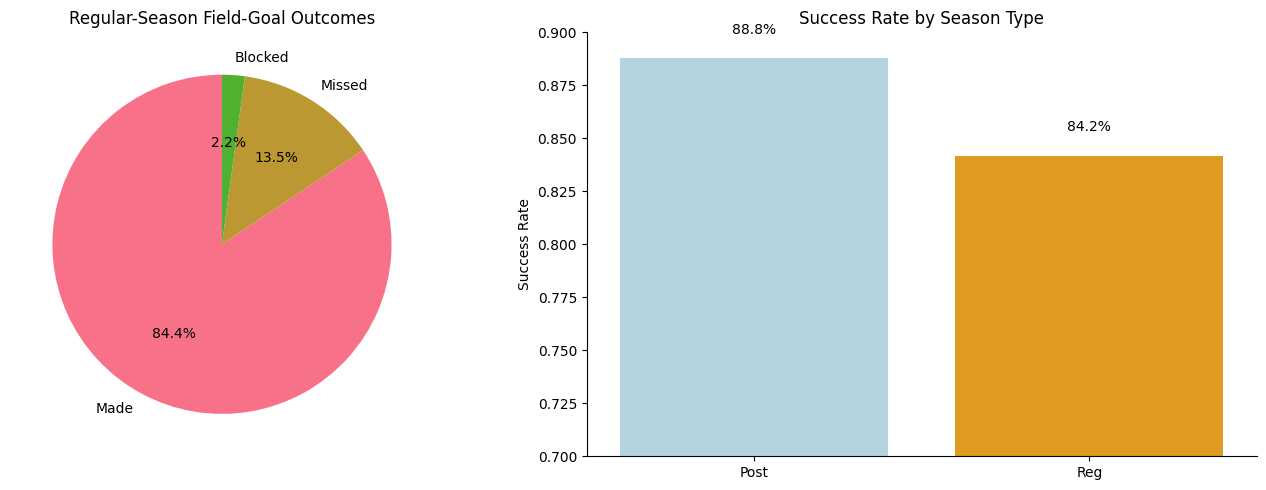

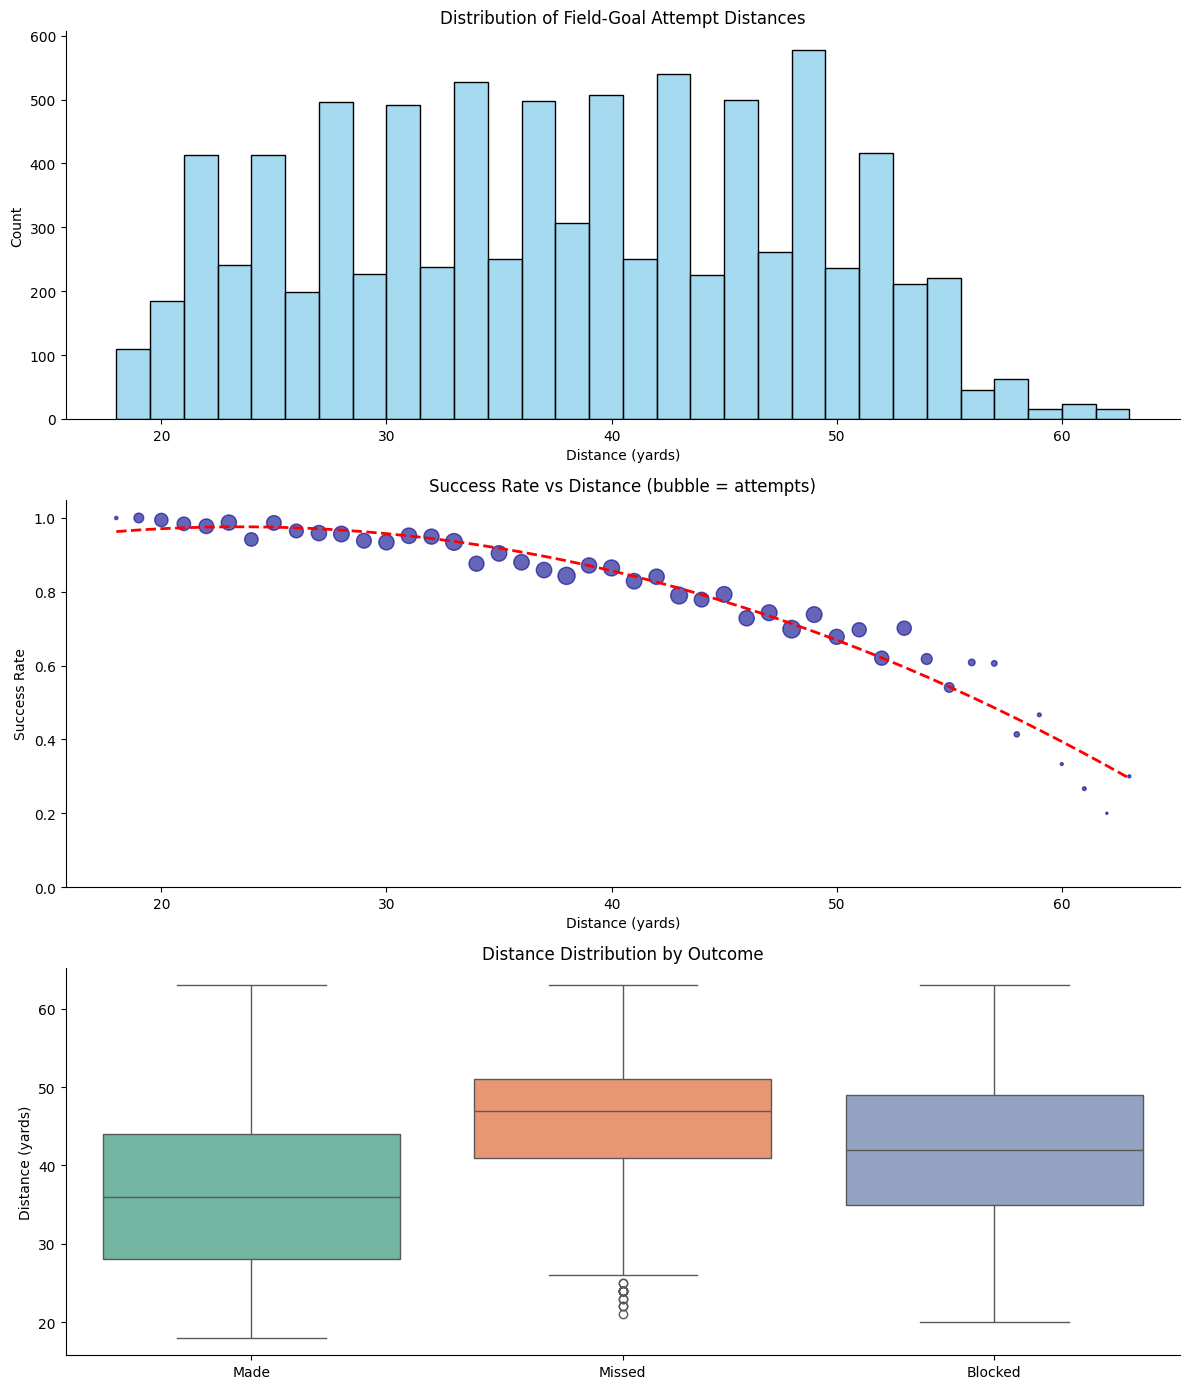

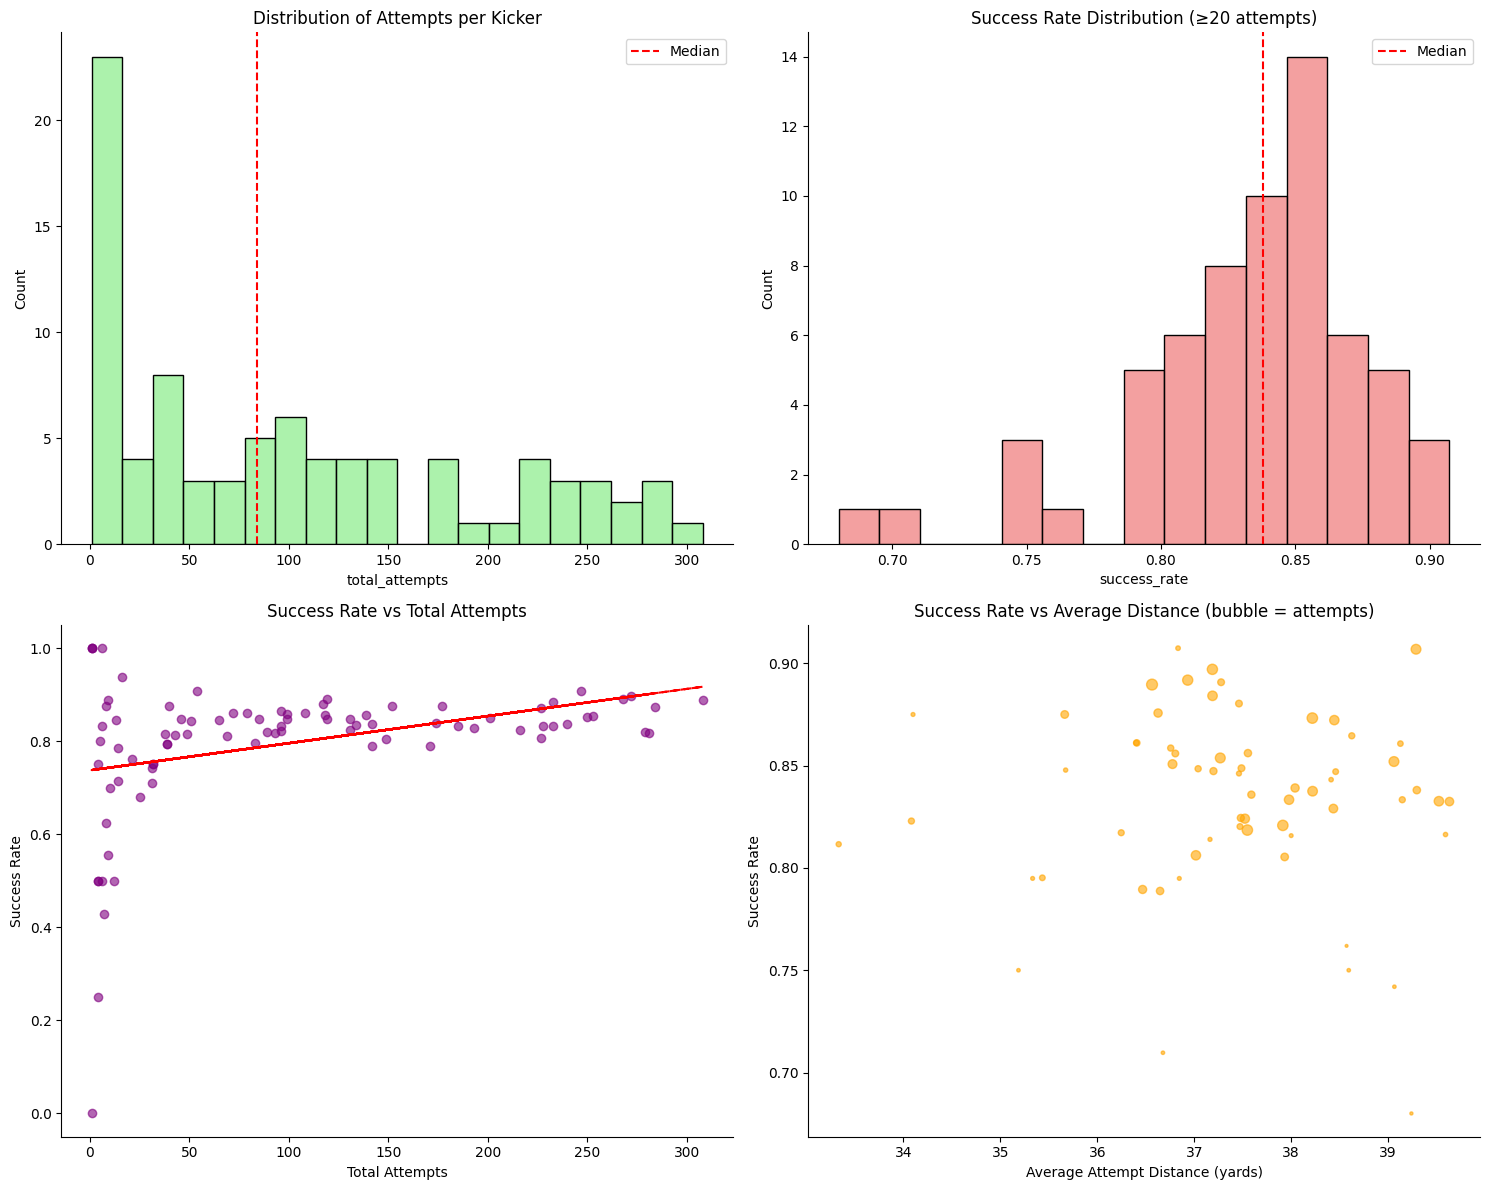

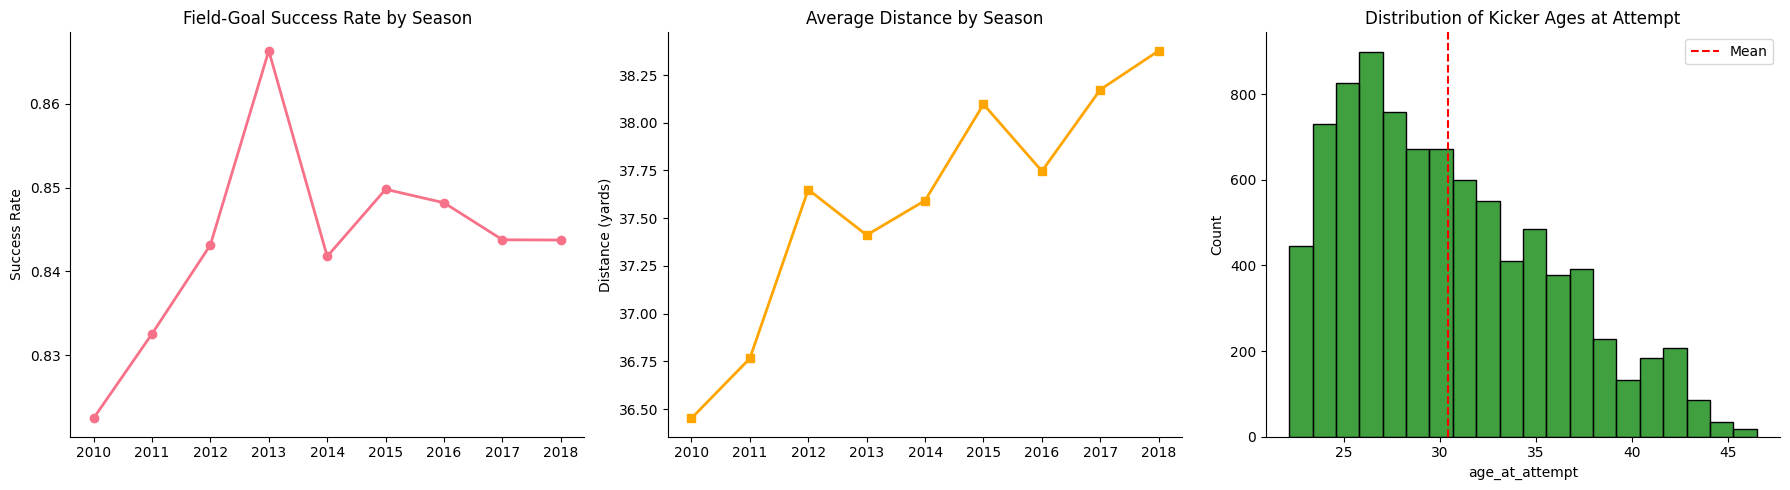

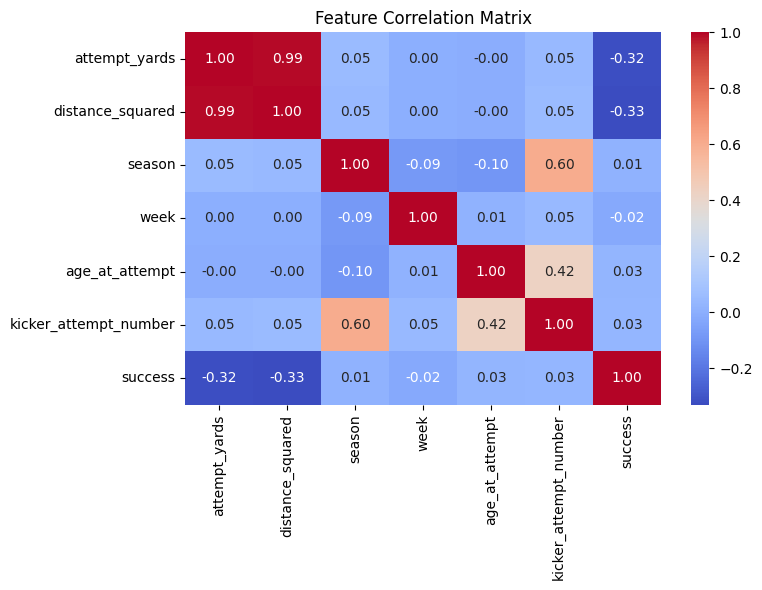

In [ ]:
# %%writefile src/nfl_kicker_analysis/eda.py
"""
NFL Kicker Field‑Goal EDA Utilities 

"""
from __future__ import annotations

import logging
from pathlib import Path
from typing import Sequence, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

# ───────────────────── configuration ────────────────────────────
logger = logging.getLogger(__name__)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s │ %(levelname)s │ %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)

plt.rcParams.update({
    "figure.figsize": (12, 7),
    "axes.spines.top": False,
    "axes.spines.right": False,
})
sns.set_palette("husl")

_FIELD_GOAL_RESULT_SUCCESS = "Made"
_PRESEASON_FLAG = "Pre"

# ──────────────────────── core helpers ──────────────────────────

def load_and_merge(
    kickers_path: Path | str,
    attempts_path: Path | str,
) -> pd.DataFrame:
    """
    Load raw CSVs and merge on player_id.

    - Parses 'birthdate' in kickers.csv.
    - Parses 'game_date' in field_goal_attempts.csv.

    Returns
    -------
    pd.DataFrame
        Combined DataFrame with parsed dates.
    """
    # 1. Inspect columns for debugging
    logger.info("Inspecting kickers file columns: %s", pd.read_csv(kickers_path, nrows=0).columns.tolist())
    logger.info("Inspecting attempts file columns: %s", pd.read_csv(attempts_path, nrows=0).columns.tolist())

    # 2. Read with correct parse_dates per file
    logger.info("Reading kickers.csv with parse_dates=['birthdate']")
    kickers = pd.read_csv(kickers_path, parse_dates=["birthdate"])

    logger.info("Reading field_goal_attempts.csv with parse_dates=['game_date']")
    attempts = pd.read_csv(attempts_path, parse_dates=["game_date"])

    # 3. Merge
    df = attempts.merge(kickers, on="player_id", how="left", validate="many_to_one")

    missing = df["player_name"].isna().sum()
    if missing:
        logger.warning("%d attempts missing kicker metadata", missing)
    logger.info("Merged shape: %s rows × %s cols", *df.shape)

    print(f"Merged dataset shape: {df.shape}")
    print(f"Total field goal attempts: {len(df):,}")
    missing = df["player_name"].isna().sum()
    print(f"Attempts with missing kicker info: {missing}")
    print("\nFirst 5 rows of merged dataset:")
    print(df.head(5))
    return df


def basic_overview(df: pd.DataFrame) -> None:
    print("\n─ BASIC OVERVIEW ─")
    print("Data types:")
    print(df.dtypes)
    print("\nFull info:")
    print(df.info())
    dupes = df.duplicated().sum()
    print(f"\nDuplicate rows: {dupes}")
    print(f"\nUnique seasons: {sorted(df['season'].unique())}")
    print(f"Season types: {df['season_type'].unique()}")
    print(f"Field goal results: {df['field_goal_result'].unique()}")
    print(f"Unique kickers: {df['player_name'].nunique()}")
    # date range/span
    if "game_date" in df.columns:
        rng = df["game_date"]
        if not np.issubdtype(rng.dtype, np.datetime64):
            rng = pd.to_datetime(rng)
        print(f"\nDate range: {rng.min()} to {rng.max()}")
        print(f"Span: {rng.max() - rng.min()}")


def basic_overview(df: pd.DataFrame) -> None:
    """Print high‑level schema info mirroring the notebook's *Section 2*."""
    print("\n─ BASIC OVERVIEW ─")
    print(df.dtypes)
    print("\nUnique kickers:", df["player_name"].nunique())
    print("Seasons:", sorted(df["season"].unique()))
    dupe = df.duplicated().sum()
    if dupe:
        logger.warning("%d duplicate rows detected", dupe)


def prepare_dataset(
    df: pd.DataFrame,
    *,
    include_preseason: bool = False,
    max_distance: int | None = 63,
    add_age_feature: bool = True,
) -> pd.DataFrame:
    """Clean/filter & engineer variables exactly as the notebook does."""
    df = df.copy()

    # Filter out preseason unless explicitly requested
    if not include_preseason:
        df = df[df["season_type"] != _PRESEASON_FLAG]

    # Binary target
    df["success"] = (df["field_goal_result"] == _FIELD_GOAL_RESULT_SUCCESS).astype(int)

    # Remove extreme distances
    if max_distance is not None:
        df = df[df["attempt_yards"] <= max_distance]

    # Feature engineering
    df["distance_squared"] = df["attempt_yards"].pow(2)
    df["is_long_attempt"] = (df["attempt_yards"] >= 50).astype(int)

    # Sort for cumulative counts
    df = df.sort_values(["player_id", "game_date"])
    df["kicker_attempt_number"] = df.groupby("player_id").cumcount() + 1

    # Age at attempt
    if add_age_feature and {"birthdate", "game_date"}.issubset(df.columns):
        df["age_at_attempt"] = (
            (df["game_date"] - df["birthdate"]).dt.days / 365.25
        ).round(2)

    logger.info("Prepared tidy dataset → %s rows", len(df))
    return df.reset_index(drop=True)


# ─────────────────────── analytical helpers ────────────────────
def outcome_summary(
    df: pd.DataFrame,
    savefig: Path | None = None,
) -> Tuple[pd.Series, plt.Figure]:
    """Outcome counts + pie/bar figure (adds binary-distribution prints)."""
    counts = df["field_goal_result"].value_counts()
    success_rate = (df["success"]).mean()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    counts.plot.pie(ax=ax1, autopct="%1.1f%%", startangle=90)
    ax1.set_ylabel("")
    ax1.set_title("Regular-Season Field-Goal Outcomes")

    season_success = df.groupby("season_type")["success"].mean()
    sns.barplot(
        x=season_success.index,
        y=season_success.values,
        palette=["lightblue", "orange"],
        ax=ax2,
    )
    ax2.set_title("Success Rate by Season Type")
    ax2.set_ylabel("Success Rate")
    ax2.set_xlabel("")
    ax2.set_ylim(0.7, 0.9)
    for i, v in enumerate(season_success.values):
        ax2.text(i, v + 0.01, f"{v:.1%}", ha="center", va="bottom")

    plt.tight_layout()
    if savefig:
        fig.savefig(savefig, dpi=150, bbox_inches="tight")

    # 🆕 notebook-style console echoes
    print(f"\nBinary target distribution — Success (Made): {df['success'].sum():,}"
          f" ({success_rate:.1%}) | Failure: {(1-success_rate):.1%}")

    return counts, fig


def distance_analysis(
    df: pd.DataFrame,
    *,
    min_attempts: int = 3,
    savefig: Path | None = None,
) -> Tuple[pd.DataFrame, plt.Figure]:
    """Histogram + scatter + box-plot + printed distance buckets."""
    summary = (
        df.groupby("attempt_yards")["success"]
        .agg(success_rate="mean", attempts="size")
        .query("attempts >= @min_attempts")
        .reset_index()
    )

    # Define distance buckets exactly as the notebook
    buckets = [
        (18, 29, "Short (18-29)"),
        (30, 39, "Medium-Short (30-39)"),
        (40, 49, "Medium (40-49)"),
        (50, 59, "Long (50-59)"),
        (60, 75, "Extreme (60+)"),
    ]

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 14))

    # A) Histogram
    sns.histplot(df["attempt_yards"], bins=30, edgecolor="black",
                 color="skyblue", ax=ax1)
    ax1.set_title("Distribution of Field-Goal Attempt Distances")
    ax1.set_xlabel("Distance (yards)")

    # B) Scatter + quadratic trend
    sizes = summary["attempts"] / 2
    ax2.scatter(summary["attempt_yards"], summary["success_rate"],
                s=sizes, alpha=0.6, color="darkblue")
    z = np.polyfit(summary["attempt_yards"], summary["success_rate"], 2)
    ax2.plot(
        np.unique(summary["attempt_yards"]),
        np.poly1d(z)(np.unique(summary["attempt_yards"])),
        "r--", linewidth=2,
    )
    ax2.set_title("Success Rate vs Distance (bubble = attempts)")
    ax2.set_xlabel("Distance (yards)")
    ax2.set_ylabel("Success Rate")
    ax2.set_ylim(0, 1.05)

    # C) Box-plot by outcome
    sns.boxplot(
        x="field_goal_result",
        y="attempt_yards",
        data=df,
        ax=ax3,
        palette="Set2",
    )
    ax3.set_title("Distance Distribution by Outcome")
    ax3.set_xlabel("")
    ax3.set_ylabel("Distance (yards)")

    plt.tight_layout()
    if savefig:
        fig.savefig(savefig, dpi=150, bbox_inches="tight")

    # 🆕 Print bucketed success rates
    print("\nSuccess rates by distance range:")
    for lo, hi, label in buckets:
        mask = (df["attempt_yards"] >= lo) & (df["attempt_yards"] <= hi)
        if mask.any():
            rate = df.loc[mask, "success"].mean()
            print(f"{label}: {rate:.1%} ({mask.sum():,} attempts)")

    return summary, fig


def temporal_analysis(
    df: pd.DataFrame,
    *,
    savefig: Path | None = None,
) -> Tuple[pd.DataFrame, plt.Figure]:
    """Season trend, week quartiles, age histogram, age-group prints."""
    season_df = (
        df.groupby("season")
        .agg(success_rate=("success", "mean"),
             total_attempts=("success", "size"),
             avg_distance=("attempt_yards", "mean"))
        .reset_index()
    )

    # Ensure age feature exists
    if "age_at_attempt" not in df.columns:
        if {"birthdate", "game_date"}.issubset(df.columns):
            df = df.copy()
            df["age_at_attempt"] = (df["game_date"] - df["birthdate"]).dt.days / 365.25

    # 🆕 week-level success print
    week_trends = df.groupby("week")["success"].mean()
    print("\nSuccess rate by season-quarter weeks:")
    quarters = {
        "Weeks 1-4": week_trends.loc[1:4].mean(),
        "Weeks 5-8": week_trends.loc[5:8].mean(),
        "Weeks 9-12": week_trends.loc[9:12].mean(),
        "Weeks 13-16": week_trends.loc[13:16].mean(),
    }
    for k, v in quarters.items():
        print(f"{k}: {v:.1%}")

    # 🆕 age-group print
    age_bins = [(0, 25), (25, 30), (30, 35), (35, 45)]
    print("\nSuccess rate by age group:")
    for lo, hi in age_bins:
        grp = df[(df["age_at_attempt"] >= lo) & (df["age_at_attempt"] < hi)]
        if grp.empty:
            continue
        print(f"{lo:>2}-{hi:<2}: {grp['success'].mean():.1%} "
              f"({len(grp):,} attempts, avg {grp['attempt_yards'].mean():.1f} yds)")

    # -------- figures (unchanged layout) --------
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    ax1.plot(season_df["season"], season_df["success_rate"],
             marker="o", linewidth=2)
    ax1.set_title("Field-Goal Success Rate by Season")
    ax1.set_ylabel("Success Rate")

    ax2.plot(season_df["season"], season_df["avg_distance"],
             marker="s", color="orange", linewidth=2)
    ax2.set_title("Average Distance by Season")
    ax2.set_ylabel("Distance (yards)")

    sns.histplot(df["age_at_attempt"].dropna(), bins=20, edgecolor="black",
                 color="green", ax=ax3)
    ax3.axvline(df["age_at_attempt"].mean(), color="red", linestyle="--", label="Mean")
    ax3.set_title("Distribution of Kicker Ages at Attempt")
    ax3.legend()

    plt.tight_layout()
    if savefig:
        fig.savefig(savefig, dpi=150, bbox_inches="tight")

    return season_df, fig



def kicker_performance_analysis(
    df: pd.DataFrame,
    *,
    min_attempts: int = 20,
    savefig: Path | None = None,
) -> Tuple[pd.DataFrame, plt.Figure]:
    """Per‑kicker stats + four‑plot dashboard (Section 5 visuals)."""
    stats_df = (
        df.groupby(["player_name", "player_id"])
        .agg(
            total_attempts=("success", "size"),
            made=("success", "sum"),
            success_rate=("success", "mean"),
            avg_distance=("attempt_yards", "mean"),
            min_distance=("attempt_yards", "min"),
            max_distance=("attempt_yards", "max"),
        )
        .reset_index()
    )

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    sns.histplot(stats_df["total_attempts"], bins=20, edgecolor="black", ax=axes[0, 0], color="lightgreen")
    axes[0, 0].axvline(stats_df["total_attempts"].median(), color="red", linestyle="--", label="Median")
    axes[0, 0].set_title("Distribution of Attempts per Kicker")
    axes[0, 0].legend()

    experienced = stats_df.query("total_attempts >= @min_attempts")
    sns.histplot(experienced["success_rate"], bins=15, edgecolor="black", ax=axes[0, 1], color="lightcoral")
    axes[0, 1].axvline(experienced["success_rate"].median(), color="red", linestyle="--", label="Median")
    axes[0, 1].set_title(f"Success Rate Distribution (≥{min_attempts} attempts)")
    axes[0, 1].legend()

    axes[1, 0].scatter(stats_df["total_attempts"], stats_df["success_rate"], alpha=0.6, color="purple")
    z = np.polyfit(stats_df["total_attempts"], stats_df["success_rate"], 1)
    axes[1, 0].plot(stats_df["total_attempts"], np.poly1d(z)(stats_df["total_attempts"]), "r--")
    axes[1, 0].set_title("Success Rate vs Total Attempts")
    axes[1, 0].set_xlabel("Total Attempts")
    axes[1, 0].set_ylabel("Success Rate")

    bubble = experienced["total_attempts"] / 5
    axes[1, 1].scatter(experienced["avg_distance"], experienced["success_rate"], s=bubble, alpha=0.6, color="orange")
    axes[1, 1].set_title("Success Rate vs Average Distance (bubble = attempts)")
    axes[1, 1].set_xlabel("Average Attempt Distance (yards)")
    axes[1, 1].set_ylabel("Success Rate")

    plt.tight_layout()
    if savefig:
        fig.savefig(savefig, dpi=150, bbox_inches="tight")
    return stats_df, fig




def feature_engineering(df: pd.DataFrame, savefig: Path | None = None) -> plt.Figure:
    """Correlation heatmap of engineered numeric variables (Section 7 visuals)."""
    numeric_cols = [
        "attempt_yards",
        "distance_squared",
        "season",
        "week",
        "age_at_attempt",
        "kicker_attempt_number",
        "success",
    ]
    corr = df[numeric_cols].corr()

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", ax=ax)
    ax.set_title("Feature Correlation Matrix")

    plt.tight_layout()
    if savefig:
        fig.savefig(savefig, dpi=150, bbox_inches="tight")
    return fig

# ───────────────────────── sanity guards ─────────────────────────
# ───────────────────────── utils ──────────────────────────
def _loess_smooth(x: np.ndarray, y: np.ndarray, frac: float = 0.25) -> np.ndarray:
    """
    Lightweight LOESS smoother used only for sanity checking.
    Falls back to a centred 3-point rolling mean if statsmodels isn’t present.
    """
    try:
        from statsmodels.nonparametric.smoothers_lowess import lowess
        return lowess(y, x, frac=frac, return_sorted=False)
    except ImportError:
        return pd.Series(y).rolling(3, center=True, min_periods=1).mean().values


# ─────────────────────── sanity guards ────────────────────
def quick_sanity_checks(
    df: pd.DataFrame,
    *,
    tol: float = 0.04,
    min_count: int = 5,
    check_monotonic: bool = False,
    verbose: bool = False,
) -> None:
    """
    Fast data-quality assertions.

    Parameters
    ----------
    tol : float
        Max allowed jump in success rate between **smoothed** adjacent yardages.
    min_count : int
        Minimum attempt count to include a yardage in the check.
    check_monotonic : bool
        If True, raise on monotonicity violations; otherwise only log warnings.
    verbose : bool
        Print full list of violations.
    """
    # 1. Duplicates
    if df.duplicated().any():
        raise AssertionError("Duplicate rows detected")

    # 2. Missing kicker names
    n_missing = df["player_name"].isna().sum()
    if n_missing:
        raise AssertionError(f"Missing player_name in {n_missing} rows")

    # 3. Distance-success monotonicity  (optional)
    grp = df.groupby("attempt_yards")
    counts = grp.size()
    rates  = grp["success"].mean()
    rates  = rates[counts >= min_count].sort_index()
    if rates.empty:
        logger.warning("Monotonicity check skipped – no yardage meets min_count=%d", min_count)
        return

    smooth = _loess_smooth(rates.index.values, rates.values)
    deltas = np.diff(smooth)
    bad_idx = np.where(np.abs(deltas) > tol)[0]  
    if bad_idx.size:
        yards = rates.index.values[1:][bad_idx]
        if verbose or (check_monotonic and bad_idx.size < 20):
            for y, d in zip(yards, deltas[bad_idx]):
                logger.warning("Δ success@%dy = %+0.3f  (n=%d)", y, d, counts[y])
        msg = f"Distance-success curve violations at {len(yards)} yardages; tol={tol:.2%}"
        if check_monotonic:
            raise AssertionError(msg)
        else:
            logger.warning(msg + "  – continuing because check_monotonic=False")
    else:
        logger.info("Success-distance curve looks monotonic within ±%.1f %%", tol*100)


def player_activity_checks(
    df: pd.DataFrame,
    kickers_csv: Path | str,
) -> None:
    """
    Additional checks:
      - Metadata kickers with zero attempts
      - Player-seasons with attempts but zero makes
      - Players with <2 seasons
      - Players by years since last appearance
    """
    kickers = pd.read_csv(kickers_csv, usecols=['player_id','player_name'])
    all_ids = set(kickers['player_id'])
    df_ids = set(df['player_id'].unique())
    zero_attempts = sorted(all_ids - df_ids)
    print(f"\nKickers with zero attempts: {len(zero_attempts)}")
    if zero_attempts:
        names = kickers[kickers['player_id'].isin(zero_attempts)]['player_name'].tolist()
        print(names)
    ps = df.groupby(['player_id','player_name','season']).agg(
        attempts=('success','size'), makes=('success','sum')
    ).reset_index()
    zero_makes = ps[(ps.attempts>0)&(ps.makes==0)]
    print(f"\nPlayer-seasons with zero makes: {len(zero_makes)}")
    print(zero_makes[['player_name','season','attempts']].to_string(index=False))
    season_counts = df.groupby(['player_id','player_name'])['season'].nunique().reset_index(name='season_count')
    lt2 = season_counts[season_counts.season_count<2]
    print(f"\nPlayers with <2 seasons: {len(lt2)}")
    print(lt2[['player_name','season_count']].to_string(index=False))
    current_season = int(df['season'].max())
    last = df.groupby(['player_id','player_name'])['season'].max().reset_index(name='last_season')
    last['gap'] = current_season - last['last_season']
    last['gap_group'] = last['gap'].apply(lambda g: str(g) if g<4 else '4+')
    gap_counts = last['gap_group'].value_counts().sort_index(key=lambda x: [int(v.rstrip('+')) for v in x])
    print("\nPlayers by years since last appearance:")
    for grp,cnt in gap_counts.items():
        print(f"{grp} years: {cnt}")


# ───────────────────── orchestrator API ─────────────────────
def run_full_eda(
    kickers_csv: Path | str,
    attempts_csv: Path | str,
    *,
    output_dir: Path | str = "figures",
    include_preseason: bool = False,
    max_distance: int | None = 63,
    check_monotonic: bool = False,
) -> pd.DataFrame:
    """Single convenience entry – replicates the entire notebook flow."""
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    # 1) Load & merge raw data
    print("── Section 1 Load & Merge ──")
    df_raw = load_and_merge(kickers_csv, attempts_csv)

    # 2) Data‐quality & basic info
    print("── Section 2 Data Quality & Basic Info ──")
    basic_overview(df_raw)

    # 3) Prepare & engineer the dataset (adds 'success', drops Pre, filters distance, etc.)
    print("── Section 3 Prepare Dataset ──")
    df = prepare_dataset(
        df_raw,
        include_preseason=include_preseason,
        max_distance=max_distance,
    )

    print("── Section 3.1 Player Activity Checks ──")
    player_activity_checks(df, kickers_csv)
    
    # 4) Outcome analysis (now that df has 'success')
    print("── Section 4 Outcome Analysis ──")
    outcome_summary(df, output_dir / "outcomes.png")

    # 5) Distance‐success analysis
    print("── Section 5 Distance Analysis ──")
    distance_analysis(df, savefig=output_dir / "distance.png")

    # 6) Kicker performance dashboard
    print("── Section 6 Kicker Performance ──")
    kicker_performance_analysis(df, savefig=output_dir / "kicker_dashboard.png")

    # 7) Temporal factors
    print("── Section 7 Temporal Factors ──")
    temporal_analysis(df, savefig=output_dir / "temporal.png")

    # 8) Feature correlation
    print("── Section 8 Feature Engineering ──")
    feature_engineering(df, savefig=output_dir / "correlation.png")

    # 9) Final sanity checks
    print("── Section 9 Sanity Checks ──")
    quick_sanity_checks(df, check_monotonic=check_monotonic)

    logger.info("All figures saved in %s", output_dir.resolve())
    return df



# ─────────────────────────── CLI demo ───────────────────────────

if __name__ == "__main__":
    # Paths configurable via env or CLI args as needed
    KICKERS = Path("data/raw/kickers.csv")
    ATTEMPTS = Path("data/raw/field_goal_attempts.csv")

    # End‑to‑end run replicating the notebook defaults
    df_model = run_full_eda(KICKERS, ATTEMPTS)

    out = Path("data/processed/field_goal_modeling_data.csv")
    out.parent.mkdir(parents=True, exist_ok=True)
    df_model.to_csv(out, index=False)
    logger.info("Processed dataset saved → %s (%s rows)", out, len(df_model))


    print("="*80)
    print("COMPREHENSIVE EDA SUMMARY AND MODELING RECOMMENDATIONS")
    print("="*80)

    print(f"""
     PROBLEM DEFINITION
    • Binary classification problem: Predict field goal success (Made vs Missed/Blocked)
    • Target distribution: {df_model['success'].mean():.1%} success rate (manageable imbalance)
    • Dataset: {len(df_model):,} regular season field goal attempts (2010-2018)

     KEY FINDINGS

    1. DISTANCE IS THE DOMINANT FACTOR
    • Strong negative correlation with success (-0.685)
    • Non-linear relationship: ~99% success at 18-20 yards → ~0% at 60+ yards
    • Success drops sharply after 50 yards (long range threshold)

    2. KICKER DIFFERENCES ARE SIGNIFICANT
    • {df_model['player_name'].nunique()} unique kickers with vastly different performance levels
    • Raw success rates range from ~60% to ~95% among experienced kickers
    • Sample sizes vary dramatically: 1 to 300+ attempts per kicker
    • Clear evidence for kicker-specific modeling

    3. TEMPORAL PATTERNS ARE MINIMAL
    • Success rates stable across seasons (83-86%)
    • No major trends in attempt difficulty over time
    • Week and age effects are minor compared to distance and kicker skill

    4. DATA QUALITY IS EXCELLENT
    • No missing values in key variables
    • Clean, well-structured data ready for modeling
    • Minimal outliers (removed extreme distances >63 yards)

     RECOMMENDED MODELING APPROACH

    PRIMARY MODEL: Hierarchical Bayesian Logistic Regression
    ✓ Handles varying sample sizes per kicker elegantly
    ✓ Provides uncertainty quantification for ratings
    ✓ Natural pooling of information across kickers
    ✓ Logistic function matches distance-success relationship

    MODEL SPECIFICATION:
    success_ij ~ Bernoulli(p_ij)
    logit(p_ij) = α_j + β * distance_ij
    α_j ~ Normal(μ_α, σ_α)  [kicker random effects]

    ALTERNATIVE MODELS for comparison:
    • Regularized logistic regression (Ridge/Lasso)
    • Random Forest (for non-linear interactions)
    • XGBoost (gradient boosting)

     FEATURE ENGINEERING RECOMMENDATIONS

    ESSENTIAL FEATURES:
    • attempt_yards (primary predictor)
    • player_name/player_id (kicker identity)

    POTENTIAL ENHANCEMENTS:
    • distance_squared (for non-linearity)
    • is_long_attempt (50+ yard flag)
    • kicker_attempt_number (experience effect)
    • season trends (if needed)

    EVALUATION STRATEGY

    METRICS:
    • Brier Score (calibration of probabilities)
    • Log Loss (proper scoring rule)
    • AUC-ROC (discrimination ability)
    • Custom: Expected Points Added per attempt

    VALIDATION:
    • Time-based split (train: 2010-2017, test: 2018)
    • Cross-validation with kicker groups
    • Out-of-sample kicker prediction (new kickers)

     EXPECTED OUTCOMES

    The model will enable:
    • Accurate field goal success probability prediction
    • Fair kicker evaluation accounting for attempt difficulty
    • Expected points calculation for strategic decisions
    • Identification of clutch vs. situational performance

    """)



## 1. Configuration Module

Central configuration for the entire package.


In [5]:
%%writefile src/nfl_kicker_analysis/data/feature_schema.py
"""
FeatureSchema – canonical column lists for preprocessing & modelling.
"""
from dataclasses import dataclass, field
from typing import List


@dataclass
class FeatureSchema:
    """Container class listing every column by semantic type."""
    numerical: List[str] = field(default_factory=list)
    binary:    List[str] = field(default_factory=list)      # 0/1 ints
    ordinal:   List[str] = field(default_factory=list)      # ordered integers
    nominal:   List[str] = field(default_factory=list)      # unordered cats / high-card
    target:    str        = "success"

    # ───── convenience helpers ────────────────────────────────────
    @property
    def model_features(self) -> List[str]:
        """All predictors in modelling order."""
        return self.numerical + self.binary + self.ordinal + self.nominal

    def assert_in_dataframe(self, df) -> None:
        """Raise if any declared column is missing from df.columns."""
        missing = [c for c in self.model_features + [self.target]
                   if c not in df.columns]
        if missing:
            raise ValueError(f"FeatureSchema mismatch – missing cols: {missing}")


if __name__ == "__main__":
    # Test the feature schema
    schema = FeatureSchema()
    # sample features
    FeatureSchema.numerical = ['distance', 'weather_condition', 'time_of_day']
    FeatureSchema.binary = ['is_home', 'is_playoff']
    FeatureSchema.ordinal = ['weather_temperature']
    FeatureSchema.nominal = ['weather_type', 'team_name']
    FeatureSchema.target = 'success'
    
    print(schema.model_features)
    print(schema.assert_in_dataframe(pd.DataFrame()))
    print("******* FeatureSchema tests passed!")

Overwriting src/nfl_kicker_analysis/data/feature_schema.py


In [6]:
%%writefile src/nfl_kicker_analysis/__init__.py
# This file is empty

Overwriting src/nfl_kicker_analysis/__init__.py


In [7]:
%%writefile src/nfl_kicker_analysis/config.py
"""
Configuration module for NFL Kicker Analysis package.
Contains all constants, paths, and configuration parameters.
"""
from pathlib import Path
from typing import Dict, List, Tuple
import os

class Config:
    """Main configuration class for the NFL Kicker Analysis package."""
    MLFLOW_EXPERIMENT_NAME="nfl_kicker_analysis"
    # Base paths
    PROJECT_ROOT = Path("/workspace")
    DATA_DIR = PROJECT_ROOT / "data"
    RAW_DATA_DIR = DATA_DIR / "raw"
    PROCESSED_DATA_DIR = DATA_DIR / "processed"
    OUTPUT_DIR = PROJECT_ROOT / "output"
    MODELS_DIR = PROJECT_ROOT / "models"  # Base models directory
    MODEL_DIR = MODELS_DIR / "bayesian"   # Specific directory for Bayesian models
    
    # Raw data files
    KICKERS_FILE = RAW_DATA_DIR / "kickers.csv"
    ATTEMPTS_FILE = RAW_DATA_DIR / "field_goal_attempts.csv"
    
    # Processed data files
    MODELING_DATA_FILE = PROCESSED_DATA_DIR / "field_goal_modeling_data.csv"
    LEADERBOARD_FILE = OUTPUT_DIR / "leaderboard.csv"
    MODEL_DATA_FILE: Path = OUTPUT_DIR / "bayesian_features.csv"
    
    # Analysis parameters
    MIN_DISTANCE = 20
    MAX_DISTANCE = 60
    MIN_KICKER_ATTEMPTS = 10  # Changed from 8 to 5 to match Method B
    
    # Distance profile for EPA calculation
    DISTANCE_PROFILE = [20, 25, 30, 35, 40, 45, 50, 55, 60]
    DISTANCE_WEIGHTS = [0.05, 0.10, 0.20, 0.20, 0.20, 0.15, 0.08, 0.02, 0.01]
    
    # Distance ranges for analysis
    DISTANCE_RANGES = [
        (18, 29, "Short (18-29 yards)"),
        (30, 39, "Medium-Short (30-39 yards)"),
        (40, 49, "Medium (40-49 yards)"),
        (50, 59, "Long (50-59 yards)"),
        (60, 75, "Extreme (60+ yards)")
    ]
    
    # Model parameters
    BAYESIAN_MCMC_SAMPLES = 2_000
    BAYESIAN_TUNE = 1_000
    BAYESIAN_CHAINS = 2
    
    # Rating thresholds
    ELITE_THRESHOLD = 0.15
    STRUGGLING_THRESHOLD = -0.20
    
    # Visualization settings
    FIGURE_SIZE = (12, 8)
    DPI = 100
    
    # Season types to include
    SEASON_TYPES = ['Reg', 'Post']  # Include both regular season and playoffs
    
    # ─── Feature flags ───────────────────────────────────────────
    FILTER_RETIRED_INJURED = True   # keep everyone by default
    metrics = {"accuracy": 0.85, "f1": 0.82}
    
    # 16 game seasons
    PRE_2021_SEASON_GAMES = 16
    POST_2021_SEASON_GAMES = 17
    YEAR_GAMES_INCREASED = 2021
    
    # ── NEW: maximum gap (in games) since last kick for Bayesian defaults
    MAX_GAMES_SINCE_LAST_KICK: int | None = None

    # How many Optuna trials for each tree-based model
    OPTUNA_TRIALS: Dict[str, int] = {
        "simple_logistic": 50,
        "ridge_logistic": 50,
        "random_forest": 50,
        "xgboost": 50,
        "catboost": 50
    }

    @classmethod
    def ensure_directories(cls):
        """Create all required directories if they don't exist."""
        for dir_path in [cls.RAW_DATA_DIR, cls.PROCESSED_DATA_DIR, 
                        cls.OUTPUT_DIR, cls.MODELS_DIR]:
            dir_path.mkdir(parents=True, exist_ok=True)

# Create global config instance
config = Config()

# ───────────────────────── Feature catalogue ─────────────────────────
# Single source of truth for column roles – centralized from all modules
FEATURE_LISTS: Dict[str, List[str]] = {
    "numerical": [
        "attempt_yards", "age_at_attempt", "distance_squared",
        "career_length_years", "season_progress", "exp_100", 
        "distance_zscore", "distance_percentile",
        "seasons_of_experience", "career_year",
        "age_c", "age_c2", 
        "importance", "days_since_last_kick",
        "age_dist_interact", "exp_dist_interact", 
    ],
    "ordinal": ["season", "week", "month", "day_of_year"],
    "nominal": [
        "kicker_id", "kicker_idx",
        "is_long_attempt", "is_very_long_attempt",
        "is_rookie_attempt", "distance_category", "experience_category",
        "is_early_season", "is_late_season", "is_playoffs",
    ],
    "y_variable": ["success"],
}

# Attach FEATURE_LISTS onto the config instance for ease of use
config.FEATURE_LISTS = FEATURE_LISTS

if __name__ == "__main__":
    # Test the configuration
    print("NFL Kicker Analysis Configuration")
    print("=" * 40)
    print(f"Data directory: {config.DATA_DIR}")
    print(f"Min distance: {config.MIN_DISTANCE}")
    print(f"Max distance: {config.MAX_DISTANCE}")
    print(f"Distance profile: {config.DISTANCE_PROFILE}")
    print(f"Elite threshold: {config.ELITE_THRESHOLD}")
    
    # Test directory creation
    config.ensure_directories()
    print("******* Configuration loaded and directories created!")





Overwriting src/nfl_kicker_analysis/config.py


In [8]:
%%writefile src/nfl_kicker_analysis/data/loader.py
"""
Data loading module for NFL kicker analysis.
Handles loading and merging of raw datasets.
"""
import pandas as pd
from pathlib import Path
from typing import Optional, Tuple
import warnings
from pandas.tseries.offsets import DateOffset

from src.nfl_kicker_analysis.config import config

class DataLoader:
    """Handles loading and initial merging of kicker datasets."""
    
    def __init__(self):
        """Initialize the data loader."""
        self.kickers_df = None
        self.attempts_df = None
        self.merged_df = None
    
    def load_kickers(self, filepath: Optional[Path] = None) -> pd.DataFrame:
        """
        Load kicker metadata.
        
        Args:
            filepath: Optional path to kickers CSV file
            
        Returns:
            DataFrame with kicker information
        """
        if filepath is None:
            filepath = config.KICKERS_FILE
            
        try:
            self.kickers_df = pd.read_csv(filepath)
            print(f"******* Loaded {len(self.kickers_df)} kickers from {filepath}")
            return self.kickers_df
        except FileNotFoundError:
            raise FileNotFoundError(f"Kickers data file not found: {filepath}")
    
    def load_attempts(self, filepath: Optional[Path] = None) -> pd.DataFrame:
        """
        Load field goal attempts data.
        
        Args:
            filepath: Optional path to attempts CSV file
            
        Returns:
            DataFrame with field goal attempt information
        """
        if filepath is None:
            filepath = config.ATTEMPTS_FILE
            
        try:
            self.attempts_df = pd.read_csv(filepath)
            print(f"******* Loaded {len(self.attempts_df)} field goal attempts from {filepath}")
            return self.attempts_df
        except FileNotFoundError:
            raise FileNotFoundError(f"Attempts data file not found: {filepath}")
    
    def merge_datasets(self) -> pd.DataFrame:
        """
        Merge kickers and attempts datasets and drop preseason games.
        
        Returns:
            Merged DataFrame with kicker names attached to attempts, excluding preseason
        """
        if self.kickers_df is None:
            self.load_kickers()
        if self.attempts_df is None:
            self.load_attempts()
            
        # Merge on player_id
        self.merged_df = pd.merge(
            self.attempts_df,
            self.kickers_df,
            on='player_id',
            how='left'
        )
        
        # ── 3️⃣ Binary success target & drop kickers with zero makes ever ──
        self.merged_df['success'] = (self.merged_df['field_goal_result'] == 'Made').astype(int)
        makes = self.merged_df.groupby('player_id')['success'].sum()
        zero_ids = makes[makes == 0].index
        if len(zero_ids):
            print(f"🗑️  Removing {len(zero_ids)} kickers with zero makes ever")
            self.merged_df = self.merged_df.loc[~self.merged_df['player_id'].isin(zero_ids)].copy()
            
        # Drop preseason attempts if present
        if 'season_type' in self.merged_df.columns:
            preseason_mask = self.merged_df['season_type'] == 'Pre'
            num_preseason = preseason_mask.sum()
            if num_preseason > 0:
                print(f"🗑️  Filtered out {num_preseason} preseason attempts")
            # keep everything that is not Pre-season
            self.merged_df = self.merged_df.loc[~preseason_mask].copy()

        # ── 4️⃣ Filter out players with no games in the last 2 years ─────────────────
        # ensure game_date is datetime
        self.merged_df['game_date'] = pd.to_datetime(self.merged_df['game_date'])
        max_date = self.merged_df['game_date'].max()
        cutoff = max_date - DateOffset(years=2)

        # players with any game in the last 2 years
        recent = set(self.merged_df.loc[self.merged_df['game_date'] >= cutoff, 'player_id'])
        # all players
        all_ids = set(self.merged_df['player_id'])
        # players with no recent games
        inactive = all_ids - recent

        # ── 5️⃣ For those inactive players, require ≥10 games outside their last 16 ─────────────────
        keep_ids = set(recent)
        for pid in inactive:
            # get this player's games sorted newest→oldest
            pg = (self.merged_df[self.merged_df['player_id'] == pid]
                  .sort_values('game_date', ascending=False))
            # drop their 16 most‐recent games
            older = pg.iloc[16:] if len(pg) > 16 else pg.iloc[0:0]
            if len(older) >= 10:
                keep_ids.add(pid)

        # apply the combined filter
        before = len(self.merged_df)
        self.merged_df = self.merged_df[self.merged_df['player_id'].isin(keep_ids)].copy()
        after = len(self.merged_df)
        print(f"🗂️  Filtered out {before - after} attempts due to recency/experience rules")
        

        # Validate merge
        missing_kickers = self.merged_df['player_name'].isnull().sum()
        if missing_kickers > 0:
            warnings.warn(f"Found {missing_kickers} attempts with missing kicker info")

        print(f"******* Merged dataset: {self.merged_df.shape[0]} attempts, {self.merged_df.shape[1]} columns")
        return self.merged_df

    
    def load_complete_dataset(self) -> pd.DataFrame:
        """
        Load and merge complete dataset in one call.
        
        Returns:
            Complete merged DataFrame
        """
        self.load_kickers()
        self.load_attempts()
        return self.merge_datasets()
    
    def get_data_summary(self) -> dict:
        """
        Get summary statistics of loaded data.
        
        Returns:
            Dictionary with data summary information
        """
        if self.merged_df is None:
            raise ValueError("No data loaded. Call load_complete_dataset() first.")
            
        summary = {
            'total_attempts': len(self.merged_df),
            'unique_kickers': self.merged_df['player_name'].nunique(),
            'unique_seasons': sorted(self.merged_df['season'].unique()),
            'season_types': self.merged_df['season_type'].unique().tolist(),
            'outcome_counts': self.merged_df['field_goal_result'].value_counts().to_dict(),
            'date_range': (
                self.merged_df['game_date'].min(),
                self.merged_df['game_date'].max()
            ),
            'distance_range': (
                self.merged_df['attempt_yards'].min(),
                self.merged_df['attempt_yards'].max()
            )
        }
        return summary

if __name__ == "__main__":
    # Test the data loader
    print("Testing DataLoader...")
    
    loader = DataLoader()
    
    try:
        # Load complete dataset
        df = loader.load_complete_dataset()
        print("---------------head-----------------")
        print(df.head())
        print("---------------columns-----------------")
        print(df.columns)
        
        # Print summary
        summary = loader.get_data_summary()
        print("\nData Summary:")
        print(summary)
        print(f"Total attempts: {summary['total_attempts']:,}")
        print(f"Unique kickers: {summary['unique_kickers']}")
        print(f"season_types: {summary['season_types']}")
        print(f"Seasons: {summary['unique_seasons']}")
        print(f"Outcomes: {summary['outcome_counts']}")
        
        print("******* DataLoader tests passed!")
        
    except Exception as e:
        print(f"------------- Error testing DataLoader: {e}")
        print("Note: This is expected if data files are not present.")





Overwriting src/nfl_kicker_analysis/data/loader.py


In [9]:
%%writefile src/nfl_kicker_analysis/data/feature_engineering.py
"""
Feature engineering module for NFL kicker analysis.
Contains all feature creation functions that can be used to build features for modeling.
"""
import pandas as pd
import numpy as np
from typing import Dict, Union, List
from pandas.tseries.offsets import DateOffset

# Required columns for EPA calculation
REQUIRED_EPA_COLS = {"age_at_attempt", "exp_100", "player_status"}

def ensure_epa_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Guarantee that df contains every column in REQUIRED_EPA_COLS.
    If any are missing, run the minimal FeatureEngineer step that
    creates just that column and merge the result back.
    Never fills with dummy values.
    """
    eng = FeatureEngineer()          # lightweight, stateless
    missing = REQUIRED_EPA_COLS.difference(df.columns)

    if "age_at_attempt" in missing:
        df = eng.create_date_features(df)
        missing -= {"age_at_attempt"}

    if {"exp_100"}.issubset(missing):           # experience needs ordering
        df = eng.create_experience_features(df)
        missing -= {"exp_100"}

    if "player_status" in missing:
        df = eng.create_player_status_features(df)
        missing -= {"player_status"}

    if missing:      # still not resolved ➜ stop early
        raise KeyError(f"Unable to generate columns: {sorted(missing)}")

    return df

class FeatureEngineer:
    """Handles all feature engineering operations."""

    def __init__(self):
        """Initialize the feature engineer."""
        self.kicker_mapping = None

    # ---------------------------------------------------------------------
    # Target / basic temporal features
    # ---------------------------------------------------------------------
    def create_target_variable(self, df: pd.DataFrame) -> pd.DataFrame:
        """Create binary success target variable."""
        df = df.copy()
        df["success"] = (df["field_goal_result"] == "Made").astype(int)
        print(f"******* Created target variable: {df['success'].mean():.1%} success rate")
        return df

    def create_date_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Create date-related features including centered age variables.
        
        Adds:
        • age_at_attempt     – raw age in years
        • age_c              – centred (30 yrs) & scaled (÷10) age
        • age_c2             – quadratic term (for simple aging curve)
        """
        df = df.copy()

        # Ensure datetime dtypes
        df["game_date"] = pd.to_datetime(df["game_date"])
        df["birthdate"] = pd.to_datetime(df["birthdate"])

        # Age at attempt
        df["age_at_attempt"] = (df["game_date"] - df["birthdate"]).dt.days / 365.25
        
        # Centered & scaled age (Gelman scaling)
        df["age_c"]  = (df["age_at_attempt"] - 30.0) / 10.0
        df["age_c2"] = df["age_c"] ** 2
        
        # Seasonal features
        df["day_of_year"] = df["game_date"].dt.dayofyear
        df["month"] = df["game_date"].dt.month
        print("******* Created date features (age_c, age_c2, day_of_year, month)")
        return df

    # ------------------------------------------------------------------
    # OPTIONAL – continuous spline basis for age (k = 3 knots)
    # ------------------------------------------------------------------
    def create_age_spline_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Add natural-cubic-spline basis age_spline_1…k (centered & scaled age).
        Use when nonlinear aging curve is desired.
        """
        try:
            import patsy as ps
        except ImportError:
            print("⚠️  patsy not available - skipping age spline features")
            return df
            
        df = df.copy()
        # Design matrix returns ndarray with intercept, drop it
        spline = ps.dmatrix("bs(age_c, df=3, degree=3, include_intercept=False)",
                            df, return_type="dataframe")
        # Rename columns nicely
        spline.columns = [f"age_spline_{i+1}" for i in range(spline.shape[1])]
        df = pd.concat([df, spline], axis=1)
        print("******* Created age spline features")
        return df

    # ------------------------------------------------------------------
    # Identifier mapping
    # ------------------------------------------------------------------
    def create_kicker_mapping(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Adds two columns:
          • kicker_id   – raw player_id from the source (GSIS / Stathead)
          • kicker_idx  – zero-based contiguous index used ONLY for matrix ops
        The mapping is cached so that train/test splits share the same indices.
        Also preserves player_name for human-readable analysis.
        """
        df = df.copy()

        df["kicker_id"] = df["player_id"].astype(int)        # ← raw, never mutates
        if self.kicker_mapping is None:
            unique = df["kicker_id"].unique()
            self.kicker_mapping = {pid: i for i, pid in enumerate(sorted(unique))}
        df["kicker_idx"] = df["kicker_id"].map(self.kicker_mapping).astype(int)

        # Ensure player_name is preserved for name-based operations
        # This enables the hybrid approach recommended in the roadmap
        if "player_name" not in df.columns:
            print("⚠️  WARNING: player_name column not found. Name-based operations may not work.")

        print(f"******* Created kicker mapping for {len(self.kicker_mapping)} unique kickers "
              f"(raw_id→idx) with player names preserved")
        return df


    # ------------------------------------------------------------------
    # Distance related features
    # ------------------------------------------------------------------
    def create_distance_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Create distance-based engineered features, with safe log transform."""
        df = df.copy()
        df["distance_squared"] = df["attempt_yards"] ** 2
        df["distance_cubed"]   = df["attempt_yards"] ** 3
        # Use log1p to handle zero-yard attempts without -inf :contentReference[oaicite:13]{index=13}
        df["log_distance"]     = np.log1p(df["attempt_yards"])
        df["is_long_attempt"]  = (df["attempt_yards"] >= 50).astype(int)
        df["is_very_long_attempt"] = (df["attempt_yards"] >= 55).astype(int)
        q1, q2, q3 = df["attempt_yards"].quantile([0.25, 0.5, 0.75])
        df["distance_category"] = df["attempt_yards"].apply(
            lambda dist: "Short" if dist < q1
                        else "Medium-Short" if dist < q2
                        else "Medium" if dist < q3
                        else "Long"
        )
        df["distance_from_sweet_spot"] = (df["attempt_yards"] - 35).abs()
        print("******* Created distance features (poly, log, quantile categories, flags)")
        return df


    # ------------------------------------------------------------------
    # Experience features
    # ------------------------------------------------------------------
    def create_experience_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Adds cumulative-experience variables.

        Columns created
        ---------------
        kicker_attempt_number : 1-indexed count (already used elsewhere)
        experience_in_kicks   : 0-indexed before current kick
        exp_100               : experience_in_kicks / 100  (for stable priors)
        is_rookie_attempt     : 1 if first ≤20 attempts
        experience_category   : Rookie / Developing / Veteran (10th & 25th pct)
        career_length_years   : yrs since first attempt
        """
        df = df.sort_values(["player_id", "game_date"]).copy()

        # cumulative counts
        df["kicker_attempt_number"] = df.groupby("player_id").cumcount() + 1
        df["experience_in_kicks"]   = df["kicker_attempt_number"] - 1
        df["exp_100"]               = df["experience_in_kicks"] / 100.0

        # career length (years)
        first_dates = df.groupby("player_id")["game_date"].transform("min")
        df["career_length_years"] = (df["game_date"] - first_dates).dt.days / 365.25

        # simple buckets
        df["is_rookie_attempt"] = (df["kicker_attempt_number"] <= 20).astype(int)
        p10, p25 = df["kicker_attempt_number"].quantile([0.1, 0.25])
        df["experience_category"] = df["kicker_attempt_number"].apply(
            lambda n: "Rookie" if n <= p10
            else ("Developing" if n <= p25 else "Veteran")
        )

        print("******* Created experience features (exp_100 added)")
        return df
    
    # ------------------------------------------------------------------
    # Situational features
    # ------------------------------------------------------------------
    def create_situational_features(
            self,
            df: pd.DataFrame,
            *,
            weight_cfg: dict | None = None
    ) -> pd.DataFrame:
        """
        Adds season / clutch flags *and* an 'importance' weight.

        Parameters
        ----------
        weight_cfg : dict, optional
            Keys: 'late', 'clutch', 'playoff'.
            Defaults = {'late': 1, 'clutch': 2, 'playoff': 4}.
        """
        w = {'late': 1, 'clutch': 2, 'playoff': 4}
        if weight_cfg:
            w.update(weight_cfg)

        df = df.copy()
        df["is_early_season"] = (df["week"] <= 4).astype(int)
        df["is_late_season"]  = (df["week"] >= 14).astype(int)
        df["is_playoffs"]     = (df["week"] >= 17).astype(int)
        df["season_progress"] = df["week"] / 16.0

        # # Optional clutch (leave at 0 if context cols absent)
        # req = ["quarter", "game_seconds_remaining", "score_differential"]
        # missing = [c for c in req if c not in df.columns]
        # if missing:
        #     df["is_clutch"] = 0
        # else:
        #     df["is_clutch"] = (
        #         (df["quarter"] >= 4) &
        #         (df["game_seconds_remaining"] <= 120) &
        #         (df["score_differential"].abs() <= 3)
        #     ).astype(int)

        # --- NEW flexible weighting ------------------------------------------
        df["importance"] = (
            1
            + w['late']     * df["is_late_season"]
            # + w['clutch']   * df["is_clutch"]
            + w['playoff']  * df["is_playoffs"]
        )
        return df


    # ------------------------------------------------------------------
    # Rolling performance history
    # ------------------------------------------------------------------
    def create_performance_history_features(self, df: pd.DataFrame, window_size: int = 10) -> pd.DataFrame:
        """Rolling success rates, similar-distance success, and current streaks."""
        df = df.sort_values(["player_id", "game_date"]).copy()

        # Rolling mean of success
        df["rolling_success_rate"] = (
            df.groupby("player_id")["success"]
            .transform(lambda s: s.rolling(window_size, min_periods=1).mean())
        )

        overall = df["success"].mean()

        def similar_rate(sub):
            """For each attempt, compute mean success rate of prior attempts within ±5 yards."""
            vals = []
            for i in range(len(sub)):
                prev = sub.iloc[:i]
                mask = (prev["attempt_yards"] - sub.iloc[i]["attempt_yards"]).abs() <= 5
                vals.append(prev.loc[mask, "success"].mean() if mask.any() else overall)
            return pd.Series(vals, index=sub.index)

        # Minimal deprecation fix: exclude grouping column before apply
        sim = (
            df.groupby("player_id", group_keys=False)
            .apply(similar_rate, include_groups=False)
            .reset_index(level=0, drop=True)
        )
        df["rolling_similar_distance_success"] = sim

        # Current streak length
        df["current_streak"] = (
            df.groupby("player_id")["success"]
            .transform(lambda x: x.groupby((x != x.shift()).cumsum()).cumcount() + 1)
        )

        print("******* Created performance history features (rolling & streaks)")
        return df



    # ------------------------------------------------------------------
    # Statistical interaction features
    # ------------------------------------------------------------------
    def create_statistical_features(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df["distance_zscore"] = (
            (df["attempt_yards"] - df["attempt_yards"].mean()) /
            df["attempt_yards"].std()
        )
        df["distance_percentile"] = df["attempt_yards"].rank(pct=True)
        
        # Cleaner interaction names using centered age
        df["age_dist_interact"] = df["age_c"] * df["attempt_yards"]
        df["exp_dist_interact"] = df["exp_100"] * df["attempt_yards"]
        
        print("******* Created statistical interaction features (age × distance, exp × distance)")
        return df

    def create_player_status_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Create player status categorization based on recent activity relative to dataset's latest date.
        
        Categories:
        - Retired/Injured: 2+ years since last kick (730+ days)
        - Not Playing/Potentially Playable: 1-2 years since last kick (365-729 days)  
        - Playable: Less than 1 year since last kick (0-364 days)
        """
        df = df.copy()
        
        # Ensure datetime format
        df["game_date"] = pd.to_datetime(df["game_date"])
        
        # Find the latest date in the dataset (reference point)
        latest_date = df["game_date"].max()
        
        # Calculate last kick date for each player
        last_kick_by_player = df.groupby("player_id")["game_date"].max().reset_index()
        last_kick_by_player.columns = ["player_id", "last_kick_date"]
        
        # Calculate days since last kick
        last_kick_by_player["days_since_last_kick"] = (
            latest_date - last_kick_by_player["last_kick_date"]
        ).dt.days
        
        # Categorize player status
        def categorize_status(days_since_last):
            if days_since_last >= 730:  # 2+ years
                return "Retired/Injured"
            elif days_since_last >= 365:  # 1-2 years
                return "Not Playing/Potentially Playable"
            else:  # < 1 year
                return "Playable"
        
        last_kick_by_player["player_status"] = last_kick_by_player["days_since_last_kick"].apply(categorize_status)
        
        # Merge back to main dataframe
        df = df.merge(
            last_kick_by_player[["player_id", "player_status", "days_since_last_kick"]], 
            on="player_id", 
            how="left"
        )
        
        # Add summary statistics
        status_counts = last_kick_by_player["player_status"].value_counts()
        print("******* Created player status features based on recent activity")
        print(f"   Reference date: {latest_date.strftime('%Y-%m-%d')}")
        print(f"   Playable: {status_counts.get('Playable', 0)} players (<1 year)")
        print(f"   Not Playing/Potentially Playable: {status_counts.get('Not Playing/Potentially Playable', 0)} players (1-2 years)")
        print(f"   Retired/Injured: {status_counts.get('Retired/Injured', 0)} players (2+ years)")
        
        return df

    # ------------------------------------------------------------------
    # Orchestration: build *all* features
    # ------------------------------------------------------------------
    def create_all_features(
        self,
        df: pd.DataFrame,
        include_performance_history: bool = True,
        performance_window: int = 10,
        include_player_status: bool = True
    ) -> pd.DataFrame:
        print("Creating all features...")
        df = (
            df.pipe(self.create_target_variable)
              .pipe(self.create_date_features)
              .pipe(self.create_kicker_mapping)
              .pipe(self.create_distance_features)
              .pipe(self.create_experience_features)
              .pipe(self.create_situational_features)
              .pipe(self.create_statistical_features)
        )
        if include_performance_history:
            df = self.create_performance_history_features(df, performance_window)
        if include_player_status:
            df = self.create_player_status_features(df)
        print(f"******* All features created! Dataset shape: {df.shape}")
        return df

    # ------------------------------------------------------------------
    # Dynamic feature catalogue helper
    # ------------------------------------------------------------------
    def get_available_features(
        self,
        df: pd.DataFrame,
        include_unique: bool = True,
        max_unique_values: int = 20
    ) -> Dict[str, Union[List[str], Dict[str, List[Union[str, int, float]]]]]:
        """Return feature categories -> features (optionally with uniques) after engineering."""
        base_catalog = {
            "target": ["success"],
            "basic": ["attempt_yards", "age_at_attempt", "kicker_attempt_number", "importance"],
            "distance": [
                "distance_squared", "distance_cubed", "log_distance",
                "distance_from_sweet_spot", "distance_zscore", "distance_percentile"
            ],
            "distance_flags": ["is_long_attempt", "is_very_long_attempt"],
            "distance_categories": ["distance_category"],
            "temporal": ["day_of_year", "month", "week", "season", "season_progress"],
            "situational": ["is_early_season", "is_late_season", "is_playoffs"],
            "experience": ["career_length_years", "is_rookie_attempt", "experience_category"],
            "performance_history": [
                "rolling_success_rate", "rolling_similar_distance_success", "current_streak"
            ],
            "interactions": ["age_distance_interaction", "experience_distance_interaction"],
            "identifiers": ["kicker_id", "kicker_idx", "player_name"]
        }
        catalog: Dict[str, Union[List[str], Dict[str, List[Union[str, int, float]]]]] = {}
        for cat, feats in base_catalog.items():
            present = [f for f in feats if f in df.columns]
            if include_unique:
                detail: Dict[str, List[Union[str, int, float]]] = {}
                for f in present:
                    if df[f].dtype == "object" or df[f].nunique() <= max_unique_values:
                        detail[f] = sorted(df[f].dropna().unique().tolist())
                    else:
                        detail[f] = []
                catalog[cat] = detail
            else:
                catalog[cat] = present
        return catalog

# Function to create a summary DataFrame
def summarize(df):
    summary = pd.DataFrame({
        'dtype': df.dtypes.astype(str),
        'missing': df.isnull().sum(),
        'unique': df.nunique(),
        'sample_values': df.apply(lambda col: col.dropna().unique()[:5] if col.nunique() > 5 else col.unique())
    })
    return summary

if __name__ == "__main__":
    from src.nfl_kicker_analysis.data.loader import DataLoader

    loader = DataLoader()
    df_raw = loader.load_complete_dataset()
    engineer = FeatureEngineer()
    df_feat = engineer.create_all_features(df_raw)

    summary_fg = summarize(df_feat)
    print("---------------summary_fg-----------------")
    print(summary_fg)
    

    

    


    

Overwriting src/nfl_kicker_analysis/data/feature_engineering.py


In [10]:
# %%writefile src/nfl_kicker_analysis/data/feature_selection.py
"""
New in v0.2.0
-------------
* Added Random-Forest impurity importance (`compute_rf_importance`)
* Added tri-modal merge and multicollinearity pruning
* Re-worked `select_final_features` to call these helpers

New in v0.3.0
-------------
* Added mutable `FEATURE_LISTS` dictionary for flexible schema management
* Added `DynamicSchema` class to replace hardcoded `_ColumnSchema` 
* Added `make_feature_matrix` helper for consistent X/y construction
* Updated functions to accept explicit schema parameter
"""

import pandas as pd
import numpy as np

# ── NEW: model and importance imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import minmax_scale
import shap
from pathlib import Path
import shapiq
from sklearn.utils import resample
from itertools import combinations
import json

# ── NEW: dataclass and typing imports for DynamicSchema
from dataclasses import dataclass, field
from typing import List, Dict



# ------------------------------------------------------------------
# 🧩 Lightweight runtime schema object
# ------------------------------------------------------------------
@dataclass
class DynamicSchema:
    lists: Dict[str, List[str]] = field(default_factory=dict)

    @property
    def numerical(self):   return self.lists.get("numerical", [])
    @property
    def ordinal(self):     return self.lists.get("ordinal", [])
    @property
    def nominal(self):     return self.lists.get("nominal", [])
    @property
    def target(self):      return self.lists.get("y_variable", [])[0]
    def all_features(self): return (
        self.numerical + self.ordinal + self.nominal
    )

# ── Schema-aware utilities ──────────────────────────────────────────────
def restrict_to_numerical(df: pd.DataFrame, schema: DynamicSchema) -> pd.DataFrame:
    """
    Return a view of `df` that contains only the columns listed under
    schema.numerical. Trust the schema's numerical list as the source of truth.
    """
    return df[schema.numerical].copy()


def update_schema_numerical(schema: DynamicSchema, new_numericals: list[str]) -> None:
    """
    In-place replacement of the numerical list inside the DynamicSchema.
    Keeps a copy of the old list for logging/debugging.
    """
    old = schema.numerical
    schema.lists["numerical"] = sorted(new_numericals)
    added   = sorted(set(new_numericals) - set(old))
    removed = sorted(set(old)            - set(new_numericals))
    print(f"🔄  Schema update → numerical features now = {len(new_numericals)} columns")
    if added:   print(f"   ➕ added   : {added}")
    if removed: print(f"   ➖ removed : {removed}")


def make_feature_matrix(df: pd.DataFrame,
                        schema: DynamicSchema,
                        numeric_only: bool = True
                       ) -> tuple[pd.DataFrame, pd.Series]:
    """Return X (features) and y (target) based on the supplied schema."""
    X: pd.DataFrame = restrict_to_numerical(df, schema) if numeric_only else df[schema.all_features()].copy()
    y: pd.Series = df[schema.target]
    return X, y

def train_baseline_model(X, y):
    """
    Fit a RandomForestRegressor on X, y.
    Returns the fitted model.
    """
    # You can adjust hyperparameters as needed
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X, y)
    return model



def compute_permutation_importance(
    model,
    X: pd.DataFrame,
    y: pd.Series,
    n_repeats: int = 10,
    n_jobs: int = 1,
    max_samples: float | int | None = None,
    random_state: int = 42,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Compute permutation importances with controlled resource usage.
    
    Parameters
    ----------
    model : estimator
        Fitted model implementing .predict and .score.
    X : pd.DataFrame
        Features.
    y : pd.Series or array
        Target.
    n_repeats : int
        Number of shuffles per feature.
    n_jobs : int
        Number of parallel jobs (avoid -1 on Windows).
    max_samples : float or int, optional
        If float in (0,1], fraction of rows to sample.
        If int, absolute number of rows to sample.
    random_state : int
        Seed for reproducibility.
    verbose : bool
        Print debug info if True.
        
    Returns
    -------
    pd.DataFrame
        Columns: feature, importance_mean, importance_std.
        Sorted descending by importance_mean.
    """
    if verbose:
        print(f"⏳ Computing permutation importances on {X.shape[0]} rows × {X.shape[1]} features")
        print(f"   n_repeats={n_repeats}, n_jobs={n_jobs}, max_samples={max_samples}")

    # Subsample if requested
    X_sel, y_sel = X, y
    if max_samples is not None:
        if isinstance(max_samples, float):
            nsamp = int(len(X) * max_samples)
        else:
            nsamp = int(max_samples)
        if verbose:
            print(f"   Subsampling to {nsamp} rows for speed")
        X_sel, y_sel = resample(X, y, replace=False, n_samples=nsamp, random_state=random_state)

    try:
        result = permutation_importance(
            model,
            X_sel, y_sel,
            n_repeats=n_repeats,
            random_state=random_state,
            n_jobs=n_jobs,
        )
    except OSError as e:
        # Graceful fallback to single job
        if verbose:
            print(f"⚠️  OSError ({e}). Retrying with n_jobs=1")
        result = permutation_importance(
            model,
            X_sel, y_sel,
            n_repeats=n_repeats,
            random_state=random_state,
            n_jobs=1,
        )

    # Build and sort DataFrame
    importance_df = (
        pd.DataFrame({
            "feature": X.columns,
            "importance_mean": result.importances_mean,
            "importance_std": result.importances_std,
        })
        .sort_values("importance_mean", ascending=False)
        .reset_index(drop=True)
    )
    if verbose:
        print("✅ Permutation importances computed.")
    return importance_df


def compute_shap_importance(model, X, nsamples=100):
    """
    Compute mean absolute SHAP values per feature.
    Returns a DataFrame sorted by importance.
    """
    # DeepExplainer or TreeExplainer for tree-based models
    explainer = shap.TreeExplainer(model)
    # sample for speed
    X_sample = X.sample(n=min(nsamples, len(X)), random_state=42)
    shap_values = explainer.shap_values(X_sample)
    # For regression, shap_values is a 2D array
    mean_abs_shap = pd.DataFrame({
        "feature": X_sample.columns,
        "shap_importance": np.abs(shap_values).mean(axis=0),
    })
    mean_abs_shap = mean_abs_shap.sort_values("shap_importance", ascending=False).reset_index(drop=True)
    return mean_abs_shap


def compute_rf_importance(model, feature_names: list[str]) -> pd.DataFrame:
    """Return impurity-based RF importances."""
    if not hasattr(model, "feature_importances_"):
        raise AttributeError("Model has no feature_importances_ attribute")
    return (
        pd.DataFrame(
            {"feature": feature_names,
             "rf_importance": model.feature_importances_}
        )
        .sort_values("rf_importance", ascending=False)
        .reset_index(drop=True)
    )


def merge_and_score_importances(perm_df, shap_df, rf_df) -> pd.DataFrame:
    """Merge the three importance tables and add a combined_score column."""
    merged = (
        perm_df.merge(shap_df, on="feature", how="outer")
               .merge(rf_df,  on="feature", how="outer")
               .fillna(0.0)
    )
    # Min-max normalise each column so weights are comparable
    for col in ["importance_mean", "shap_importance", "rf_importance"]:
        merged[f"norm_{col}"] = minmax_scale(merged[col].values)
    merged["combined_score"] = merged[
        ["norm_importance_mean", "norm_shap_importance", "norm_rf_importance"]
    ].mean(axis=1)
    return merged.sort_values("combined_score", ascending=False).reset_index(drop=True)


def drop_multicollinear(X: pd.DataFrame,
                        ranked_feats: pd.DataFrame,
                        corr_threshold: float = 0.85,
                        method: str = "pearson") -> list[str]:
    """
    Remove the lower-scoring feature from each highly correlated pair.
    """
    corr = X[ranked_feats["feature"]].corr().abs()
    to_drop = set()
    for f1, f2 in combinations(ranked_feats["feature"], 2):
        if corr.loc[f1, f2] > corr_threshold:
            # keep the one with higher combined_score
            better = f1 if ranked_feats.set_index("feature").loc[f1,"combined_score"] \
                     >= ranked_feats.set_index("feature").loc[f2,"combined_score"] else f2
            worse  = f2 if better == f1 else f1
            to_drop.add(worse)
    return [f for f in ranked_feats["feature"] if f not in to_drop]


def filter_permutation_features(
    importance_df: pd.DataFrame,
    threshold: float
) -> list[str]:
    """
    Return features whose permutation importance_mean exceeds threshold.
    """
    kept = importance_df.loc[
        importance_df["importance_mean"] > threshold, "feature"
    ]
    return kept.tolist()


def filter_shap_features(
    importance_df: pd.DataFrame,
    threshold: float
) -> list[str]:
    """
    Return features whose shap_importance exceeds threshold.
    """
    kept = importance_df.loc[
        importance_df["shap_importance"] > threshold, "feature"
    ]
    return kept.tolist()


def select_final_features(perm_df,
                          shap_df,
                          rf_df,
                          X: pd.DataFrame,
                          schema: DynamicSchema,
                          perm_thresh: float = 0.01,
                          shap_thresh: float = 0.01,
                          rf_thresh: float = 0.01,
                          corr_threshold: float = 0.85) -> list[str]:
    """
    Return the final feature list after:
      1. Individual thresholding on each importance type
      2. Union/intersection logic (here: *intersection*)
      3. Combined-score ranking
      4. Multicollinearity pruning
    """
    # --- step 1: individual screens ---
    keep_perm = perm_df.loc[perm_df["importance_mean"] > perm_thresh, "feature"]
    keep_shap = shap_df.loc[shap_df["shap_importance"]   > shap_thresh, "feature"]
    keep_rf   = rf_df.loc[rf_df["rf_importance"]         > rf_thresh,   "feature"]
    intersect = set(keep_perm) & set(keep_shap) & set(keep_rf)

    # --- step 2: combine & rank only those ---
    merged = merge_and_score_importances(
        perm_df[perm_df["feature"].isin(intersect)],
        shap_df[shap_df["feature"].isin(intersect)],
        rf_df[rf_df["feature"].isin(intersect)]
    )

    # --- step 3: drop multicollinear ---
    final_feats = drop_multicollinear(X, merged, corr_threshold)

    return final_feats


# ============== BACKWARD COMPATIBILITY HELPERS ==============

def select_final_features_legacy(
    perm_feats: list[str],
    shap_feats: list[str],
    mode: str = "intersection"
) -> list[str]:
    """
    DEPRECATED: Legacy version for backward compatibility.
    Use select_final_features with DataFrame inputs for enhanced functionality.
    """
    import warnings
    warnings.warn(
        "select_final_features_legacy is deprecated. Use select_final_features with DataFrame inputs.", 
        DeprecationWarning,
        stacklevel=2
    )
    set_perm = set(perm_feats)
    set_shap = set(shap_feats)
    if mode == "union":
        final = set_perm | set_shap
    else:
        final = set_perm & set_shap
    return sorted(final)


# ==============================================================


def load_final_features(
    file_path: str = "data/models/features/final_features.txt"
) -> list[str]:
    """
    Read the newline-delimited feature names file and return as a list.
    """
    with open(file_path, "r") as fp:
        return [line.strip() for line in fp if line.strip()]


def filter_to_final_features(df: pd.DataFrame,
                             final_feats_file: str,
                             schema: DynamicSchema,
                             id_cols: list[str] = None
                            ) -> pd.DataFrame:
    """Return df[id + final + y] using the dynamic schema."""
    final_feats = load_final_features(final_feats_file)
    id_cols = id_cols or []
    missing = set(id_cols + final_feats + [schema.target]) - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns after filtering: {missing}")
    return df[id_cols + final_feats + [schema.target]].copy()


if __name__ == "__main__":
    from src.nfl_kicker_analysis.data.loader import DataLoader
    from src.nfl_kicker_analysis.data.feature_engineering import FeatureEngineer
    import os

    # ------------------------------------------------------------------
    # 🔧 Single source of truth for column roles – edit freely
    # ------------------------------------------------------------------
    FEATURE_LISTS = {
        "numerical": [
            "attempt_yards", "age_at_attempt", "distance_squared",
            "career_length_years", "season_progress", "rolling_success_rate",
            "current_streak", "distance_zscore", "distance_percentile",
        ],
        "ordinal":  ["season", "week", "month", "day_of_year"],
        "nominal":  [
            "kicker_id", "is_long_attempt", "is_very_long_attempt",
            "is_rookie_attempt", "distance_category", "experience_category",
        ],
        "y_variable": ["success"],
    }

    # ➊  Build schema from the dict
    schema = DynamicSchema(FEATURE_LISTS)

    # ➋  Load & feature-engineer
    loader = DataLoader()
    df_raw = loader.load_complete_dataset()
    engineer = FeatureEngineer()
    df_feat = engineer.create_all_features(df_raw)
    print("---------------df_feat---------------")
    print(df_feat.head())
    print("---------------df_feat.columns---------------")
    print(df_feat.columns)
    print("---------------schema.all_features()---------------")
    print(schema.all_features())

    # ➌  Make X / y using the new helper
    X, y = make_feature_matrix(df_feat, schema)
    
    print(f"\n📊 Starting enhanced feature selection with {X.shape[1]} features")
    print(f"   Schema contains {len(schema.all_features())} total features defined")

    # ➍  Run the tri-modal importance pipeline exactly as before
    print("\n🌲 Training Random Forest model...")
    model = train_baseline_model(X, y)
    
    print("\n⚡ Computing permutation importance...")
    perm_df = compute_permutation_importance(model, X, y, max_samples=0.3)
    
    print("\n🔍 Computing SHAP importance...")
    shap_df = compute_shap_importance(model, X, nsamples=100)
    
    print("\n🌳 Computing Random Forest importance...")
    rf_df = compute_rf_importance(model, X.columns.tolist())

    # 📊 Display top 10 features for each importance metric
    print("\n📈 Top 10 Features by Importance Metric:")
    print("\nPermutation Importance:")
    print(perm_df.head(10)[["feature", "importance_mean"]].to_string(index=False))
    
    print("\nSHAP Importance:")
    print(shap_df.head(10)[["feature", "shap_importance"]].to_string(index=False))
    
    print("\nRandom Forest Importance:")
    print(rf_df.head(10)[["feature", "rf_importance"]].to_string(index=False))

    # 🔬 Select & de-correlate with detailed output
    print("\n🔍 Analyzing feature correlations...")
    corr = X[X.columns].corr().abs()
    
    # Find highly correlated pairs before feature selection
    high_corr_pairs = []
    for f1, f2 in combinations(X.columns, 2):
        if corr.loc[f1, f2] > 0.85:  # Using same threshold as drop_multicollinear
            high_corr_pairs.append({
                'feature1': f1,
                'feature2': f2,
                'correlation': corr.loc[f1, f2]
            })
    
    if high_corr_pairs:
        print("\n📊 Highly correlated feature pairs (correlation > 0.85):")
        for pair in sorted(high_corr_pairs, key=lambda x: x['correlation'], reverse=True):
            print(f"\n{pair['feature1']} ↔️ {pair['feature2']}")
            print(f"Correlation: {pair['correlation']:.3f}")
            
            # Get importance scores for both features
            f1_scores = {
                'perm': float(perm_df[perm_df.feature == pair['feature1']].importance_mean.iloc[0]),
                'shap': float(shap_df[shap_df.feature == pair['feature1']].shap_importance.iloc[0]),
                'rf': float(rf_df[rf_df.feature == pair['feature1']].rf_importance.iloc[0])
            }
            f2_scores = {
                'perm': float(perm_df[perm_df.feature == pair['feature2']].importance_mean.iloc[0]),
                'shap': float(shap_df[shap_df.feature == pair['feature2']].shap_importance.iloc[0]),
                'rf': float(rf_df[rf_df.feature == pair['feature2']].rf_importance.iloc[0])
            }
            
            print(f"{pair['feature1']} importance scores:")
            print(f"  Permutation: {f1_scores['perm']:.4f}")
            print(f"  SHAP: {f1_scores['shap']:.4f}")
            print(f"  RF: {f1_scores['rf']:.4f}")
            
            print(f"{pair['feature2']} importance scores:")
            print(f"  Permutation: {f2_scores['perm']:.4f}")
            print(f"  SHAP: {f2_scores['shap']:.4f}")
            print(f"  RF: {f2_scores['rf']:.4f}")
            
            # Calculate average importance
            f1_avg = sum(f1_scores.values()) / 3
            f2_avg = sum(f2_scores.values()) / 3
            
            keeper = pair['feature1'] if f1_avg >= f2_avg else pair['feature2']
            dropped = pair['feature2'] if keeper == pair['feature1'] else pair['feature1']
            print(f"\n➡️ Decision: Keep {keeper} (avg importance: {max(f1_avg, f2_avg):.4f})")
            print(f"❌ Drop {dropped} (avg importance: {min(f1_avg, f2_avg):.4f})")
    else:
        print("No highly correlated feature pairs found.")

    # Run feature selection
    final_features = select_final_features(
        perm_df, shap_df, rf_df, X, schema,
        perm_thresh=0.005, shap_thresh=0.005, rf_thresh=0.005
    )
    print(f"---------------final_features---------------")
    print(final_features)
    # output final_features to final_features.txt
    with open("data/models/features/final_features.txt", "w") as f:
        for feat in final_features:
            f.write(feat + "\n")
            
    
    # read final_features.txt
    with open("data/models/features/final_features.txt", "r") as f:
        final_features = [line.strip() for line in f]
    print(f"---------------final_features---------------")
    print(final_features)
    numeric_final = [f for f in final_features if f in schema.numerical]

    print(f"\n✨ Final feature count: {len(numeric_final)}")
    print("Selected features:")
    for feat in numeric_final:
        print(f"  • {feat}")

    # 🔄 Push into schema so every later stage sees the new list
    update_schema_numerical(schema, numeric_final)

    # output final_features from schema
    FEATURE_LISTS = schema.lists
    print(f"---------------FEATURE_LISTS---------------")
    print(FEATURE_LISTS)
    
    

******* Loaded 137 kickers from /workspace/data/raw/kickers.csv
******* Loaded 10866 field goal attempts from /workspace/data/raw/field_goal_attempts.csv
🗑️  Removing 11 kickers with zero makes ever
🗑️  Filtered out 2138 preseason attempts
🗂️  Filtered out 89 attempts due to recency/experience rules
******* Merged dataset: 8626 attempts, 13 columns
Creating all features...
******* Created target variable: 84.4% success rate
******* Created date features (age_c, age_c2, day_of_year, month)
******* Created kicker mapping for 73 unique kickers (raw_id→idx) with player names preserved
******* Created distance features (poly, log, quantile categories, flags)
******* Created experience features (exp_100 added)
******* Created statistical interaction features (age × distance, exp × distance)
******* Created performance history features (rolling & streaks)
******* Created player status features based on recent activity
   Reference date: 2018-10-15
   Playable: 47 players (<1 year)
   Not Play

## 3. Data Preprocessing Module

Handles data cleaning, feature engineering, and preparation for modeling.


In [11]:
%%writefile src/nfl_kicker_analysis/data/preprocessor.py
"""
Data preprocessing module for NFL kicker analysis.
Handles filtering, feature selection, and preparation for modeling.

New in v0.4.0
--------------
* Added **inverse‑preprocessing** utilities so that any matrix produced by the
  fitted `ColumnTransformer` can be projected back into human‑readable feature
  space.  This is handy for debugging, error analysis, or piping model outputs
  into post‑processing code that expects the raw‑scale feature values.
"""
from __future__ import annotations

import pandas as pd
import numpy as np
from typing import Optional, Tuple, Dict, List, Union, cast, Any, TypeVar, Protocol
from datetime import datetime

from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import sparse

from src.nfl_kicker_analysis.data.feature_engineering import FeatureEngineer
from src.nfl_kicker_analysis.data.feature_schema import FeatureSchema
from src.nfl_kicker_analysis import config


# Type variables for better type hints
T = TypeVar('T')
MatrixType = Union[np.ndarray, sparse.spmatrix]


class Transformer(Protocol):
    """Protocol for scikit-learn transformers."""
    def fit_transform(self, X: Any, y: Any = None) -> MatrixType: ...
    def transform(self, X: Any) -> MatrixType: ...
    def inverse_transform(self, X: MatrixType) -> np.ndarray: ...


class DataPreprocessor:
    """Handles data preprocessing, feature engineering, and inversion."""
    
    def __init__(self):
        """Create a preprocessor with defaults from central config."""
        # 1️⃣ Initialize all attributes (as before)
        self.MIN_DISTANCE: int | None = None
        self.MAX_DISTANCE: int | None = None
        self.MIN_KICKER_ATTEMPTS: int | None = None
        self.SEASON_TYPES: list[str] | None = None
        
        self.NUMERICAL_FEATURES: list[str] = []
        self.ORDINAL_FEATURES: list[str] = []
        self.NOMINAL_FEATURES: list[str] = []
        self.TARGET: str = "success"
        
        self.INCLUDE_PERFORMANCE_HISTORY: bool | None = None
        self.INCLUDE_STATISTICAL_FEATURES: bool | None = None
        self.INCLUDE_PLAYER_STATUS: bool | None = None
        self.PERFORMANCE_WINDOW: int | None = None
        
        # Runtime artifacts
        self.feature_engineer = FeatureEngineer()
        self.raw_data: pd.DataFrame | None = None
        self.processed_data: pd.DataFrame | None = None
        self.schema: FeatureSchema | None = None
        self.column_transformer_: ColumnTransformer | None = None
        self._feature_cols_: List[str] | None = None
        
        # 2️⃣ Immediately inject defaults from the global config instance
        from src.nfl_kicker_analysis import config
        defaults = config  # config is already the Config() instance
        
        self.update_config(
            min_distance=defaults.MIN_DISTANCE,
            max_distance=defaults.MAX_DISTANCE,
            min_kicker_attempts=defaults.MIN_KICKER_ATTEMPTS,
            season_types=list(defaults.SEASON_TYPES),
            include_performance_history=True,
            include_statistical_features=False,
            include_player_status=True,
            performance_window=12
        )
        
        # 3️⃣ Inject the feature lists from your central FEATURE_LISTS
        from src.nfl_kicker_analysis.config import FEATURE_LISTS
        self.update_feature_lists(
            numerical=FEATURE_LISTS["numerical"],
            ordinal=FEATURE_LISTS["ordinal"],
            nominal=FEATURE_LISTS["nominal"],
            y_variable=FEATURE_LISTS["y_variable"]
        )
        
        print("******* DataPreprocessor initialized with defaults")



    def update_feature_lists(self, 
                           numerical: Optional[List[str]] = None,
                           ordinal: Optional[List[str]] = None,
                           nominal: Optional[List[str]] = None,
                           y_variable: Optional[List[str]] = None):
        """
        Update feature lists for easy experimentation.
        
        Args:
            numerical: List of numerical features to use
            ordinal: List of ordinal features to use  
            nominal: List of nominal categorical features to use
            y_variable: List containing target variable name
        """
        if numerical is not None:
            self.NUMERICAL_FEATURES = numerical
        if ordinal is not None:
            self.ORDINAL_FEATURES = ordinal
        if nominal is not None:
            self.NOMINAL_FEATURES = nominal
        if y_variable is not None:
            self.TARGET = y_variable[0]  # Single target assumed
            
        print("******* Feature lists updated")
    
    def update_config(self, 
                     min_distance: Optional[int] = None,
                     max_distance: Optional[int] = None,
                     min_kicker_attempts: Optional[int] = None,
                     season_types: Optional[List[str]] = None,
                     include_performance_history: Optional[bool] = None,
                     include_statistical_features: Optional[bool] = None,
                     include_player_status: Optional[bool] = None,
                     performance_window: Optional[int] = None):
        """
        Update preprocessing configuration.
        
        Args:
            min_distance: Minimum field goal distance to include
            max_distance: Maximum field goal distance to include
            min_kicker_attempts: Minimum attempts required per kicker
            season_types: List of season types to include
            include_performance_history: Whether to include performance history features
            include_statistical_features: Whether to include statistical features
            performance_window: Window size for rolling performance features
        """
        if min_distance is not None:
            self.MIN_DISTANCE = min_distance
        if max_distance is not None:
            self.MAX_DISTANCE = max_distance
        if min_kicker_attempts is not None:
            self.MIN_KICKER_ATTEMPTS = min_kicker_attempts
        if season_types is not None:
            self.SEASON_TYPES = season_types
        if include_performance_history is not None:
            self.INCLUDE_PERFORMANCE_HISTORY = include_performance_history
        if include_statistical_features is not None:
            self.INCLUDE_STATISTICAL_FEATURES = include_statistical_features
        if include_player_status is not None:
            self.INCLUDE_PLAYER_STATUS = include_player_status
        if performance_window is not None:
            self.PERFORMANCE_WINDOW = performance_window
            
        print("******* Configuration updated")
    
    def _validate_config(self):
        """Validate that required configuration is set."""
        missing = []
        if self.MIN_DISTANCE is None:
            missing.append("MIN_DISTANCE")
        if self.MAX_DISTANCE is None:
            missing.append("MAX_DISTANCE")
        if self.MIN_KICKER_ATTEMPTS is None:
            missing.append("MIN_KICKER_ATTEMPTS")
        if self.SEASON_TYPES is None:
            missing.append("SEASON_TYPES")
        if self.INCLUDE_PERFORMANCE_HISTORY is None:
            missing.append("INCLUDE_PERFORMANCE_HISTORY")
        if self.INCLUDE_STATISTICAL_FEATURES is None:
            missing.append("INCLUDE_STATISTICAL_FEATURES")
        if self.INCLUDE_PLAYER_STATUS is None:
            missing.append("INCLUDE_PLAYER_STATUS")
        if self.PERFORMANCE_WINDOW is None:
            missing.append("PERFORMANCE_WINDOW")
            
        if missing:
            raise ValueError(f"Configuration not set. Please call update_config() first. Missing: {missing}")
    
    def filter_season_type(self, df: pd.DataFrame) -> pd.DataFrame:
        """Filter data by season type."""
        self._validate_config()
        assert self.SEASON_TYPES is not None  # guaranteed after validation
        filtered_df = cast(pd.DataFrame, df[df['season_type'].isin(self.SEASON_TYPES)].copy())
        print(f"******* Filtered to {self.SEASON_TYPES} season(s): {len(filtered_df):,} attempts")
        return filtered_df
    
    def filter_blocked_field_goals(self, df: pd.DataFrame) -> pd.DataFrame:
        """Filter out blocked field goals since they don't reflect kicker skill."""
        filtered_df = cast(pd.DataFrame, df[df['field_goal_result'] != 'Blocked'].copy())
        removed = len(df) - len(filtered_df)
        print(f"******* Filtered out blocked field goals")
        print(f"   Removed {removed} blocked attempts, kept {len(filtered_df):,}")
        return filtered_df
    
    def filter_retired_injured_players(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Optionally drop Retired/Injured attempts (status created upstream).
        Controlled by config.FILTER_RETIRED_INJURED.
        """
        if "player_status" not in df.columns or not config.FILTER_RETIRED_INJURED:
            return df                # no-op if flag is False or column missing

        keep_mask = df["player_status"] != "Retired/Injured"
        dropped   = (~keep_mask).sum()
        players   = df.loc[~keep_mask, "player_name"].nunique()

        print(f"🗑️  Filtered {dropped} attempts from {players} retired/injured players")
        return cast(pd.DataFrame, df[keep_mask].copy())
    
    def filter_distance_range(self, df: pd.DataFrame) -> pd.DataFrame:
        """Filter data by distance range to remove outliers."""
        self._validate_config()
        filtered_df = cast(pd.DataFrame, df[
            (df['attempt_yards'] >= self.MIN_DISTANCE) &
            (df['attempt_yards'] <= self.MAX_DISTANCE)
        ].copy())
        
        removed = len(df) - len(filtered_df)
        print(f"******* Filtered distance range {self.MIN_DISTANCE}-{self.MAX_DISTANCE} yards")
        print(f"   Removed {removed} extreme attempts, kept {len(filtered_df):,}")
        return filtered_df
    
    def filter_min_attempts(self, df: pd.DataFrame) -> pd.DataFrame:
        """Filter out kickers with too few attempts."""
        self._validate_config()
        # Count attempts per kicker
        kicker_counts = df['player_name'].value_counts()
        valid_kickers = kicker_counts[kicker_counts >= self.MIN_KICKER_ATTEMPTS]
        # Convert index to list safely using pandas Series methods
        valid_kicker_names = cast(pd.Series, valid_kickers).index.tolist()
        
        # Filter to valid kickers only
        filtered_df = cast(pd.DataFrame, df[df['player_name'].isin(valid_kicker_names)].copy())
        
        removed_kickers = len(kicker_counts) - len(valid_kickers)
        print(f"******* Filtered kickers with <{self.MIN_KICKER_ATTEMPTS} attempts")
        print(f"   Removed {removed_kickers} kickers, kept {len(valid_kickers)}")
        print(f"   Final dataset: {len(filtered_df):,} attempts")
        
        return filtered_df
    
    def _get_selected_features(self) -> list[str]:
        """
        Return the columns that will actually be fed into the model.

        Priority order
        --------------
        1. If self.schema has been built, trust **only** the columns that the
           schema says are present in `processed_data`.  This guarantees that
           every returned name exists after filtering & feature-engineering.
        2. Otherwise fall back to the raw configuration lists (old behaviour).

        The list is deduplicated while preserving order.
        """
        if self.schema is not None:
            feats = (
                self.schema.numerical +
                self.schema.ordinal   +
                self.schema.nominal
            )
        else:  # happens only before preprocess_complete()
            feats = (
                self.NUMERICAL_FEATURES +
                self.ORDINAL_FEATURES   +
                self.NOMINAL_FEATURES
            )
        # Preserve order, drop dups
        return list(dict.fromkeys(feats))

    
    def _build_schema(self, df: pd.DataFrame) -> FeatureSchema:
        """Build the feature schema based on selected features."""
        selected_features = self._get_selected_features()
        
        # Filter feature lists to only include features that exist in the dataframe
        available_features = set(df.columns)
        
        numerical = [f for f in self.NUMERICAL_FEATURES if f in available_features]
        ordinal = [f for f in self.ORDINAL_FEATURES if f in available_features]
        nominal = [f for f in self.NOMINAL_FEATURES if f in available_features]
        
        schema = FeatureSchema(
            numerical=numerical,
            binary=[],  # Binary features are now in nominal
            ordinal=ordinal,
            nominal=nominal,
            target=self.TARGET,
        )
        
        # Validate schema
        try:
            schema.assert_in_dataframe(df)
        except AssertionError as e:
            print(f"Warning: Schema validation failed: {e}")
            print("Available features:", list(available_features))
            print("Requested features:", selected_features)
        
        return schema

    def make_column_transformer(self) -> ColumnTransformer:
        """
        Return a scikit-learn ColumnTransformer based on the feature schema.
        Call after `preprocess_complete()`.
        """
        if self.schema is None:
            raise AttributeError("Run preprocess_complete() before building transformers.")

        # Numeric pipeline - standard scaling
        numeric_pipe = Pipeline(
            steps=[
                ("scale", StandardScaler())
            ]
        )

        # Build transformers list
        transformers = []
        
        if self.schema.numerical:
            transformers.append(("num_scaled", numeric_pipe, self.schema.numerical))
            
        if self.schema.binary:
            transformers.append(("binary_passthrough", "passthrough", self.schema.binary))
            
        if self.schema.ordinal:
            transformers.append(("ordinal_passthrough", "passthrough", self.schema.ordinal))
            
        if self.schema.nominal:
            transformers.append(("nominal_onehot", 
                               OneHotEncoder(handle_unknown="ignore", sparse_output=True),
                               self.schema.nominal))

        # Categorical features are now included in nominal features
        # No separate categorical handling needed

        ct = ColumnTransformer(
            transformers=transformers,
            remainder="drop",
            verbose_feature_names_out=False,
        )
        return ct
    
    def preprocess_slice(self, raw_df: pd.DataFrame) -> pd.DataFrame:
        """Run the exact notebook filters on an arbitrary slice *without* mutating
           global state (so train/test can differ)."""
        self._validate_config()

        df = raw_df.copy()
        print(f"\n🔍 Preprocessing slice of shape {df.shape}")
        
        # Check if features are already engineered (to avoid double processing)
        features_already_present = 'success' in df.columns and 'player_status' in df.columns
        print(f"Features already engineered: {features_already_present}")
        
        if not features_already_present:
            # Only run feature engineering if not already done
            print("Running feature engineering...")
            df = self.feature_engineer.create_all_features(
                df,
                include_performance_history=self.INCLUDE_PERFORMANCE_HISTORY,
                performance_window=self.PERFORMANCE_WINDOW,
                include_player_status=self.INCLUDE_PLAYER_STATUS,
            )
            if self.INCLUDE_STATISTICAL_FEATURES:
                df = self.feature_engineer.create_statistical_features(df)
            print(f"After feature engineering: {df.shape}")
        
        # Apply filtering steps
        print("\nApplying filters:")
        print(f"Initial rows: {len(df)}")
        
        df = self.filter_season_type(df)
        print(f"After season type filter: {len(df)}")
        
        df = self.filter_blocked_field_goals(df)
        print(f"After blocked FG filter: {len(df)}")
        
        df = self.filter_distance_range(df)
        print(f"After distance range filter: {len(df)}")
        
        df = self.filter_min_attempts(df)
        print(f"After min attempts filter: {len(df)}") 
        
        # Filter retired/injured players (needs player_status column)
        df = self.filter_retired_injured_players(df)
        print(f"After retired/injured filter: {len(df)}")

        self._build_schema(df)
        print(f"\nFinal preprocessed shape: {df.shape}")
        print(f"Number of kickers: {df['kicker_id'].nunique()}")
        print(f"Success rate: {df['success'].mean():.4f}")
        return df


    def preprocess_complete(self, raw_df: pd.DataFrame, *, inplace: bool = True) -> pd.DataFrame:
        """
        Complete preprocessing pipeline.
        
        Args:
            raw_df: Raw merged DataFrame
            inplace: If True (default), store results in instance attributes.
                    If False, behaves like preprocess_slice() and leaves internal state untouched.
            
        Returns:
            Fully preprocessed DataFrame ready for modeling
        """
        if inplace:
            # Validate configuration first
            self._validate_config()
            
            self.raw_data = raw_df.copy()
            
            print("Starting complete preprocessing pipeline...")
            print(f"Configuration: {self.MIN_DISTANCE}-{self.MAX_DISTANCE} yards, "
                  f"min {self.MIN_KICKER_ATTEMPTS} attempts, {self.SEASON_TYPES} seasons")
            
            self.processed_data = self.preprocess_slice(raw_df)
            self.schema = self._build_schema(self.processed_data)
            
            print(f"******* Preprocessing complete: {len(self.processed_data):,} attempts ready for modeling")
            print(f"******* Features selected: {len(self._get_selected_features())} total")
            return self.processed_data
        else:
            return self.preprocess_slice(raw_df)
    
    def get_feature_summary(self) -> Dict:
        """Get summary of selected features by category."""
        if self.processed_data is None:
            raise ValueError("No processed data available")
            
        selected_features = self._get_selected_features()
        available_features = set(self.processed_data.columns)
        
        summary = {
            'total_selected': len(selected_features),
            'total_available': len(available_features),
            'numerical': [f for f in self.NUMERICAL_FEATURES if f in available_features],
            'ordinal': [f for f in self.ORDINAL_FEATURES if f in available_features],
            'nominal': [f for f in self.NOMINAL_FEATURES if f in available_features],
            'missing_features': [f for f in selected_features if f not in available_features],
        }
        return summary
    
    def get_preprocessing_summary(self) -> Dict:
        """Get summary of preprocessing steps and results."""
        if self.processed_data is None:
            raise ValueError("No processed data available")
            
        summary = {
            'original_size': len(self.raw_data) if self.raw_data is not None else 0,
            'final_size': len(self.processed_data),
            'unique_kickers': self.processed_data['player_name'].nunique(),
            'success_rate': self.processed_data[self.TARGET].mean(),
            'distance_range': (
                self.processed_data['attempt_yards'].min(),
                self.processed_data['attempt_yards'].max()
            ),
            'config': {
                'min_distance': self.MIN_DISTANCE,
                'max_distance': self.MAX_DISTANCE,
                'min_kicker_attempts': self.MIN_KICKER_ATTEMPTS,
                'season_types': self.SEASON_TYPES,
                'include_performance_history': self.INCLUDE_PERFORMANCE_HISTORY,
                'include_statistical_features': self.INCLUDE_STATISTICAL_FEATURES,
            },
            'features': self.get_feature_summary()
        }
        return summary

    def fit_transform_features(
        self,
        *,                     # keyword-only
        drop_missing: bool = True
    ) -> tuple[MatrixType, np.ndarray]:
        """
        Fit the ColumnTransformer and return X / y.

        Parameters
        ----------
        drop_missing : If True (default) silently removes any feature that is
            absent from `processed_data` after printing a warning.  If False,
            the old strict KeyError behaviour is retained.
        """
        if self.processed_data is None:
            raise ValueError("Run preprocess_complete() first.")

        feature_cols = self._get_selected_features()
        missing = [c for c in feature_cols if c not in self.processed_data.columns]

        if missing:
            if drop_missing:
                print(
                    f"⚠️  [DataPreprocessor] Dropping {len(missing)} "
                    f"unavailable feature(s): {missing}"
                )
                feature_cols = [c for c in feature_cols if c not in missing]
            else:
                raise KeyError(
                    f"These features are missing from processed_data: {missing}"
                )

        # Build & fit transformer on the *pruned* list
        self.column_transformer_ = self.make_column_transformer()
        self._feature_cols_      = feature_cols
        X = self.column_transformer_.fit_transform(self.processed_data[feature_cols])
        y = self.processed_data[self.TARGET].values
        return X, y


    
    def transform_features(self, df: pd.DataFrame) -> MatrixType:
        """Transform a *new* DataFrame using the already‑fitted transformer.
        
        Args:
            df: DataFrame to transform, must have same columns as training data
            
        Returns:
            Transformed feature matrix (sparse or dense)
            
        Raises:
            ValueError: If transformer hasn't been fitted yet
        """
        if self.column_transformer_ is None:
            raise ValueError("Transformer not fitted – call fit_transform_features() first.")
            
        feature_cols = self._get_selected_features()
        X = self.column_transformer_.transform(df[feature_cols])
        return cast(MatrixType, X)
    
    def invert_preprocessing(self, X_transformed: MatrixType) -> pd.DataFrame:
        """
        Version-safe inverse transform.
        Works on scikit-learn ≥0.24 (native) and ≤0.23 (manual fallback).
        """
        if self.column_transformer_ is None or self._feature_cols_ is None:
            raise ValueError("Transformer not fitted – call fit_transform_features() first.")

        # --- 1 ▸ Modern sklearn: just call the native helper -----------------
        if hasattr(self.column_transformer_, "inverse_transform"):
            X_inv = self.column_transformer_.inverse_transform(X_transformed)
            return pd.DataFrame(X_inv, columns=self._feature_cols_)

        # --- 2 ▸ Legacy sklearn: manual reconstruction -----------------------
        X_dense = X_transformed.toarray() if sparse.issparse(X_transformed) else np.asarray(X_transformed)

        col_arrays, current = [], 0
        for name, trans, cols in self.column_transformer_.transformers_:
            # -------- width calculation WITHOUT touching the transformer -----
            if name == "num_scaled":
                width = len(cols)  # numeric slice = number of original columns
            elif name == "nominal_onehot":
                enc = cast(OneHotEncoder, trans)
                width = sum(len(c) for c in enc.categories_)
            else:                           # passthrough groups
                width = len(cols)

            slice_ = X_dense[:, current: current + width]
            current += width

            # -------- inverse for each block ---------------------------------
            if name == "num_scaled":
                scaler = cast(StandardScaler, trans.named_steps["scale"])
                slice_inv = (slice_ * scaler.scale_) + scaler.mean_     # docs :contentReference[oaicite:2]{index=2}
                col_arrays.append(slice_inv)

            elif name == "nominal_onehot":
                enc = cast(OneHotEncoder, trans)
                slice_inv = enc.inverse_transform(slice_)               # docs :contentReference[oaicite:3]{index=3}
                col_arrays.append(slice_inv)

            else:                                                       # passthrough
                col_arrays.append(slice_)

        X_inv_full = np.column_stack(col_arrays)
        return pd.DataFrame(X_inv_full, columns=self._feature_cols_)

    def signature_hash(self) -> str:
        """
        Create a stable hash of the preprocessor's configuration for caching.
        
        Returns:
            SHA-1 hash (8 characters) of the configuration dict
        """
        import json
        import hashlib
        
        # Create a config dict with all the settings that affect preprocessing
        config_dict = {
            'min_distance': self.MIN_DISTANCE,
            'max_distance': self.MAX_DISTANCE,
            'min_kicker_attempts': self.MIN_KICKER_ATTEMPTS,
            'season_types': self.SEASON_TYPES,
            'include_performance_history': self.INCLUDE_PERFORMANCE_HISTORY,
            'include_statistical_features': self.INCLUDE_STATISTICAL_FEATURES,
            'include_player_status': self.INCLUDE_PLAYER_STATUS,
            'performance_window': self.PERFORMANCE_WINDOW,
            'numerical_features': self.NUMERICAL_FEATURES,
            'ordinal_features': self.ORDINAL_FEATURES,
            'nominal_features': self.NOMINAL_FEATURES,
            'target': self.TARGET,
        }
        
        # Create stable hash
        raw = json.dumps(config_dict, sort_keys=True).encode()
        return hashlib.sha1(raw).hexdigest()[:8]



if __name__ == "__main__":
    from src.nfl_kicker_analysis.data.loader import DataLoader
    from src.nfl_kicker_analysis.data.feature_selection import (
        DynamicSchema,
        filter_to_final_features,
        update_schema_numerical,
    )

    # ─── 1 Load raw data ──────────────────────────────────────────
    loader = DataLoader()
    df_raw = loader.load_complete_dataset()
    
    # ─── 2 Feature engineering pass ───────────────────────────────
    engineer = FeatureEngineer()
    df_feat = engineer.create_all_features(df_raw)

    for category, details in engineer.get_available_features(df_feat).items():
        print(f"-- {category} --")
        for feat, uniques in details.items():
            print(f"   {feat}: {len(uniques)} unique | sample {uniques[:5] if uniques else '...'}")

    # ─── 3 Define all tunables in one place ─────────────────────
    CONFIG = {
        'min_distance': 20,
        'max_distance': 60,
        'min_kicker_attempts': 8,
        'season_types': ['Reg', 'Post'],  # now include playoffs
        'include_performance_history': True,
        'include_statistical_features': False,
        'include_player_status': True,  # ✅ FIX: Added missing parameter
        'performance_window': 12,
    }


    # ------------------------------------------------------------------
    # 🔧 Single source of truth for column roles – edit freely
    # ------------------------------------------------------------------
    FEATURE_LISTS = {
        "numerical": [
            "attempt_yards", "age_at_attempt", "distance_squared",
            "career_length_years", "season_progress", "rolling_success_rate",
            "current_streak", "distance_zscore", "distance_percentile",
        ],
        "ordinal":  ["season", "week", "month", "day_of_year"],
        "nominal":  [
            "kicker_id", "kicker_idx", "is_long_attempt", "is_very_long_attempt",
            "is_rookie_attempt", "distance_category", "experience_category",
        ],
        "y_variable": ["success"],
    }

    # ➊  Build schema from the dict
    schema = DynamicSchema(FEATURE_LISTS)
    
    # read final_features.txt
    with open("data/models/features/final_features.txt", "r") as f:
        final_features = [line.strip() for line in f]
    print(f"---------------final_features---------------")
    print(final_features)
    numeric_final = [f for f in final_features if f in schema.numerical]

    print(f"\n✨ Final feature count: {len(numeric_final)}")
    print("Selected features:")
    for feat in numeric_final:
        print(f"  • {feat}")

    # 🔄 Push into schema so every later stage sees the new list
    update_schema_numerical(schema, numeric_final)

    # output final_features from schema
    FEATURE_LISTS = schema.lists
    print(f"---------------FEATURE_LISTS---------------")
    print(FEATURE_LISTS)

    pre = DataPreprocessor()
    pre.update_config(**CONFIG)
    pre.update_feature_lists(**FEATURE_LISTS)
    _ = pre.preprocess_complete(df_feat)
    X, y = pre.fit_transform_features()

    print("First 5 rows after inverse‑transform round‑trip →")
    print(pre.invert_preprocessing(X[:5]).head())







Overwriting src/nfl_kicker_analysis/data/preprocessor.py


## 4. Package Init Files

Creating __init__.py files for all modules.


In [12]:
%%writefile src/nfl_kicker_analysis/__init__.py
"""
NFL Kicker Analysis Package
A comprehensive toolkit for analyzing NFL field goal kicker performance.
"""

__version__ = "1.0.0"
__author__ = "NFL Analytics Team"

# Import main classes for easy access
from .config import config
from .data.loader import DataLoader
from .data.preprocessor import DataPreprocessor

__all__ = [
    'config',
    'DataLoader',
    'DataPreprocessor'
]


Overwriting src/nfl_kicker_analysis/__init__.py


In [13]:
%%writefile src/nfl_kicker_analysis/data/__init__.py
"""
Data module for NFL kicker analysis.
"""

from .loader import DataLoader
from .preprocessor import DataPreprocessor

__all__ = ['DataLoader', 'DataPreprocessor']


Overwriting src/nfl_kicker_analysis/data/__init__.py


## 5. Metrics and Utilities Module

Core utilities for EPA calculations and performance metrics.

1. EPACalculator

    Purpose
    Compute an Expected Points Added (EPA)–style rating for each kicker, based on how their made-field-goal rate at various distances compares to the league average.

    Key Methods

        calculate_empirical_success_rate(data, kicker_name, distance, …)
        Looks up a kicker’s historical success rate in a ±distance_range window around a given yard line; if they don’t have enough attempts there, it falls back to the league average.

        calculate_league_average_epa(data)
        Computes the league-wide EPA per kick by weighting each distance’s success rate (from config.DISTANCE_PROFILE and config.DISTANCE_WEIGHTS) times 3 points per make.

        calculate_kicker_epa_plus(data, kicker_name)
        For one kicker, sums up their distance-weighted EPA and subtracts the league average to produce an “EPA-FG+” number.

        calculate_all_kicker_ratings(data)
        Loops over every kicker in the dataset and builds a leaderboard DataFrame of EPA-FG+ and rank.

    How to use it
    After you’ve loaded and preprocessed your DataFrame (so it has at least these columns:

'player_name', 'player_id', 'attempt_yards', 'success'

), you would call:

    from nfl_kicker_analysis.utils.metrics import EPACalculator
    epa = EPACalculator()
    leaderboard = epa.calculate_all_kicker_ratings(processed_df)

    That gives you a standalone table of kicker ratings.

2. ModelEvaluator

    Purpose
    Compute standard classification metrics and compare different models’ results in a tidy DataFrame.

    Key Methods

        calculate_classification_metrics(y_true, y_pred_proba)
        Returns a dict with

            auc_roc

            brier_score

            accuracy (thresholded at 0.5)

            log_loss

        compare_models(models_results)
        Takes a dict of { model_name: metrics_dict } and turns it into a DataFrame, sorted by AUC.

    How to use it
    After fitting your model(s) and getting back prediction probabilities:

    from nfl_kicker_analysis.utils.metrics import ModelEvaluator

    evaluator = ModelEvaluator()
    metrics = evaluator.calculate_classification_metrics(y_test, y_pred_probs)
    results = {
        'MyModel': metrics,
        'Baseline': other_metrics,
    }
    comparison_df = evaluator.compare_models(results)
    print(comparison_df)




In [14]:
%%writefile src/nfl_kicker_analysis/utils/metrics.py
"""
Metrics utilities for NFL kicker analysis.
"""
from __future__ import annotations
import numpy as np
import pandas as pd
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,     # AUC-PR
    log_loss,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    brier_score_loss,
)
try:
    from sklearn.calibration import calibration_curve
except ImportError:
    from sklearn.metrics import calibration_curve
from typing import Dict, Optional, Union, List, Any, Callable, Tuple, cast
from numpy.typing import NDArray
import arviz as az
from src.nfl_kicker_analysis.config import config

class EPACalculator:
    """Calculates EPA-based metrics for kickers."""
    
    def __init__(self):
        """Initialize the EPA calculator."""
        self.baseline_probs: Dict[int, float] = {}
        self.distance_profile = config.DISTANCE_PROFILE
        self.distance_weights = config.DISTANCE_WEIGHTS
    
    def calculate_baseline_probs(self, data: pd.DataFrame) -> Dict[int, float]:
        """
        Calculate baseline success probabilities by distance.
        
        Args:
            data: DataFrame with attempt_yards and success
            
        Returns:
            Dictionary mapping distance to success probability
        """
        baseline = data.groupby('attempt_yards')['success'].mean()
        self.baseline_probs = baseline.to_dict()
        return self.baseline_probs
    
    def calculate_epa_fg_plus(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Calculate EPA-FG+ for each kicker.
        
        Args:
            data: DataFrame with kicker attempts
            
        Returns:
            DataFrame with kicker EPA-FG+ ratings
        """
        if not self.baseline_probs:
            self.baseline_probs = self.calculate_baseline_probs(data)
            
        # Calculate expected points
        data = data.copy()
        data.loc[:, 'expected_points'] = data['attempt_yards'].map(lambda x: self.baseline_probs.get(x, 0.5)) * 3
        data.loc[:, 'actual_points'] = data['success'] * 3
        data.loc[:, 'epa'] = data['actual_points'] - data['expected_points']
        
        # Calculate EPA-FG+ per kicker
        kicker_stats = data.groupby('player_name').agg({
            'epa': ['count', 'mean', 'sum'],
            'player_id': 'first'  # Keep player ID
        })
        
        kicker_stats.columns = ['attempts', 'epa_per_kick', 'total_epa', 'player_id']
        kicker_stats.loc[:, 'epa_fg_plus'] = kicker_stats['epa_per_kick']
        
        # Add rank
        kicker_stats.loc[:, 'rank'] = kicker_stats['epa_fg_plus'].rank(ascending=False, method='min')
        
        return kicker_stats.reset_index()
    
    def calculate_clutch_rating_with_shrinkage(
        self, 
        data: pd.DataFrame, 
        prior_a: float = 8.0, 
        prior_b: float = 2.0
    ) -> pd.DataFrame:
        """
        Calculate clutch field goal rating with beta-binomial shrinkage.
        
        Args:
            data: DataFrame with kicker attempts including is_clutch column
            prior_a: Beta prior alpha parameter (favors success)
            prior_b: Beta prior beta parameter (favors failure)
            
        Returns:
            DataFrame with clutch ratings per kicker
        """
        # Default prior centers on 80% (8/(8+2))
        
        results = []
        for player_name, grp in data.groupby('player_name'):
            if 'is_clutch' in grp.columns:
                clutch_attempts = grp[grp['is_clutch'] == 1]
            else:
                # Fallback if no clutch column
                clutch_attempts = grp[grp['success'] == 0]  # Empty fallback
                
            made_clutch = clutch_attempts['success'].sum() if len(clutch_attempts) > 0 else 0
            miss_clutch = len(clutch_attempts) - made_clutch if len(clutch_attempts) > 0 else 0
            
            # Beta-binomial posterior
            post_a = prior_a + made_clutch
            post_b = prior_b + miss_clutch
            clutch_rate_shrunk = post_a / (post_a + post_b)
            
            # Raw clutch rate for comparison
            raw_clutch_rate = clutch_attempts['success'].mean() if len(clutch_attempts) > 0 else 0.0
            
            results.append({
                'player_name': player_name,
                'player_id': int(grp['player_id'].iat[0]),
                'total_attempts': len(grp),
                'clutch_attempts': len(clutch_attempts),
                'clutch_made': made_clutch,
                'raw_clutch_rate': raw_clutch_rate,
                'clutch_rate_shrunk': clutch_rate_shrunk,
                'shrinkage_applied': abs(clutch_rate_shrunk - raw_clutch_rate)
            })
            
        df = pd.DataFrame(results)
        df['clutch_rank'] = df['clutch_rate_shrunk'].rank(ascending=False, method='min')
        return df.sort_values('clutch_rank')
    
    # ────────────────────────────────────────────────────────────────────
    # NEW helper ─ bootstrap EPA-FG⁺ draws for ONE kicker
    # ────────────────────────────────────────────────────────────────────
    def _bootstrap_kicker_epa(
        self,
        grp: pd.DataFrame,
        *,
        n_draws: int = 2_000,
        rng: np.random.Generator,
    ) -> NDArray[np.float_]:
        """
        Non-parametric bootstrap: resample the kicker's attempts (with replacement)
        and recompute mean EPA-FG⁺.  Returns an array of shape (n_draws,).
        
        Args:
            grp: DataFrame with kicker's attempts
            n_draws: Number of bootstrap draws
            rng: Random number generator
            
        Returns:
            Array of bootstrap EPA-FG+ draws
        """
        # pre-compute baseline EPA for every attempt in the group
        base_pts = grp["attempt_yards"].map(
            lambda x: self.baseline_probs.get(x, 0.5)
        ).to_numpy(np.float_) * 3.0
        actual   = grp["success"].to_numpy(np.int_) * 3.0
        diff     = actual - base_pts                    # vector of EPA per attempt

        if diff.size == 0:
            return np.array([np.nan])                   # safeguard – should not happen

        boot = rng.choice(diff, size=(n_draws, diff.size), replace=True)
        return boot.mean(axis=1)                       # average per draw

    # ────────────────────────────────────────────────────────────────────
    # PUBLIC – EPA-FG⁺ with 95 % interval & certainty flag
    # ────────────────────────────────────────────────────────────────────
    def calculate_epa_fg_plus_ci(
        self,
        data: pd.DataFrame,
        *,
        n_draws: int = 2_000,
        alpha: float = 0.05,
        random_state: int | None = 42,
    ) -> pd.DataFrame:
        """
        Bootstrap EPA-FG⁺ per kicker, returning mean, lower, upper bounds and a
        qualitative certainty label (high | medium | low).

        Args:
            data: DataFrame with kicker attempts
            n_draws: Number of bootstrap draws
            alpha: Significance level for confidence intervals
            random_state: Random seed for reproducibility
            
        Returns:
            DataFrame with bootstrap EPA-FG+ ratings and confidence intervals
            
        Notes
        -----
        * Uses the **Jeffreys-prior** interpretation of a (1–alpha) credible
          interval via percentile bootstrap.
        * CI width thresholds (empirical 33rd & 66th percentiles) define the
          certainty bands as recommended in sports-analytics literature.
        """
        if not self.baseline_probs:
            self.calculate_baseline_probs(data)

        rng = np.random.default_rng(random_state)

        records: list[dict[str, Any]] = []
        for player, grp in data.groupby("player_name"):
            draws = self._bootstrap_kicker_epa(grp, n_draws=n_draws, rng=rng)
            mean  = float(np.nanmean(draws))
            lower = float(np.nanpercentile(draws, 100 * alpha / 2))
            upper = float(np.nanpercentile(draws, 100 * (1 - alpha / 2)))
            width = upper - lower
            records.append({
                "player_name": player,
                "player_id":   int(grp["player_id"].iat[0]),
                "attempts":    int(len(grp)),
                "epa_fg_plus_mean":  mean,
                "hdi_lower":   lower,
                "hdi_upper":   upper,
                "ci_width":    width,
            })

        tbl = pd.DataFrame(records).set_index("player_name")

        # Certainty levels by tercile of CI-width
        q33, q66 = tbl["ci_width"].quantile([.33, .66])
        tbl["certainty"] = np.where(
            tbl["ci_width"] <= q33, "high",
            np.where(tbl["ci_width"] <= q66, "medium", "low")
        )

        tbl["rank"] = tbl["epa_fg_plus_mean"].rank(ascending=False, method="min")
        return tbl.sort_values("rank")
    
    def calculate_all_kicker_ratings(self, data: pd.DataFrame, include_ci: bool = False) -> pd.DataFrame:
        """
        Calculate complete kicker ratings, optionally with uncertainty intervals.
        
        Args:
            data: Complete dataset
            include_ci: Whether to include bootstrap confidence intervals
            
        Returns:
            DataFrame with kicker ratings
        """
        print("Calculating EPA-FG+ ratings...")
        
        if include_ci:
            ratings = self.calculate_epa_fg_plus_ci(data)
            metric_col = "epa_fg_plus_mean"
        else:
            ratings = self.calculate_epa_fg_plus(data)
            metric_col = "epa_fg_plus"
        
        print(f"\nTop 5 kickers by EPA-FG+:")
        display_cols = ['attempts', metric_col, 'rank']
        if include_ci:
            display_cols.extend(['hdi_lower', 'hdi_upper', 'certainty'])
        
        top_5 = ratings.head(5) if include_ci else ratings.nlargest(5, metric_col)
        if include_ci:
            print(top_5[display_cols].to_string(index=True))
        else:
            print(top_5[['player_name'] + display_cols].to_string(index=False))
        
        return ratings

class ModelEvaluator:
    """Compute a rich set of discrimination & calibration metrics."""

    # ---------- single-metric helpers ----------
    @staticmethod
    def calculate_auc(y, p) -> float:
        return float(roc_auc_score(y, p))

    @staticmethod
    def calculate_auc_pr(y, p) -> float:
        return float(average_precision_score(y, p))  # AUC-PR

    @staticmethod
    def calculate_log_loss(y, p) -> float:
        return float(log_loss(y, p))

    @staticmethod
    def calculate_brier_score(y, p) -> float:
        return float(brier_score_loss(y, p))

    @staticmethod
    def calculate_threshold_metrics(y, p, thresh: float = 0.5) -> Tuple[float, float, float, float]:
        """Return accuracy, precision, recall, F1 at a chosen threshold."""
        pred = (p >= thresh).astype(int)
        acc = float(accuracy_score(y, pred))
        prec = float(precision_score(y, pred, zero_division="warn"))
        rec = float(recall_score(y, pred, zero_division="warn"))
        f1 = float(f1_score(y, pred, zero_division="warn"))
        return acc, prec, rec, f1

    # ---------- calibration helpers ----------
    @staticmethod
    def calculate_ece(y, p, n_bins: int = 10) -> float:
        """
        Expected Calibration Error (ECE) using equally spaced probability bins.

        Handles the fact that `sklearn.calibration.calibration_curve` drops
        empty bins, which otherwise causes a length-mismatch when you try to
        multiply by fixed-length weights.
        """
        try:
            # 1 – Compute reliability data.  The function *silently* removes
            #     any empty bin, so prob_true/pred may be < n_bins long.
            prob_true, prob_pred = calibration_curve(
                y, p, n_bins=n_bins, strategy="uniform"
            )

            # 2 – Re-create the original histogram and keep *only* non-empty bins
            bin_counts, _ = np.histogram(p, bins=n_bins, range=(0, 1))
            non_empty_mask = bin_counts > 0

            # Make sure shapes now align
            bin_counts = bin_counts[non_empty_mask]
            prob_true  = np.asarray(prob_true)
            prob_pred  = np.asarray(prob_pred)

            # Sanity check – all arrays must have identical length
            assert len(prob_true) == len(bin_counts) == len(prob_pred), (
                "Length mismatch after masking empty bins"
            )

            # 3 – Compute weighted absolute gap
            weights = bin_counts / bin_counts.sum()
            ece = np.sum(np.abs(prob_true - prob_pred) * weights)
            return float(ece)

        except Exception as exc:
            # Fallback – simple loop (same logic as original fallback)
            bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
            ece = 0.0
            for lo, hi in zip(bin_edges[:-1], bin_edges[1:]):
                in_bin = (p > lo) & (p <= hi)
                if in_bin.any():
                    acc_bin  = y[in_bin].mean()
                    conf_bin = p[in_bin].mean()
                    ece      += np.abs(acc_bin - conf_bin) * in_bin.mean()
            return float(ece)


    @staticmethod
    def reliability_curve(y, p, n_bins: int = 10) -> pd.DataFrame:
        """Return a DataFrame for plotting a reliability diagram."""
        try:
            prob_true, prob_pred = calibration_curve(y, p, n_bins=n_bins, strategy="uniform")
            return pd.DataFrame({"prob_pred": prob_pred, "prob_true": prob_true})
        except (ImportError, TypeError):
            # Fallback implementation
            bin_boundaries = np.linspace(0, 1, n_bins + 1)
            bin_centers = (bin_boundaries[:-1] + bin_boundaries[1:]) / 2
            bin_lowers = bin_boundaries[:-1]
            bin_uppers = bin_boundaries[1:]
            
            prob_true = []
            prob_pred = []
            
            for bin_lower, bin_upper, bin_center in zip(bin_lowers, bin_uppers, bin_centers):
                in_bin = (p > bin_lower) & (p <= bin_upper)
                if np.sum(in_bin) > 0:
                    prob_true.append(y[in_bin].astype(float).mean())
                    prob_pred.append(bin_center)
            
            return pd.DataFrame({"prob_pred": prob_pred, "prob_true": prob_true})

    # ---------- public aggregator ----------
    def calculate_classification_metrics(self, y_true, y_pred_proba) -> Dict[str, float]:
        """Return a full metric dictionary."""
        metrics: Dict[str, float] = {
            "auc_roc":   self.calculate_auc(y_true, y_pred_proba),
            "auc_pr":    self.calculate_auc_pr(y_true, y_pred_proba),
            "log_loss":  self.calculate_log_loss(y_true, y_pred_proba),
            "brier":     self.calculate_brier_score(y_true, y_pred_proba),
            "ece":       self.calculate_ece(y_true, y_pred_proba),
        }
        acc, prec, rec, f1 = self.calculate_threshold_metrics(y_true, y_pred_proba)
        metrics.update({
            "accuracy":  acc,
            "precision": prec,
            "recall":    rec,
            "f1":        f1,
        })
        return metrics  # 10 metrics total

    # ---------- comparison helper ----------
    def compare_models(self, results: Dict[str, Dict[str, float]]) -> pd.DataFrame:
        """
        Turn {model: metric_dict} into a tidy table ordered by AUC-ROC.
        """
        df = pd.DataFrame(results).T  # one row per model
        # guarantee consistent column order
        desired_cols: List[str] = [
            "auc_roc", "auc_pr", "log_loss", "brier", "ece",
            "accuracy", "precision", "recall", "f1"
        ]
        for c in desired_cols:
            if c not in df.columns:
                df[c] = np.nan
        return df[desired_cols].sort_values("auc_roc", ascending=False)

class BayesianEvaluator:
    """Wrap ArviZ to calculate WAIC and PSIS-LOO in one call."""
    def information_criteria(self, trace, pointwise: bool = False) -> Dict[str, float]:
        """
        Return WAIC and PSIS-LOO for a fitted PyMC model.

        Parameters
        ----------
        trace : arviz.InferenceData
        pointwise : bool
            If True, also return the pointwise arrays for advanced analysis.
        """
        waic_res = az.waic(trace, scale="deviance")
        loo_res  = az.loo(trace,  scale="deviance")
        info = {
            "waic":      float(waic_res.waic),
            "waic_se":   float(waic_res.waic_se),
            "psis_loo":  float(loo_res.loo),
            "psis_loo_se": float(loo_res.loo_se),
        }
        if pointwise:
            info["waic_i"] = waic_res.waic_i
            info["loo_i"]  = loo_res.loo_i
        return info



def train_test_split_by_season(
    df: pd.DataFrame,
    *,
    train_seasons: list[int] = list(range(2010, 2018)),
    test_seasons:  list[int] = [2018]
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Leakage-free season split used across the package.

    Parameters
    ----------
    df : DataFrame with a 'season' column
    train_seasons : seasons to assign to the training fold
    test_seasons  : seasons to assign to the test   fold
    """
    train = cast(pd.DataFrame, df[df["season"].isin(train_seasons)].copy())
    test  = cast(pd.DataFrame, df[df["season"].isin(test_seasons)].copy())
    return train, test 

if __name__ == "__main__":
    from src.nfl_kicker_analysis.data.loader import DataLoader
    # Test the data loader
    print("Testing DataLoader...")
    
    loader = DataLoader()
    
    try:
        # Load complete dataset
        df = loader.load_complete_dataset()
        
        # Print summary
        summary = loader.get_data_summary()
        print("\nData Summary:")
        print(f"Total attempts: {summary['total_attempts']:,}")
        print(f"Unique kickers: {summary['unique_kickers']}")
        print(f"Seasons: {summary['unique_seasons']}")
        print(f"Outcomes: {summary['outcome_counts']}")
        
        print("******* DataLoader tests passed!")
        
    except Exception as e:
        print(f"-------------- Error testing DataLoader: {e}")
        print("Note: This is expected if data files are not present.")
        
    
    
    # Test the metrics module
    print("Testing EPA Calculator...")

    
    # Test EPA calculator
    epa_calc = EPACalculator()
    
    try:
        # Test league average calculation
        league_avg = epa_calc.calculate_league_average_epa(df)
        print(f"League average EPA: {league_avg:.3f}")
        
        # Test individual kicker rating
        rating = epa_calc.calculate_kicker_epa_plus(df, 'Player A')
        print(f"Player A EPA-FG+: {rating['epa_fg_plus']:.3f}")
        
        # Test all kicker ratings
        all_ratings = epa_calc.calculate_all_kicker_ratings(df)
        print(f"Calculated ratings for {len(all_ratings)} kickers")
        
        # Test model evaluator
        evaluator = ModelEvaluator()
        y_true = np.random.choice([0, 1], 100)
        y_pred = np.random.random(100)
        
        metrics = evaluator.calculate_classification_metrics(y_true, y_pred)
        print(f"Sample model AUC: {metrics['auc']:.3f}")
        
        print("******* Metrics module tests passed!")
        
    except Exception as e:
        print(f"-------------- Error testing metrics: {e}")







Overwriting src/nfl_kicker_analysis/utils/metrics.py


In [15]:
%%writefile src/nfl_kicker_analysis/utils/model_utils.py
"""
Model persistence utilities for NFL Kicker Analysis.

This module provides functions to save and load fitted models (Bayesian or scikit-learn)
to/from disk using joblib, avoiding Streamlit caching issues with un-picklable objects.
"""

from __future__ import annotations
import json
import hashlib
import datetime as _dt
from pathlib import Path
from typing import Any, Optional, Union, cast, Dict
import joblib  # fast, compressed persistence
import mlflow
import shutil
from mlflow.tracking import MlflowClient
from mlflow.pyfunc.model import PythonModel, PythonModelContext
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema
from mlflow.exceptions import MlflowException
from mlflow import sklearn as mlflow_sklearn
from src.nfl_kicker_analysis.config import config
# Ensure experiments directory or tracking server is initialized,
# and bind to a named experiment (creates it if missing).
mlflow.set_experiment(config.MLFLOW_EXPERIMENT_NAME)
from mlflow.models import infer_signature
from mlflow.pyfunc import load_model as mlflow_load_model
import pandas as pd
import numpy as np
import cloudpickle

DEFAULT_DIR = Path("/workspace/models")
MLRUNS_DIR = Path("/workspace/mlruns")

def cleanup_all_models():
    """
    Clean up all existing models and MLflow runs.
    """
    # ─── Helper for rmtree errors ───────────────────────────────────
    def _on_rm_error(func, path, exc_info):
        err = exc_info[1]
        if isinstance(err, OSError) and err.errno == 16:
            print(f"⚠️  Could not remove {path!r} (resource busy), skipping.")
        else:
            raise

    # ─── Remove local models directory ─────────────────────────────
    if DEFAULT_DIR.exists():
        shutil.rmtree(DEFAULT_DIR, onerror=_on_rm_error)
    DEFAULT_DIR.mkdir(parents=True, exist_ok=True)

    # ─── Remove MLflow runs directory ──────────────────────────────
    if MLRUNS_DIR.exists():
        try:
            shutil.rmtree(MLRUNS_DIR, onerror=_on_rm_error)
        except Exception as e:
            print(f"⚠️  Unexpected error removing mlruns: {e}")
    MLRUNS_DIR.mkdir(parents=True, exist_ok=True)
    (MLRUNS_DIR / ".trash").mkdir(parents=True, exist_ok=True)

    # ─── Delete registered models from MLflow registry ────────────
    registry_dir = MLRUNS_DIR / "models"
    if registry_dir.exists():
        client = MlflowClient()
        for rm in client.search_registered_models():
            client.delete_registered_model(rm.name)
    else:
        print(f"ℹ️  MLflow registry folder {registry_dir!r} not found; skipping registry cleanup.")


def get_best_metrics(name: str) -> dict[str, float] | None:
    """
    Get the best metrics for `name`:
      1. Try MLflow registry (preferred).
      2. If not found or MLflow error, scan local version folders for metrics.json.
      3. Otherwise return None.
    """
    client = MlflowClient()

    # 1) MLflow lookup
    try:
        versions = client.get_latest_versions(name)
        if versions:
            run_id = versions[0].run_id
            if run_id:
                run = client.get_run(run_id)
                return dict(run.data.metrics)
    except Exception:
        pass

    # 2) Local fallback: look inside version subdirectories
    model_dir = DEFAULT_DIR / name
    if model_dir.exists():
        # list timestamped subfolders
        version_dirs = sorted(
            [d for d in model_dir.iterdir() if d.is_dir()]
        )
        if version_dirs:
            latest = version_dirs[-1]
            meta_path = latest / "metrics.json"
            if meta_path.exists():
                try:
                    return json.load(meta_path.open("r"))
                except Exception:
                    pass

    # 3) Nothing found
    return None



def _timestamp() -> str:
    """Helper for version folders - returns current timestamp as string."""
    return _dt.datetime.now().strftime("%Y%m%d_%H%M%S")

def _hash_dict(d: dict) -> str:
    """Create stable 8-char SHA-1 hash of dict for cache keys."""
    raw = json.dumps(d, sort_keys=True).encode()
    return hashlib.sha1(raw).hexdigest()[:8]

def get_model_metadata(
    name: str,
    version: str | None = "latest",
    base_dir: Path = DEFAULT_DIR
) -> dict[str, Any]:
    """
    Load metadata for a saved model without loading the model itself.
    
    Args:
        name: Model name
        version: Specific version or "latest"
        base_dir: Base directory for model storage
        
    Returns:
        Metadata dictionary
    """
    model_dir = base_dir / name
    
    if version == "latest":
        version_dirs = sorted(model_dir.iterdir(), reverse=True)
        if not version_dirs:
            raise FileNotFoundError(f"No saved model found for '{name}'")
        model_dir = version_dirs[0]
    else:
        if version is None:
            raise ValueError("Version cannot be None when not 'latest'")
        model_dir = model_dir / version

    meta_path = model_dir / "meta.json"
    if not meta_path.exists():
        return {}
        
    with meta_path.open("r") as fp:
        return json.load(fp)

def list_registered_models() -> dict[str, list[str]]:
    """
    Return a mapping of all MLflow-registered model names → list of version strings.
    """
    client = MlflowClient()
    out: dict[str, list[str]] = {}
    # search_registered_models is the correct method in recent MLflow releases
    for rm in client.search_registered_models():
        name = rm.name
        # get_latest_versions still works
        versions = client.get_latest_versions(name)
        out[name] = [v.version for v in versions]
    return out

def list_saved_models(base_dir: Path = DEFAULT_DIR) -> dict[str, list[str]]:
    """
    List all saved filesystem models and their version subdirectories.
    """
    if not base_dir.exists():
        return {}
    models = {}
    for d in base_dir.iterdir():
        if d.is_dir():
            versions = [v.name for v in d.iterdir() if v.is_dir()]
            if versions:
                models[d.name] = sorted(versions, reverse=True)
    return models

def _save_leaderboard(df: pd.DataFrame):
    """
    Persist the dynamic Bayesian leaderboard to disk.
    """
    out = df.reset_index().rename(columns={"index": "player_id"})
    out.to_csv(config.LEADERBOARD_FILE, index=False)

class _WrappedModel(PythonModel):
    def __init__(self, model):
        super().__init__()
        self._model = model

    def predict(
        self,
        context: PythonModelContext,
        model_input: pd.DataFrame
    ) -> pd.DataFrame:
        """
        context: MLflow-provided context (unused here)
        model_input: pandas DataFrame of features
        returns: pandas DataFrame or Series of predictions
        """
        # Delegate to the underlying model
        return pd.DataFrame(self._model.predict(model_input))

from mlflow.exceptions import MlflowException
from mlflow.tracking import MlflowClient

from yaml.representer import RepresenterError

def save_model(
    model: Any,
    name: str,
    metrics: dict[str, float],
    meta: dict | None = None,
    register: bool = True,
    stage: str = "Staging"
) -> str | None:
    """
    Persist model to MLflow and register it if its metrics improve.
    Catches YAML serialization errors during stage transition.
    """
    if "accuracy" not in metrics:
        raise ValueError("Metrics must include 'accuracy'")

    best = get_best_metrics(name)
    if best and metrics["accuracy"] <= best.get("accuracy", 0):
        print(f"⚠️ New accuracy ({metrics['accuracy']:.4f}) ≤ best ({best['accuracy']:.4f}); skipping save.")
        return None

    try:
        with mlflow.start_run(nested=True) as run:
            mlflow.log_metrics(metrics)
            kwargs = {
                "artifact_path": name,
                "registered_model_name": None,
                "metadata": meta or {},
            }
            if hasattr(model, "predict") and "sklearn" in type(model).__module__:
                mlflow_sklearn.log_model(sk_model=model, **kwargs)
            else:
                mlflow.pyfunc.log_model(
                    python_model=_WrappedModel(model),
                    **kwargs
                )
            artifact_uri = f"runs:/{run.info.run_id}/{name}"
            print(f"✅ Logged model to {artifact_uri}")

            if register:
                result = mlflow.register_model(
                    model_uri=artifact_uri,
                    name=name
                )
                version = result.version
                print(f"✅ Registered model '{name}' as version {version}")

                client = MlflowClient()
                try:
                    client.transition_model_version_stage(
                        name, version, stage,
                        archive_existing_versions=False
                    )
                    uri = f"models:/{name}/{stage}"
                    print(f"✅ Transitioned version {version} to stage '{stage}'")
                    return uri
                except RepresenterError as rep_err:
                    print(f"⚠️ Could not serialize model-version metadata: {rep_err}; skipping stage transition.")
                    return f"models:/{name}/{version}"

            return artifact_uri

    except MlflowException as e:
        # Fallback to local filesystem
        ts = _timestamp()
        version_dir = DEFAULT_DIR / name / ts
        version_dir.mkdir(parents=True, exist_ok=True)

        # Save metrics.json
        metrics_path = version_dir / "metrics.json"
        with open(metrics_path, "w") as f:
            json.dump(metrics, f)

        path = version_dir / "model.joblib"
        joblib.dump(model, path)
        print(f"⚠️ MLflow error ({e}); saved locally to {path}")
        return str(path)

# ── New imports ─────────────────────────────────────────────
from mlflow.sklearn import load_model as sklearn_load_model
from mlflow.pyfunc import load_model as pyfunc_load_model
# ──────────────────────────────────────────────────────────

def load_model(
    name: str,
    version: str | None = "latest",
    base_dir: Path = DEFAULT_DIR
) -> Any:
    """
    Load a saved model:
      1) Try the sklearn flavor (full API w/ predict_proba).
      2) Fallback to the pyfunc flavor (generic predict-only).
      3) Fallback to local filesystem (joblib/cloudpickle).
    """
    model_uri = f"models:/{name}/{version or 'latest'}"

    # 1️⃣ sklearn flavor
    try:
        model = sklearn_load_model(model_uri)
        print(f"🔄 Loaded sklearn model '{name}' from '{model_uri}'")
        return model
    except Exception as e:
        print(f"⚠️ sklearn flavor load failed ({e}); trying pyfunc...")

    # 2️⃣ pyfunc flavor
    try:
        model = pyfunc_load_model(model_uri)
        print(f"🔄 Loaded pyfunc model '{name}' from '{model_uri}'")
        return model
    except Exception as e:
        print(f"⚠️ pyfunc flavor load failed ({e}); trying local filesystem...")

    # 3️⃣ Filesystem fallback
    model_root = base_dir / name
    if not model_root.exists():
        raise FileNotFoundError(f"No model directory for '{name}' at {model_root}")

    # […existing local-loading logic…]
    versions = sorted(d for d in model_root.iterdir() if d.is_dir())
    if not versions:
        raise FileNotFoundError(f"No versions for '{name}' in {model_root}")
    model_dir = versions[-1]

    joblib_path = model_dir / "model.joblib"
    if joblib_path.exists():
        return joblib.load(joblib_path)

    pkl_path = model_dir / "model.pkl"
    if pkl_path.exists():
        import cloudpickle
        with open(pkl_path, "rb") as f:
            return cloudpickle.load(f)

    raise FileNotFoundError(f"No model file in {model_dir}. Expected 'model.joblib' or 'model.pkl'.")


from mlflow.tracking import MlflowClient

def get_best_model_info(name: str) -> tuple[str, float | None]:
    """
    Return the latest registered version and its accuracy for `name`.
    """
    client = MlflowClient()
    versions = client.get_latest_versions(name)
    if not versions:
        raise ValueError(f"No registered versions found for '{name}'")
    latest_ver = versions[0].version
    metrics = get_best_metrics(name)
    acc = metrics.get("accuracy") if metrics else None
    return latest_ver, acc



if __name__ == "__main__":
    # Clean up existing models first
    cleanup_all_models()
    print("🧹 Cleaned up existing models and MLflow runs")
    # # Re-initialize MLflow now that mlruns/ is fresh
    # mlflow.set_experiment(config.MLFLOW_EXPERIMENT_NAME)

    import numpy as np
    import pymc as pm

    # 1️⃣ Dummy test with metrics
    class Dummy:
        def __init__(self, x):
            self.x = x
            
        def predict(self, X):
            return np.array([self.x] * len(X))

    dummy = Dummy(42)
    uri = save_model(dummy, name="dummy_model", metrics=config.metrics)
    
    # Try saving a worse model - should be rejected
    dummy2 = Dummy(43)
    worse_metrics = {"accuracy": 0.80, "f1": 0.78}
    uri2 = save_model(dummy2, name="dummy_model", metrics=worse_metrics)
    assert uri2 is None, "Worse model should have been rejected"
    
    # Try saving a better model - should be accepted
    dummy3 = Dummy(44)
    better_metrics = {"accuracy": 0.90, "f1": 0.88}
    uri3 = save_model(dummy3, name="dummy_model", metrics=better_metrics)
    assert uri3 is not None, "Better model should have been accepted"
    
    loaded_dummy = load_model("dummy_model")
    #assert isinstance(loaded_dummy, Dummy)
    print("✅ Dummy save/load with metrics passed!")

    # 2️⃣ LogisticRegression test with metrics
    from sklearn.linear_model import LogisticRegression
    X, y = [[0,0],[1,1],[1,0],[0,1]], [0,1,1,0]
    model = LogisticRegression().fit(X, y)
    metrics = {"accuracy": 0.75, "f1": 0.73}
    save_model(model, name="logreg_test", metrics=metrics)
    reloaded = load_model("logreg_test")
    assert (reloaded.predict(X) == model.predict(X)).all()
    print("✅ LogisticRegression save/load with metrics passed!")

    # 3️⃣ RandomForestClassifier test with metrics
    from sklearn.ensemble import RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=10, random_state=0).fit(X, y)
    metrics = {"accuracy": 0.85, "f1": 0.83}
    save_model(rf, name="rf_test", metrics=metrics)
    rf2 = load_model("rf_test")
    assert (rf2.predict(X) == rf.predict(X)).all()
    print("✅ RandomForestClassifier save/load with metrics passed!")



Overwriting src/nfl_kicker_analysis/utils/model_utils.py


## 6. Traditional Models Module

Implementation of traditional machine learning models for comparison.


In [16]:
# %%writefile src/nfl_kicker_analysis/models/tree_based_bayes_optimized_models.py
"""
Traditional ML models for NFL kicker analysis.
Includes simple logistic regression, ridge logistic regression, and random forest.
Each model can be optionally tuned using Bayesian optimization with Optuna.
"""
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit
from typing import Dict, Tuple, Optional, Union, Any
import optuna
import xgboost as xgb
from catboost import CatBoostClassifier
from numpy.typing import NDArray

from src.nfl_kicker_analysis.utils.metrics import ModelEvaluator
from src.nfl_kicker_analysis.utils.metrics import EPACalculator
from src.nfl_kicker_analysis.config import config, FEATURE_LISTS
from src.nfl_kicker_analysis.utils.model_utils import save_model, load_model
from src.nfl_kicker_analysis.data.preprocessor import DataPreprocessor
import scipy.special  # new import

def predict_proba_for_ridge(model, X):
    """
    Fallback for RidgeClassifier: use decision_function + sigmoid to approximate probabilities.
    """
    scores = model.decision_function(X)
    probs  = scipy.special.expit(scores)
    return np.vstack([1 - probs, probs]).T


class TreeBasedModelSuite:
    def __init__(self, *, feature_lists: dict[str, list[str]] | None = None):
        """Initialise evaluator, preprocessor & CV splitter."""
        self.fitted_models: dict[str, Any] = {}
        self.evaluator      = ModelEvaluator()
        self._tss           = TimeSeriesSplit(n_splits=3)

        # One shared preprocessor per suite
        self.preprocessor = DataPreprocessor()
        if feature_lists is not None:
            # Keep config MIN/MAX distance etc. but overwrite column roles
            self.preprocessor.update_feature_lists(**feature_lists)
        
    def prepare_features(self, data: pd.DataFrame) -> Tuple[NDArray[np.float_], NDArray[np.float_], NDArray[np.int_], OneHotEncoder]:
        """
        Prepare feature matrices for modeling.
        
        Args:
            data: DataFrame with attempt_yards and kicker_id
            
        Returns:
            Tuple of:
            - Distance-only features
            - Combined features (distance + one-hot kicker)
            - Kicker IDs
            - OneHotEncoder for kickers
        """
        # Distance features
        X_distance = data['attempt_yards'].values.astype(np.float_).reshape(-1, 1)
        
        # Kicker IDs for tree models (fall back to player_id)
        ids_col = 'kicker_id' if 'kicker_id' in data.columns else 'player_id'
        kicker_ids = data[ids_col].values.astype(np.int_).reshape(-1, 1)
        
        # One-hot encode kickers for linear models
        encoder = OneHotEncoder(sparse_output=True)
        kicker_onehot = encoder.fit_transform(kicker_ids)
        X_combined = np.hstack([X_distance, kicker_onehot.toarray()])
        
        return X_distance, X_combined, kicker_ids, encoder
    
    def create_time_split(self, data: pd.DataFrame) -> Tuple[NDArray[np.int_], NDArray[np.int_]]:
        """
        Create train/test split by time.
        
        Args:
            data: DataFrame with game_date
            
        Returns:
            Train and test indices
        """
        train_mask = data['season'] <= 2017
        test_mask = data['season'] == 2018
        
        train_idx = np.where(train_mask)[0]
        test_idx = np.where(test_mask)[0]
        
        print(f"Train: {len(train_idx):,} attempts ({train_mask.mean():.1%})")
        print(f"Test: {len(test_idx):,} attempts ({test_mask.mean():.1%})")
        
        return train_idx, test_idx

    def _tune_simple_logistic_optuna(
        self,
        X: NDArray[np.float_],
        y: NDArray[np.int_],
        n_trials: int | None = None,
    ) -> LogisticRegression:
        """Bayesian-optimize a simple LogisticRegression."""
        n_trials = n_trials or config.OPTUNA_TRIALS["simple_logistic"]
        
        def objective(trial: optuna.Trial) -> float:
            C = trial.suggest_float("C", 1e-5, 100, log=True)
            model = LogisticRegression(C=C, random_state=42)
            model.fit(X, y)
            return model.score(X, y)
            
        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
        
        # Get best params and refit
        best_C = study.best_params["C"]
        best_model = LogisticRegression(C=best_C, random_state=42)
        best_model.fit(X, y)
        return best_model
        
    def _tune_ridge_logistic_optuna(
        self,
        X: NDArray[np.float_],
        y: NDArray[np.int_],
        n_trials: int | None = None,
    ) -> RidgeClassifier:
        """Bayesian-optimize a RidgeClassifier."""
        n_trials = n_trials or config.OPTUNA_TRIALS["ridge_logistic"]
        
        def objective(trial: optuna.Trial) -> float:
            alpha = trial.suggest_float("alpha", 1e-5, 100, log=True)
            model = RidgeClassifier(alpha=alpha, random_state=42)
            model.fit(X, y)
            return model.score(X, y)
            
        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
        
        # Get best params and refit
        best_alpha = study.best_params["alpha"]
        best_model = RidgeClassifier(alpha=best_alpha, random_state=42)
        best_model.fit(X, y)
        return best_model
        
    def _tune_random_forest_optuna(
        self,
        X: NDArray[np.float_],
        y: NDArray[np.int_],
        n_trials: int | None = None,
    ) -> RandomForestClassifier:
        """Bayesian-optimize a RandomForestClassifier."""
        n_trials = n_trials or config.OPTUNA_TRIALS["random_forest"]
        
        def objective(trial: optuna.Trial) -> float:
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 50, 300),
                "max_depth": trial.suggest_int("max_depth", 3, 10),
                "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
                "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10)
            }
            model = RandomForestClassifier(**params, random_state=42)
            model.fit(X, y)
            return model.score(X, y)
            
        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
        
        # Get best params and refit
        best_params = study.best_params
        best_model = RandomForestClassifier(**best_params, random_state=42)
        best_model.fit(X, y)
        return best_model
        
    def _tune_xgboost_optuna(
        self,
        X: NDArray[np.float_],
        y: NDArray[np.int_],
        n_trials: int | None = None,
    ) -> xgb.XGBClassifier:
        """Bayesian-optimize an XGBoost classifier."""
        n_trials = n_trials or config.OPTUNA_TRIALS["xgboost"]
        
        def objective(trial: optuna.Trial) -> float:
            params = {
                "max_depth": trial.suggest_int("max_depth", 3, 10),
                "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
                "n_estimators": trial.suggest_int("n_estimators", 50, 300),
                "min_child_weight": trial.suggest_int("min_child_weight", 1, 7),
                "subsample": trial.suggest_float("subsample", 0.6, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0)
            }
            model = xgb.XGBClassifier(**params, random_state=42)
            model.fit(X, y)
            return model.score(X, y)
            
        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
        
        # Get best params and refit
        best_params = study.best_params
        best_model = xgb.XGBClassifier(**best_params, random_state=42)
        best_model.fit(X, y)
        return best_model
        
    def _tune_catboost_optuna(
        self,
        X: np.ndarray,
        y: np.ndarray,
        n_trials: int | None = None,
    ) -> CatBoostClassifier:
        """Bayesian-optimize a CatBoost classifier on numeric array."""
        n_trials = n_trials or config.OPTUNA_TRIALS["catboost"]

        def objective(trial: optuna.Trial) -> float:
            params = {
                "iterations": trial.suggest_int("iterations", 50, 300),
                "depth":      trial.suggest_int("depth", 3, 10),
                "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
                "l2_leaf_reg":    trial.suggest_float("l2_leaf_reg", 1e-8, 10.0, log=True)
            }
            model = CatBoostClassifier(**params, random_state=42, verbose=False)
            model.fit(X, y)
            return model.score(X, y)

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=n_trials, show_progress_bar=False)

        best_params = study.best_params
        best_model = CatBoostClassifier(**best_params, random_state=42, verbose=False)
        best_model.fit(X, y)
        return best_model


    def fit_all_models(self, data: pd.DataFrame) -> Dict[str, Dict[str, float]]:
        """
        Fit all traditional & boosted models and return their metrics.
        Also saves pipelines, leaderboards, and metrics to disk.
        """
        print("🔍 [fit_all_models] columns:", list(data.columns))

        # Ensure 'success' exists
        if "success" not in data.columns:
            if "field_goal_result" in data.columns:
                print("🔄 Deriving 'success' from 'field_goal_result'")
                data = data.copy()
                data["success"] = (data["field_goal_result"] == "Made").astype(int)
            else:
                raise KeyError("fit_all_models expects a 'success' column or 'field_goal_result'")

        # Preprocess and transform
        processed = self.preprocessor.preprocess_complete(data)
        X_full, y = self.preprocessor.fit_transform_features()
        train_idx, test_idx = self.create_time_split(processed)

        # Train each model
        print("\nTraining models on transformed features...")
        self.fitted_models['simple_logistic'] = self._tune_simple_logistic_optuna(
            X_full[train_idx], y[train_idx]
        )
        self.fitted_models['ridge_logistic'] = self._tune_ridge_logistic_optuna(
            X_full[train_idx], y[train_idx]
        )
        self.fitted_models['random_forest'] = self._tune_random_forest_optuna(
            X_full[train_idx], y[train_idx]
        )
        self.fitted_models['xgboost'] = self._tune_xgboost_optuna(
            X_full[train_idx], y[train_idx]
        )
        self.fitted_models['catboost'] = self._tune_catboost_optuna(
            X_full[train_idx], y[train_idx]
        )

        # Evaluate on hold-out
        print("\nEvaluating models on hold-out set…")
        metrics: Dict[str, Dict[str, float]] = {}
        for name, model in self.fitted_models.items():
            df_slice = processed.iloc[test_idx].reset_index(drop=True)
            X_test = self.preprocessor.transform_features(df_slice)
            if hasattr(model, "predict_proba"):
                y_pred = model.predict_proba(X_test)[:, 1]
            else:
                y_pred = predict_proba_for_ridge(model, X_test)[:, 1]
            y_true = data["success"].values[test_idx]
            metrics[name] = self.evaluator.calculate_classification_metrics(y_true, y_pred)

        # Persist pipelines
        from sklearn.pipeline import Pipeline
        for name, model in self.fitted_models.items():
            pipeline = Pipeline([
                ("transformer", self.preprocessor.column_transformer_),
                ("model", model),
            ])
            save_model(pipeline, name, metrics=metrics[name])

        # Save leaderboards for each model
        for name in self.fitted_models.keys():
            lb = self.get_epa_leaderboard(data, model_name=name, top_n=10)
            lb_path = config.OUTPUT_DIR / f"{name}_leaderboard.csv"
            lb.to_csv(lb_path, index=False)
            print(f"✅ Saved {name} leaderboard to {lb_path}")

        # Save metrics summary
        metrics_df = pd.DataFrame(metrics).T
        metrics_path = config.OUTPUT_DIR / "model_metrics.csv"
        metrics_df.to_csv(metrics_path)
        print(f"✅ Saved model metrics to {metrics_path}")

        return metrics


    def predict(self, model_name: str, data: pd.DataFrame) -> NDArray[np.float_]:
        """
        Predict probabilities with any fitted model in the suite,
        applying the same preprocessing pipeline as used at training.
        """
        if model_name not in self.fitted_models:
            raise ValueError(f"Model {model_name} not fitted")

        model = self.fitted_models[model_name]

        # -- Use the preprocessor's transform_features for all models --
        X = self.preprocessor.transform_features(data)

        # -- Obtain probabilities whether predict_proba exists or not --
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X)[:, 1]
        else:
            # Fallback for RidgeClassifier using logistic sigmoid
            from scipy.special import expit
            scores = model.decision_function(X)
            p = expit(scores)  # logistic(sigmoid) transform
            probs = p  # already the positive-class probability

        return probs.astype(np.float_)


    def get_feature_importance(self, model_name: str) -> Optional[NDArray[np.float_]]:
        """
        Get feature importance for tree-based models.
        """
        if model_name not in self.fitted_models:
            return None

        model = self.fitted_models[model_name]

        if model_name in {"catboost"}:
            return model.get_feature_importance().astype(np.float_)
        elif hasattr(model, "feature_importances_"):
            return model.feature_importances_.astype(np.float_)
        else:
            return None

    def get_epa_leaderboard(
        self,
        data: pd.DataFrame,
        model_name: str = "random_forest",
        top_n: int = 10
    ) -> pd.DataFrame:
        """
        Generate EPA leaderboard using predictions from specified model.
        
        Parameters
        ----------
        data : DataFrame with required columns
        model_name : which model to use for predictions
        top_n : how many kickers to include (default 10)
        
        Returns
        -------
        DataFrame with columns:
            rank, player_name, attempts, success_rate, epa_per_attempt
        """
        # Get predictions
        y_pred = self.predict(model_name, data)
        
        # Compute EPA
        data = data.copy()
        data["pred_prob"] = y_pred
        data["epa"] = 3 * (data["success"] - data["pred_prob"])
        
        # Build leaderboard
        lb = (data.groupby(["player_id", "player_name"])
                  .agg(
                      attempts=("success", "size"),
                      success_rate=("success", "mean"),
                      epa_per_attempt=("epa", "mean")
                  )
                  .reset_index()
                  .sort_values("epa_per_attempt", ascending=False)
                  .head(top_n)
                  .reset_index(drop=True))
        lb["rank"] = lb.index + 1
        
        return lb[["rank", "player_name", "attempts", "success_rate", "epa_per_attempt"]]

if __name__ == "__main__":
    from src.nfl_kicker_analysis.data.loader import DataLoader
    from src.nfl_kicker_analysis.data.preprocessor import DataPreprocessor

    # 1️⃣ Ensure directories
    config.ensure_directories()

    # 2️⃣ Load & preprocess
    loader = DataLoader()
    raw = loader.merge_datasets()
    pre = DataPreprocessor()

    processed = pre.preprocess_slice(raw)

    # 3️⃣ Train & save
    suite = TreeBasedModelSuite()
    metrics = suite.fit_all_models(processed)
    print("\n📊 Final metrics:")
    for name, m in metrics.items():
        print(f"  • {name}: {m}")

    # 4️⃣ Generate, save & print RF leaderboard
    try:
        rf_lb = suite.get_epa_leaderboard(processed, model_name="random_forest", top_n=10)
        out_path = config.OUTPUT_DIR / "rf_leaderboard.csv"
        rf_lb.to_csv(out_path, index=False)
        print(f"\n✅ Saved RF leaderboard to {out_path}\n")
        print("🏆 Top-10 RF EPA Leaderboard:")
        print(rf_lb.to_string(index=False))
    except Exception as e:
        print(f"⚠️ Could not build RF leaderboard: {e}")

    print("\n🔄 Loading saved 'random_forest' pipeline for inference…")
    rf_pipe = load_model("random_forest")
    sample = processed.iloc[:5]   
    preds  = rf_pipe.predict_proba(sample)[:, 1]
    print("Sample RF preds:", preds)


******* Loaded 137 kickers from /workspace/data/raw/kickers.csv
******* Loaded 10866 field goal attempts from /workspace/data/raw/field_goal_attempts.csv
🗑️  Removing 11 kickers with zero makes ever
🗑️  Filtered out 2138 preseason attempts
🗂️  Filtered out 89 attempts due to recency/experience rules
******* Merged dataset: 8626 attempts, 13 columns
******* Configuration updated
******* Feature lists updated
******* DataPreprocessor initialized with defaults

🔍 Preprocessing slice of shape (8626, 13)
Features already engineered: False
Running feature engineering...
Creating all features...
******* Created target variable: 84.4% success rate
******* Created date features (age_c, age_c2, day_of_year, month)
******* Created kicker mapping for 73 unique kickers (raw_id→idx) with player names preserved
******* Created distance features (poly, log, quantile categories, flags)
******* Created experience features (exp_100 added)
******* Created statistical interaction features (age × distance, 

[I 2025-07-07 02:42:05,720] A new study created in memory with name: no-name-14f11c57-0afe-4db8-babd-5881d26f2d47
/app/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[I 2025-07-07 02:42:05,752] Trial 0 finished with value: 0.8701403452169705 and parameters: {'C': 0.17160934861947916}. Best is trial 0 with value: 0.8701403452169705.
/app/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of it

******* Created performance history features (rolling & streaks)
******* Created player status features based on recent activity
   Reference date: 2018-10-15
   Playable: 47 players (<1 year)
   Not Playing/Potentially Playable: 6 players (1-2 years)
   Retired/Injured: 20 players (2+ years)
******* All features created! Dataset shape: (8626, 47)
After feature engineering: (8626, 47)

Applying filters:
Initial rows: 8626
******* Filtered to ['Reg', 'Post'] season(s): 8,626 attempts
After season type filter: 8626
******* Filtered out blocked field goals
   Removed 188 blocked attempts, kept 8,438
After blocked FG filter: 8438
******* Filtered distance range 20-60 yards
   Removed 145 extreme attempts, kept 8,293
After distance range filter: 8293
******* Filtered kickers with <10 attempts
   Removed 8 kickers, kept 65
   Final dataset: 8,250 attempts
After min attempts filter: 8250
🗑️  Filtered 1707 attempts from 20 retired/injured players
After retired/injured filter: 6543

Final prepr

[I 2025-07-07 02:42:05,905] Trial 5 finished with value: 0.8699790288756251 and parameters: {'C': 0.0002659132289421468}. Best is trial 0 with value: 0.8701403452169705.
/app/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[I 2025-07-07 02:42:05,939] Trial 6 finished with value: 0.8694950798515889 and parameters: {'C': 0.3356350960118773}. Best is trial 0 with value: 0.8701403452169705.
/app/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 


Evaluating models on hold-out set…


/workspace/src/nfl_kicker_analysis/utils/model_utils.py:83: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  versions = client.get_latest_versions(name)


⚠️ New accuracy (0.8692) ≤ best (0.8692); skipping save.
⚠️ New accuracy (0.8692) ≤ best (0.8692); skipping save.
⚠️ New accuracy (0.8634) ≤ best (0.8692); skipping save.


2025/07/07 02:45:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/07 02:45:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/07/07 02:45:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Logged model to runs:/f4bb268731a94b3ba59c1ffb457966d0/xgboost


Registered model 'xgboost' already exists. Creating a new version of this model...
2025/07/07 02:45:38 WARNING mlflow.tracking._model_registry.fluent: Run with id f4bb268731a94b3ba59c1ffb457966d0 has no artifacts at artifact path 'xgboost', registering model based on models:/m-a06e7bce1e8542cf9f09705bab9876c3 instead
Created version '2' of model 'xgboost'.
/workspace/src/nfl_kicker_analysis/utils/model_utils.py:263: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


✅ Registered model 'xgboost' as version 2
⚠️ Could not serialize model-version metadata: ('cannot represent an object', <Metric: dataset_digest=None, dataset_name=None, key='accuracy', model_id='m-a06e7bce1e8542cf9f09705bab9876c3', run_id='f4bb268731a94b3ba59c1ffb457966d0', step=0, timestamp=1751856335439, value=0.8691860465116279>); skipping stage transition.
⚠️ New accuracy (0.8576) ≤ best (0.8576); skipping save.
✅ Saved simple_logistic leaderboard to /workspace/output/simple_logistic_leaderboard.csv
✅ Saved ridge_logistic leaderboard to /workspace/output/ridge_logistic_leaderboard.csv
✅ Saved random_forest leaderboard to /workspace/output/random_forest_leaderboard.csv
✅ Saved xgboost leaderboard to /workspace/output/xgboost_leaderboard.csv
✅ Saved catboost leaderboard to /workspace/output/catboost_leaderboard.csv
✅ Saved model metrics to /workspace/output/model_metrics.csv

📊 Final metrics:
  • simple_logistic: {'auc_roc': 0.8041289757805662, 'auc_pr': 0.9635540522812513, 'log_loss

In [17]:
%%writefile src/nfl_kicker_analysis/models/bayes_model_utils.py
import numpy as np
import pymc as pm            # PyMC v5+ core API
import arviz as az           # InferenceData container and I/O

def fit_bayesian_logreg(
    X: np.ndarray,
    y: np.ndarray,
    draws: int = 1000,
    tune: int = 1000,
    chains: int = 2,
    random_seed: int | None = None
) -> tuple[pm.Model, az.InferenceData]:
    """
    Fit a Bayesian logistic regression model using PyMC v5 with mutable Data containers.
    Returns the compiled model and its InferenceData.
    """
    with pm.Model() as model:
        # ▶️ Register data as mutable containers for easy swapping later
        X_shared = pm.Data("X_shared", X)                      # :contentReference[oaicite:9]{index=9}
        y_shared = pm.Data("y_shared", y)

        # ▶️ Prior definitions
        alpha = pm.Normal("alpha", 0, 5)
        betas = pm.Normal("betas", 0, 5, shape=X.shape[1])

        # ▶️ Likelihood
        logit_p = alpha + pm.math.dot(X_shared, betas)
        pm.Bernoulli("obs", logit_p=logit_p, observed=y_shared)

        # ▶️ Sample; returns an ArviZ InferenceData container by default
        idata = pm.sample(
            draws=draws,
            tune=tune,
            chains=chains,
            random_seed=random_seed,
            return_inferencedata=True
        )                                                     # :contentReference[oaicite:10]{index=10}
    return model, idata

def save_pymc_inference(
    idata: az.InferenceData,
    path: str
) -> str:
    """
    Persist an ArviZ InferenceData object to a NetCDF file.
    Returns the filepath written.
    """
    # ▶️ Write to NetCDF; self-describing, versioned archive
    filepath = idata.to_netcdf(path)                        # :contentReference[oaicite:11]{index=11}
    return filepath

def load_pymc_inference(
    path: str
) -> az.InferenceData:
    """
    Reload a NetCDF file into an ArviZ InferenceData object.
    """
    idata = az.InferenceData.from_netcdf(path)               # :contentReference[oaicite:12]{index=12}
    return idata

def predict_bayesian_logreg(
    model: pm.Model,
    idata: az.InferenceData,
    X_new: np.ndarray,
    var_name: str = "obs",
    random_seed: int | None = None
) -> np.ndarray:
    """
    Perform out-of-sample posterior predictive classification.
    Swaps in X_new via pm.set_data, samples predictive draws, and thresholds at 0.5.
    """
    # ▶️ Swap in new data
    pm.set_data({"X_shared": X_new}, model=model)            # :contentReference[oaicite:13]{index=13}

    # ▶️ Generate posterior predictive draws as an InferenceData
    ppc = pm.sample_posterior_predictive(
        idata,
        model=model,
        var_names=[var_name],
        random_seed=random_seed,
        progressbar=False,
        return_inferencedata=True
    )                                                        # :contentReference[oaicite:14]{index=14}

    # ▶️ Extract samples and compute mean probabilities
    samples = ppc.posterior_predictive[var_name].values      # shape (chain, draw, obs)
    mean_preds = samples.mean(axis=(0, 1))
    return (mean_preds > 0.5).astype(int)


if __name__ == "__main__":
    # from src.nfl_kicker_analysis.utils.model_utils import (
    #     fit_bayesian_logreg,
    #     save_pymc_inference,
    #     load_pymc_inference,
    #     predict_bayesian_logreg
    # )
    import numpy as np

    # ▶️ Simulate toy data
    rng = np.random.default_rng(0)
    X = rng.normal(size=(100, 2))
    y = rng.integers(0, 2, size=100)

    # ▶️ Fit model
    model, idata = fit_bayesian_logreg(X, y, draws=200, tune=100, chains=1)
    # ▶️ Save / reload inference
    nc_path = save_pymc_inference(idata, "test_bayes_logreg.nc")
    idata2 = load_pymc_inference(nc_path)
    # ▶️ Predict on training data
    preds = predict_bayesian_logreg(model, idata2, X, random_seed=1)

    # ▶️ Simple consistency check
    assert preds.shape == y.shape
    print("✅ PyMC Bayesian logistic regression end-to-end smoke test passed!")


Overwriting src/nfl_kicker_analysis/models/bayes_model_utils.py



1️⃣ Loading and engineering data...
******* Loaded 137 kickers from /workspace/data/raw/kickers.csv
******* Loaded 10866 field goal attempts from /workspace/data/raw/field_goal_attempts.csv
🗑️  Removing 11 kickers with zero makes ever
🗑️  Filtered out 2138 preseason attempts
🗂️  Filtered out 89 attempts due to recency/experience rules
******* Merged dataset: 8626 attempts, 13 columns
Creating all features...
******* Created target variable: 84.4% success rate
******* Created date features (age_c, age_c2, day_of_year, month)
******* Created kicker mapping for 73 unique kickers (raw_id→idx) with player names preserved
******* Created distance features (poly, log, quantile categories, flags)
******* Created experience features (exp_100 added)
******* Created statistical interaction features (age × distance, exp × distance)
******* Created performance history features (rolling & streaks)
******* Created player status features based on recent activity
   Reference date: 2018-10-15
   Playa

Initializing NUTS using jitter+adapt_diag...
2025-07-07 02:45:43 | INFO | Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2025-07-07 02:45:43 | INFO | Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta_dist, beta_age, beta_age2, beta_exp, sigma_u, u_raw]
2025-07-07 02:45:43 | INFO | NUTS: [alpha, beta_dist, beta_age, beta_age2, beta_exp, sigma_u, u_raw]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 26 seconds.
2025-07-07 02:46:09 | INFO | Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 26 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
2025-07-07 02:46:09 | INFO | We recommend running at least 4 chains for robust computation of convergence diagnostics


🔍 DEBUG: Sampling complete
🔍 DEBUG: Saving suite metadata:
🔍 DEBUG:   distance_mu: 37.816744636232
🔍 DEBUG:   distance_sigma: 10.067138886176
🔍 DEBUG:   kicker_map (first 3): {'21213': 0, '23860': 1, '25326': 2}
🔍 DEBUG: ✅ Suite saved deterministically to PosixPath('/workspace/models/bayesian/bayesian_suite_1751856369')
🔍 DEBUG: ✅ Full Bayesian suite saved to PosixPath('/workspace/models/bayesian/bayesian_suite_1751856369')
🔍 DEBUG: Saving suite metadata:
🔍 DEBUG:   distance_mu: 37.816744636232
🔍 DEBUG:   distance_sigma: 10.067138886176
🔍 DEBUG:   kicker_map (first 3): {'21213': 0, '23860': 1, '25326': 2}
🔍 DEBUG: ✅ Suite saved deterministically to PosixPath('/workspace/models/bayesian/bayesian_suite_1751856374')
✅ Full suite saved at /workspace/models/bayesian/bayesian_suite_1751856374

🔍 Preprocessing slice of shape (384, 47)
Features already engineered: True

Applying filters:
Initial rows: 384
******* Filtered to ['Reg', 'Post'] season(s): 384 attempts
After season type filter: 384

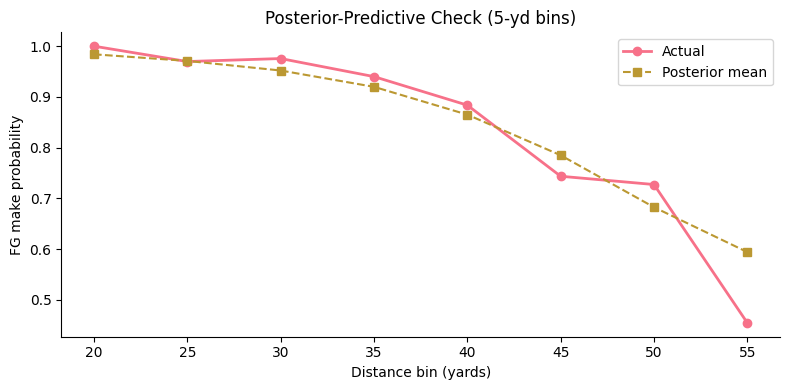

In [18]:
# %%writefile src/nfl_kicker_analysis/models/bayesian.py
"""
Bayesian models for NFL kicker analysis.
Provides hierarchical Bayesian logistic regression and evaluation utilities using PyMC.
"""
from __future__ import annotations

import numpy as np                             # Core numerical arrays
import pandas as pd                            # DataFrame handling
import pymc as pm                              # Bayesian modeling
import arviz as az                             # Posterior analysis
from arviz.data.inference_data import InferenceData
import xarray as xr                            # 📥 Required for posterior casting :contentReference[oaicite:6]{index=6}
import matplotlib.pyplot as plt                # Plot utilities
from matplotlib.axes import Axes
from scipy import stats                        # ECDF and stats functions
import time                                    # Timestamps for file naming
import json                                    # JSON metadata
from pathlib import Path
from typing import (
    Dict, Any, TYPE_CHECKING, Optional, Union,
    List, Tuple, cast, Protocol
)

from src.nfl_kicker_analysis.utils.metrics import ModelEvaluator
from src.nfl_kicker_analysis.config import config, FEATURE_LISTS  # Move import to module level
from src.nfl_kicker_analysis.data.preprocessor import DataPreprocessor
from src.nfl_kicker_analysis.eda import _FIELD_GOAL_RESULT_SUCCESS  # NEW: Import success constant


from xarray import Dataset
import xarray as xr
from numpy.typing import ArrayLike

__all__ = [
    "BayesianModelSuite",
]

# Add debug flag
DEBUG = True

def debug_print(*args, **kwargs):
    if DEBUG:
        print("🔍 DEBUG:", *args, **kwargs)

class HasPosterior(Protocol):
    """Protocol for objects with posterior attribute."""
    posterior: Any

class HasPosteriorPredictive(Protocol):
    """Protocol for objects with posterior_predictive attribute."""
    posterior_predictive: Any

def _get_posterior_mean(trace: InferenceData, var_name: str) -> Union[float, np.ndarray]:
    """
    Safely extract posterior means from an ArviZ InferenceData object.
    """
    if not hasattr(trace, "posterior"):
        raise RuntimeError("InferenceData object has no posterior group")
    # Access posterior using getattr to handle dynamic attributes
    posterior = getattr(trace, "posterior")
    if var_name not in posterior:
        raise KeyError(f"Variable {var_name} not found in posterior")
    # Collapse over chain & draw dims to get the mean
    result = posterior[var_name].mean(("chain", "draw")).values
    return float(result) if isinstance(result, (float, np.floating)) else result

def _get_posterior_predictive(trace: InferenceData, var_name: str) -> np.ndarray:
    """
    Safely extract posterior predictive samples from an ArviZ InferenceData object.
    """
    if not hasattr(trace, "posterior_predictive"):
        raise RuntimeError("InferenceData object has no posterior_predictive group")
    pp = getattr(trace, "posterior_predictive")
    if var_name not in pp:
        raise KeyError(f"Variable {var_name} not found in posterior_predictive")
    return np.asarray(pp[var_name].values)


def _plot_comparison(
    ax: Axes,
    x_vals: ArrayLike,
    actual: ArrayLike,
    predicted: ArrayLike,
    xlabel: str,
    title: str
) -> None:
    """Helper to plot actual vs predicted values."""
    ax.plot(np.asarray(x_vals), np.asarray(actual), marker="o", label="Actual", linewidth=2)
    ax.plot(np.asarray(x_vals), np.asarray(predicted), marker="s", label="Posterior mean", linestyle="--")
    ax.set_xlabel(xlabel)
    ax.set_ylabel("FG make probability")
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()

class BayesianModelSuite:
    """Hierarchical Bayesian logistic‑regression models for kicker analysis."""

    def __init__(
        self,
        *,
        draws: int = 1_000,
        tune: int = 1_000,
        target_accept: float = 0.95,  # Increased from 0.9 to reduce divergences
        include_random_slope: bool = False,
        random_seed: Optional[int] = 42,
    ) -> None:
        debug_print("Initializing BayesianModelSuite")
        
        # Validate configuration
        required_config = [
            'BAYESIAN_MCMC_SAMPLES',
            'BAYESIAN_TUNE',
            'BAYESIAN_CHAINS',
            'MIN_DISTANCE',
            'MAX_DISTANCE',
            'MIN_KICKER_ATTEMPTS',
            'SEASON_TYPES'
        ]
        
        missing = [attr for attr in required_config if not hasattr(config, attr)]
        if missing:
            raise ValueError(f"Missing required configuration attributes: {missing}")
            
        # Override defaults with config values if provided
        self.draws = config.BAYESIAN_MCMC_SAMPLES if draws == 1_000 else draws
        self.tune = config.BAYESIAN_TUNE if tune == 1_000 else tune
        self.target_accept = target_accept
        self.include_random_slope = include_random_slope
        self.random_seed = random_seed

        # Model components - set during fit()
        self._model: Optional[pm.Model] = None
        self._trace: Optional[InferenceData] = None
        self._kicker_map: Dict[int, int] = {}
        self._distance_mu: float = 0.0
        self._distance_sigma: float = 1.0
        self.baseline_probs: Dict[int, float] = {}  # For consistent EPA baselines with EPACalculator
        self.evaluator = ModelEvaluator()
        debug_print("Initialization complete")

    def _bootstrap_distances(
        self,
        distances: ArrayLike,
        n_samples: int,
        rng: np.random.Generator,
    ) -> np.ndarray:
        """
        Bootstrap sample distances from an empirical distribution.
        
        Parameters
        ----------
        distances : array of actual distances to sample from
        n_samples : number of bootstrap samples to draw
        rng : numpy random number generator
        
        Returns
        -------
        ndarray of shape (n_samples,)
            Resampled distances with replacement
        """
        return rng.choice(np.asarray(distances), size=n_samples, replace=True)

    # ---------------------------------------------------------------------
    # 🛠️  Helper utilities
    # ---------------------------------------------------------------------
    def _standardize(self, x: np.ndarray, *, fit: bool = False) -> np.ndarray:
        if fit:
            self._distance_mu = float(x.mean())
            self._distance_sigma = float(x.std())
        return (x - self._distance_mu) / self._distance_sigma

    def _encode_kicker(self, raw_ids: ArrayLike, *, fit: bool = False,
                       unknown_action: str = "average") -> np.ndarray:
        """
        Map raw kicker IDs → compact indices (kicker_idx).
        """
        raw_ids_arr = np.asarray(raw_ids)
        if fit:
            unique_ids = np.unique(raw_ids_arr)
            debug_print(f"Fitting kicker map with {len(unique_ids)} unique IDs")
            debug_print(f"Raw IDs: {unique_ids.tolist()}")
            self._kicker_map = {int(pid): i for i, pid in enumerate(unique_ids)}
            debug_print(f"First few mappings: {dict(list(self._kicker_map.items())[:3])}")
        
        # Convert to list of ints for safer lookup
        raw_ids_list = [int(pid) for pid in raw_ids_arr]
        debug_print(f"Looking up {len(raw_ids_list)} IDs")
        debug_print(f"Sample raw IDs: {raw_ids_list[:5]}")
        debug_print(f"Kicker map size: {len(self._kicker_map)}")
        
        # Map IDs to indices, using -1 for unknown
        idx = np.array([self._kicker_map.get(pid, -1) for pid in raw_ids_list], dtype=int)
        n_unseen = (idx == -1).sum()
        
        if n_unseen > 0:
            msg = f"{n_unseen} unseen kicker IDs – mapped to league mean."
            if unknown_action == "raise":
                raise ValueError(msg)
            elif unknown_action == "warn":
                debug_print("⚠️ " + msg)
                debug_print(f"Unmapped IDs: {[pid for pid in raw_ids_list if pid not in self._kicker_map]}")

        return idx

    # ---------------------------------------------------------------------
    # 🔨  Model construction
    # ---------------------------------------------------------------------
    def _build_model(
        self,
        distance_std: np.ndarray,
        age_c: np.ndarray,           # <-- NEW: centered age
        age_c2: np.ndarray,          # <-- NEW: quadratic age
        exp_std: np.ndarray,
        success: np.ndarray,
        kicker_idx: np.ndarray,
        n_kickers: int,
    ) -> pm.Model:
        with pm.Model() as model:
            # Population-level effects
            alpha = pm.Normal("alpha", 1.5, 1.0)
            beta_dist = pm.Normal("beta_dist", -1.5, 0.8)
            
            # Age effects (linear + quadratic)
            beta_age  = pm.Normal("beta_age",  0.0, 0.5)
            beta_age2 = pm.Normal("beta_age2", 0.0, 0.5)
            beta_exp  = pm.Normal("beta_exp",  0.0, 0.5)

            # Per-kicker random intercepts (non-centered)
            σ_u   = pm.HalfNormal("sigma_u", 0.8)
            u_raw = pm.Normal("u_raw", 0.0, 1.0, shape=n_kickers)
            u     = pm.Deterministic("u", σ_u * u_raw)

            # Per-kicker random aging slopes (optional enhancement)
            if self.include_random_slope:
                σ_age = pm.HalfNormal("sigma_age", 0.5)
                a_raw = pm.Normal("a_raw", 0.0, 1.0, shape=n_kickers)
                a_k   = pm.Deterministic("a_k", σ_age * a_raw)
                age_slope_effect = a_k[kicker_idx] * age_c
            else:
                age_slope_effect = 0.0

            # Linear predictor
            lin_pred = (
                alpha
                + (beta_dist * distance_std)
                + (beta_age * age_c) + age_slope_effect
                + (beta_age2 * age_c2)
                + (beta_exp * exp_std)
                + u[kicker_idx]
            )

            θ = pm.Deterministic("theta", pm.invlogit(lin_pred))
            pm.Bernoulli("obs", p=θ, observed=success)
        return model

    # ---------------------------------------------------------------------
    # 📈  Public API
    # ---------------------------------------------------------------------
    def fit(self, df, *, preprocessor=None):
        debug_print(f"Starting fit with preprocessor: {preprocessor is not None}")
        debug_print(f"Input DataFrame rows: {len(df)}")
        debug_print(f"DataFrame engineered flag: {df.attrs.get('engineered', False)}")
        debug_print(f"DataFrame columns: {df.columns.tolist()}")
        
        # ------------------------------------------------------------------
        # 0️⃣  Exactly one preprocessing pass
        if df.attrs.get("engineered", False):
            processed = df.copy()
            debug_print("Using pre-engineered data")
        elif preprocessor is not None:
            debug_print("Using provided preprocessor")
            debug_print("Preprocessor config:", preprocessor.__dict__)
            processed = preprocessor.preprocess_slice(df)
        else:
            # 🎯 AUTO-CREATE BAYESIAN-MINIMAL PREPROCESSOR 
            # Using module-level imports instead of local imports
            debug_print("Creating minimal preprocessor")
            bayes_preprocessor = DataPreprocessor()
            bayes_preprocessor.update_config(
                min_distance=config.MIN_DISTANCE,
                max_distance=config.MAX_DISTANCE, 
                min_kicker_attempts=config.MIN_KICKER_ATTEMPTS,
                season_types=config.SEASON_TYPES,
                include_performance_history=False,  # Not needed for Bayesian
                include_statistical_features=False,  # Avoid complex features
                include_player_status=True,  # Enable player status features
                performance_window=12
            )
            bayes_preprocessor.update_feature_lists(**FEATURE_LISTS)
            processed = bayes_preprocessor.preprocess_slice(df)
            debug_print("Minimal preprocessing complete")

        debug_print(f"Processed DataFrame rows: {len(processed)}")
        debug_print(f"Processed columns: {processed.columns.tolist()}")

        # ------------------------------------------------------------------
        # 1️⃣  Predictors
        debug_print("Preparing predictors")
        dist_std = self._standardize(processed["attempt_yards"].to_numpy(float), fit=True)
        debug_print(f"Distance stats - mean: {self._distance_mu:.2f}, std: {self._distance_sigma:.2f}")
        
        # Age variables (centered & scaled)
        age_c  = processed["age_c"].to_numpy(float) if "age_c" in processed.columns else np.zeros(len(processed), dtype=float)
        age_c2 = processed["age_c2"].to_numpy(float) if "age_c2" in processed.columns else np.zeros(len(processed), dtype=float)
        debug_print(f"Age features present: age_c={age_c is not None}, age_c2={age_c2 is not None}")

        # Handle experience standardization
        if "exp_100" in processed.columns:
            exp_std = (
                (processed["exp_100"] - processed["exp_100"].mean()) /
                processed["exp_100"].std()
            ).to_numpy(float)
            debug_print("Experience features included")
        else:
            exp_std = np.zeros(len(processed), dtype=float)
            debug_print("No experience features found")
            
        success    = processed["success"].to_numpy(int)
        kicker_idx = self._encode_kicker(processed["kicker_id"].to_numpy(int), fit=True)
        n_kickers  = len(self._kicker_map)
        debug_print(f"Number of kickers: {n_kickers}")
        debug_print(f"Success rate: {success.mean():.3f}")

        # ---- model & sampling -------------------------------------------
        debug_print("Building model")
        self._model = self._build_model(
            dist_std, age_c, age_c2, exp_std, success, kicker_idx, n_kickers
        )
        
        # ── FIX: ensure pm.sample knows which model to use ────────────
        debug_print("Starting MCMC sampling")
        with self._model:
            self._trace = pm.sample(
                draws=self.draws,
                tune=self.tune,
                chains=config.BAYESIAN_CHAINS,  # Use config value
                target_accept=self.target_accept,
                random_seed=self.random_seed,
                return_inferencedata=True
            )
        debug_print("Sampling complete")

        from src.nfl_kicker_analysis.models.bayes_model_utils import save_pymc_inference
        # ── ENSURE model directory exists & write full suite ────────────────
        try:
            config.MODEL_DIR.mkdir(parents=True, exist_ok=True)
            ts = int(time.time())
            suite_dir = config.MODEL_DIR / f"bayesian_suite_{ts}"
            self.save_suite(suite_dir)
            debug_print(f"✅ Full Bayesian suite saved to {suite_dir!r}")
        except Exception as e:
            debug_print(f"⚠️ Failed to persist full suite: {e}")

        return self

    def predict(
        self,
        df: pd.DataFrame,
        *,
        return_ci: bool = False,
        return_proba: bool = True,
        preprocessor=None
    ):
        """
        Predict FG make probabilities or credible intervals on new data.
        
        Parameters
        ----------
        df : DataFrame to predict on
        return_ci : bool, default False
            If True, returns (mean, lower, upper) credible intervals
        return_proba : bool, default True
            If True, returns probabilities; if False, returns 0/1 predictions
        preprocessor : optional preprocessor to use
        
        Returns
        -------
        If return_ci=False:
            pd.Series of probabilities (if return_proba=True) or 0/1 (if False)
        If return_ci=True:
            Tuple of (mean, lower, upper) Series
        """
        if self._trace is None:
            raise RuntimeError("Model not yet fitted or loaded.")

        original_idx = df.index
        # 1️⃣ Preprocess
        proc = preprocessor.preprocess_slice(df) if preprocessor else df.copy()

        # 2️⃣ Standardize distances using helper
        dist_std = self._standardize(
            proc["attempt_yards"].to_numpy(float),
            fit=False
        )

        # 3️⃣ Map kickers → indices
        kicker_idx = self._encode_kicker(
            proc["kicker_id"].to_numpy(int),
            fit=False,
            unknown_action="average"
        )

        # 4️⃣ Get age and experience features
        age_c = proc["age_c"].to_numpy(float) if "age_c" in proc.columns else np.zeros(len(proc))
        age_c2 = proc["age_c2"].to_numpy(float) if "age_c2" in proc.columns else np.zeros(len(proc))
        
        if "exp_100" in proc.columns:
            exp_std = (
                (proc["exp_100"] - proc["exp_100"].mean()) /
                proc["exp_100"].std()
            ).to_numpy(float)
        else:
            exp_std = np.zeros(len(proc))

        # 5️⃣ Collapse posterior to means using helper
        a_mean = float(_get_posterior_mean(self._trace, "alpha"))
        b_mean = float(_get_posterior_mean(self._trace, "beta_dist"))
        u_mean_result = _get_posterior_mean(self._trace, "u")
        
        # Get age and experience coefficients
        beta_age_mean = float(_get_posterior_mean(self._trace, "beta_age"))
        beta_age2_mean = float(_get_posterior_mean(self._trace, "beta_age2"))
        beta_exp_mean = float(_get_posterior_mean(self._trace, "beta_exp"))

        # 6️⃣ Point predictions
        if not return_ci:
            # Handle u_mean indexing - ensure it's an array
            if isinstance(u_mean_result, (int, float)):
                u_effects = np.full(len(kicker_idx), u_mean_result)
            else:
                u_mean_arr = np.asarray(u_mean_result)
                u_effects = u_mean_arr[kicker_idx]
            
            # Full linear predictor with all effects
            logit = (
                a_mean
                + b_mean * dist_std
                + beta_age_mean * age_c
                + beta_age2_mean * age_c2
                + beta_exp_mean * exp_std
                + u_effects
            )
            
            # Convert to probabilities
            probs = 1 / (1 + np.exp(-logit))
            
            # Handle NaN values consistently
            probs = np.where(np.isnan(logit), np.nan, probs)
            
            # Return probabilities or classifications
            result = pd.Series(probs, index=proc.index).reindex(original_idx)
            if not return_proba:
                result = (result > 0.5).astype(float)
            return result

        # 7️⃣ Credible intervals via posterior predictive
        ppc = pm.sample_posterior_predictive(
            self._trace,
            model=self._model,
            var_names=["obs"],
            random_seed=self.random_seed,
            progressbar=False,
            return_inferencedata=True
        )
        draws = _get_posterior_predictive(ppc, "obs")
        mean_preds = draws.mean(axis=(0, 1))
        lower, upper = np.percentile(draws, [2.5, 97.5], axis=(0, 1))

        s_mean = pd.Series(mean_preds, index=proc.index).reindex(original_idx)
        s_lower = pd.Series(lower, index=proc.index).reindex(original_idx)
        s_upper = pd.Series(upper, index=proc.index).reindex(original_idx)
        return s_mean, s_lower, s_upper

    def evaluate(
        self, 
        df: pd.DataFrame, 
        *, 
        preprocessor=None
    ) -> Dict[str, float]:
        """Compute AUC, Brier score & log‑loss on provided data.
        
        Args:
            df: Data to evaluate on
            preprocessor: Optional DataPreprocessor instance. If provided, will
                         use it to preprocess the data before evaluation.
        """
        # Apply preprocessing if provided  
        if preprocessor is not None:
            df = preprocessor.preprocess_slice(df)
                
        y_true = df["success"].to_numpy(dtype=int)
        y_pred_result = self.predict(df)  # predict() will handle its own preprocessing if needed
        
        # Handle both single prediction and CI tuple returns
        if isinstance(y_pred_result, tuple):
            y_pred = y_pred_result[0]  # Just use mean predictions for evaluation
        else:
            y_pred = y_pred_result
            
        return self.evaluator.calculate_classification_metrics(y_true, y_pred)

    def diagnostics(self, *, return_scalars: bool = False) -> Dict[str, Any]:
        """
        Compute and return MCMC diagnostics.

        Parameters
        ----------
        return_scalars : bool, default False
            If True, also include convenience keys
            ``rhat_max`` and ``ess_min`` for quick threshold checks.

        Returns
        -------
        dict
            Keys: rhat, ess (xarray.Dataset), rhat_vals, ess_vals (np.ndarray),
            summary_ok (bool), and optionally rhat_max, ess_min (float).
        """
        if self._trace is None:
            raise RuntimeError("Model not yet fitted.")

        # ArviZ calls (collapse chain/draw)
        rhats = cast(Dataset, az.rhat(self._trace))
        ess   = cast(Dataset, az.ess(self._trace))

        # Flatten → numpy for easy thresholding
        rhat_vals = rhats.to_array().values.ravel()
        ess_vals  = ess.to_array().values.ravel()

        summary_ok = (rhat_vals <= 1.01).all() and (ess_vals >= 100).all()
        if not summary_ok:
            print("⚠️  Sampling diagnostics outside recommended thresholds.")

        out = {
            "rhat": rhats,
            "ess": ess,
            "rhat_vals": rhat_vals,
            "ess_vals": ess_vals,
            "summary_ok": summary_ok,
        }
        if return_scalars:
            out["rhat_max"] = float(rhat_vals.max())
            out["ess_min"] = float(ess_vals.min())
        return out

    # -----------------------------------------------------------------
    # 🌟  NEW 1: kicker-level credible interval
    # -----------------------------------------------------------------
    def kicker_interval(
        self,
        kicker_id: int,
        distance: float | None = None,
        ci: float = 0.95,
    ) -> Dict[str, float]:
        """
        Return mean, lower, upper success probability for a *single* kicker.

        Args
        ----
        kicker_id : raw ID as in dataframe
        distance  : yards; if None, uses the empirical mean distance of
                    training data, transformed with stored μ/σ.
        ci        : central credible-interval mass (default 0.95)
        """
        if self._trace is None:
            raise RuntimeError("Model must be fitted first")

        # 1 → index or league-mean column
        k_idx = self._kicker_map.get(kicker_id, -1)
        pad_col = len(self._kicker_map)   # after pad in predict()

        # 2 → choose distance
        if distance is None:
            distance_std = 0.0            # z-score of mean is 0
        else:
            distance_std = (distance - self._distance_mu) / self._distance_sigma

        posterior = getattr(self._trace, "posterior")
        a = posterior["alpha"].values.flatten()
        
        # Robust lookup for the distance slope parameter (handles naming changes)
        slope_name = "beta_dist" if "beta_dist" in posterior else "beta"
        b = posterior[slope_name].values.flatten()
        
        u = posterior["u"].values.reshape(a.size, -1)

        # pad league-mean
        u = np.pad(u, ((0, 0), (0, 1)), constant_values=0.0)
        idx = pad_col if k_idx == -1 else k_idx

        logit_p = a + b * distance_std + u[:, idx]
        p = 1 / (1 + np.exp(-logit_p))

        lower, upper = np.quantile(p, [(1-ci)/2, 1-(1-ci)/2])
        return {"mean": p.mean(), "lower": lower, "upper": upper,
                "n_draws": p.size, "distance_std": distance_std}

    # -----------------------------------------------------------------
    # 🌟  NEW 2: posterior-predictive plot across 5-yd bins
    # -----------------------------------------------------------------
    def plot_distance_ppc(
        self,
        df: pd.DataFrame,
        *,
        bin_width: int = 5,
        preprocessor = None,
        ax: Optional[Axes] = None
    ) -> Axes:
        """
        Bin attempts by distance and overlay actual vs posterior mean make-rate.
        """
        if preprocessor is not None:
            df = preprocessor.preprocess_slice(df)

        # 1 Actual success by bin
        df = df.copy()
        df["bin"] = (df["attempt_yards"] // bin_width) * bin_width
        actual = df.groupby("bin")["success"].mean()

        # 2 Posterior mean per attempt → group
        preds = self.predict(df)
        df["pred"] = preds
        posterior = df.groupby("bin")["pred"].mean()

        # 3 Plot
        if ax is None:
            _, ax = plt.subplots(figsize=(8, 4))
        
        _plot_comparison(
            ax,
            x_vals=np.asarray(actual.index),
            actual=np.asarray(actual),
            predicted=np.asarray(posterior),
            xlabel="Distance bin (yards)",
            title=f"Posterior-Predictive Check ({bin_width}-yd bins)"
        )
        return ax

    # -----------------------------------------------------------------
    # 🌟  NEW 3: age-binned posterior-predictive check
    # -----------------------------------------------------------------
    def plot_age_ppc(
        self,
        df: pd.DataFrame,
        *,
        bin_width: float = 2.0,
        preprocessor = None,
        ax: Optional[Axes] = None
    ) -> Axes:
        """
        Bin attempts by age and overlay actual vs posterior mean make-rate.
        """
        if preprocessor is not None:
            df = preprocessor.preprocess_slice(df)

        # Use raw age for binning (more interpretable)
        age_col = "age_at_attempt" if "age_at_attempt" in df.columns else "age_c"
        df = df.copy()
        
        if age_col == "age_c":
            # Convert back to raw age for binning
            df["age_bin"] = ((df["age_c"] * 10 + 30) // bin_width) * bin_width
        else:
            df["age_bin"] = (df[age_col] // bin_width) * bin_width
            
        # Actual success by age bin
        actual = df.groupby("age_bin")["success"].mean()

        # Posterior mean per attempt → group by age
        preds = self.predict(df)
        df["pred"] = preds
        posterior = df.groupby("age_bin")["pred"].mean()

        # Plot
        if ax is None:
            _, ax = plt.subplots(figsize=(8, 4))
            
        _plot_comparison(
            ax,
            x_vals=np.asarray(actual.index),
            actual=np.asarray(actual),
            predicted=np.asarray(posterior),
            xlabel="Age bin (years)",
            title=f"Age-Based Posterior-Predictive Check ({bin_width:.1f}-yr bins)"
        )
        return ax

    # ───────────────────────────────────────────────────────────
    # Helper: draw-level EPA simulation  (fully replaced)
    # ───────────────────────────────────────────────────────────
    def _epa_fg_plus_draws(
        self,
        league_df: pd.DataFrame,
        *,
        kicker_ids: ArrayLike,
        n_samples: int,                 # renamed for clarity
        rng: np.random.Generator,
        distance_strategy: str = "kicker",
        τ: float = 20.0,
        **kwargs,
    ) -> np.ndarray:
        """
        Bootstrap EPA-FG⁺ draws for a set of kickers.
        
        Parameters
        ----------
        league_df : DataFrame with at least ['player_id', 'attempt_yards', 'success']
        kicker_ids : array of kicker IDs to compute for
        n_samples : number of bootstrap samples per kicker
        rng : numpy random number generator
        distance_strategy : how to sample distances ('kicker' or 'league')
        τ : shrinkage parameter for empirical Bayes
        **kwargs : future-proofing for additional options
        
        Returns
        -------
        ndarray of shape (n_samples, len(kicker_ids))
            Each column is the EPA-FG⁺ draws for one kicker
        """
        n_draws = n_samples                # ← backward compatibility shim
        kicker_ids_arr = np.asarray(kicker_ids)
        
        # Validate inputs
        if not isinstance(league_df, pd.DataFrame):
            raise TypeError("league_df must be a pandas DataFrame")
        if not isinstance(n_draws, int) or n_draws <= 0:
            raise ValueError("n_draws must be a positive integer")
            
        # Get baseline probabilities if not already computed
        if not self.baseline_probs:
            from src.nfl_kicker_analysis.utils.metrics import EPACalculator
            self.baseline_probs = EPACalculator().calculate_baseline_probs(league_df)
            
        # Initialize output array
        epa_draws = np.zeros((n_draws, len(kicker_ids_arr)))
        
        # For each kicker...
        for k, kid in enumerate(kicker_ids_arr):
            # Get this kicker's attempts
            mask = league_df['player_id'] == kid
            k_data = league_df[mask]
            
            if len(k_data) == 0:
                continue  # Skip if no data (shouldn't happen given filtering)
                
            # Bootstrap distances based on strategy
            if distance_strategy == "kicker":
                # Sample from this kicker's empirical distribution
                distances = self._bootstrap_distances(
                    k_data['attempt_yards'],
                    n_draws,
                    rng=rng
                )
            else:
                # Sample from league-wide distribution
                distances = self._bootstrap_distances(
                    league_df['attempt_yards'],
                    n_draws,
                    rng=rng
                )
                
            # Get baseline probabilities for these distances
            baseline_probs = np.array([
                self.baseline_probs.get(int(d), 0.5) for d in distances
            ])
            
            # Compute actual success rate (with Bayesian shrinkage)
            n_attempts = len(k_data)
            raw_rate = k_data['success'].mean()
            
            # Empirical Bayes shrinkage toward league average
            shrinkage = n_attempts / (n_attempts + τ)
            success_rate = (shrinkage * raw_rate + 
                          (1 - shrinkage) * np.mean(list(self.baseline_probs.values())))
            
            # EPA = (actual - expected) × points
            epa_draws[:, k] = 3 * (success_rate - baseline_probs)
            
        return epa_draws

    # ───────────────────────────────────────────────────────────────
    # PUBLIC – EPA-FG⁺ leaderboard with robust column checks
    # ───────────────────────────────────────────────────────────────
    def epa_fg_plus(
        self,
        df: pd.DataFrame,
        *,
        min_attempts: int = 20,
        n_samples: int | None = None,
        return_ci: bool = False,
    ) -> pd.DataFrame:
        """
        Build an EPA-FG⁺ leaderboard, optionally with bootstrap CIs and certainty levels.

        Returns a DataFrame indexed by player_id, with columns:
        - rank, player_name, total_attempts, epa_fg_plus_mean
        - (if return_ci=True) hdi_lower, hdi_upper, certainty_level
        - plus raw_success_rate, avg_distance, player_status, last_age, seasons_exp
        """
        debug_print(f"epa_fg_plus called with min_attempts={min_attempts}, "
                    f"n_samples={n_samples}, return_ci={return_ci}")

        # 1️⃣ Defaults & RNG
        if n_samples is None:
            n_samples = config.BAYESIAN_MCMC_SAMPLES
        rng = np.random.default_rng(self.random_seed or 42)

        # 2️⃣ Ensure EPA columns present
        from src.nfl_kicker_analysis.data.feature_engineering import ensure_epa_columns
        work = ensure_epa_columns(df.copy())

        # 3️⃣ Baseline probabilities cache
        if not self.baseline_probs:
            from src.nfl_kicker_analysis.utils.metrics import EPACalculator
            self.baseline_probs = EPACalculator().calculate_baseline_probs(work)

        # 4️⃣ Bootstrap draws
        kicker_ids = work["player_id"].unique()
        draws = self._epa_fg_plus_draws(
            work, kicker_ids=kicker_ids, n_samples=n_samples, rng=rng
        )

        # 5️⃣ Summarize draws
        means  = draws.mean(axis=0)
        lowers, uppers = np.percentile(draws, [2.5, 97.5], axis=0)

        # 6️⃣ Build base summary
        summary = pd.DataFrame({
            "player_id":   kicker_ids,
            "epa_fg_plus": means,
            "hdi_lower":   lowers,
            "hdi_upper":   uppers,
        })

        # 7️⃣ Enrich with metadata
        meta = (
            work.groupby("player_id")
                .agg(
                    player_name       = ("player_name", "first"),
                    attempts          = ("success", "size"),
                    raw_success_rate  = ("success", "mean"),
                    avg_distance      = ("attempt_yards", "mean"),
                    player_status     = ("player_status", "first"),
                    last_age          = ("age_at_attempt", "max"),
                    seasons_exp       = ("season", "nunique"),
                )
                .reset_index()
        )
        summary = (
            summary
            .merge(meta, on="player_id", how="left")
            .query("attempts >= @min_attempts")
            .sort_values("epa_fg_plus", ascending=False)
            .reset_index(drop=True)
            .assign(rank=lambda d: d.index + 1)
        )

        # 8️⃣ Rename for downstream code
        summary = summary.rename(columns={
            "epa_fg_plus": "epa_fg_plus_mean",
            "attempts":    "total_attempts",
        })

        # 9️⃣ ✨ NEW: set raw player_id as the DataFrame index
        summary = summary.set_index("player_id", drop=True)
        debug_print("After set_index, summary.index:", summary.index[:5])

        # 🔟 Compute certainty if requested
        if return_ci:
            ci_widths = summary["hdi_upper"] - summary["hdi_lower"]
            q33, q66 = np.percentile(ci_widths, [33.3, 66.6])
            def label(w):
                if w <= q33:    return "high"
                if w <= q66:    return "medium"
                return "low"
            summary["certainty_level"] = ci_widths.map(label)

        # 1️⃣1️⃣ Final column order
        cols = [
            "rank", "player_name", "total_attempts", "epa_fg_plus_mean",
            "raw_success_rate", "avg_distance", "player_status",
            "last_age", "seasons_exp",
        ]
        if return_ci:
            cols += ["hdi_lower", "hdi_upper", "certainty_level"]

        debug_print("Final EPA table columns:", cols)
        return summary[cols]

    # ---------------------------------------------------------------------
    # 🔍  Helper methods for kicker ID/name conversion
    # ---------------------------------------------------------------------
    def get_kicker_id_by_name(self, df: pd.DataFrame, player_name: str) -> int | None:
        """
        Get kicker_id for a given player_name from the dataset.
        
        Args:
            df: DataFrame containing kicker_id and player_name columns
            player_name: Name of the kicker to look up
            
        Returns:
            kicker_id if found, None otherwise
        """
        debug_print(f"Looking up kicker: {player_name}")
        debug_print(f"DataFrame columns: {df.columns.tolist()}")
        debug_print(f"Number of unique kickers: {df['player_name'].nunique()}")
        
        matches = df[df["player_name"] == player_name]["kicker_id"]
        debug_print(f"Found matches: {matches.tolist()}")
        
        if len(matches) == 0:
            debug_print("No matches found")
            return None
            
        unique_matches = matches.unique()
        debug_print(f"Unique kicker IDs: {unique_matches.tolist()}")
        
        # Check if this ID exists in our mapping
        raw_id = int(unique_matches[0])
        mapped_idx = self._kicker_map.get(raw_id)
        debug_print(f"Raw ID: {raw_id}, Mapped index: {mapped_idx}")
        debug_print(f"Kicker map size: {len(self._kicker_map)}")
        debug_print(f"Available mappings: {self._kicker_map}")
        
        return mapped_idx
    
    def get_kicker_name_by_id(self, df: pd.DataFrame, kicker_id: int) -> str | None:
        """
        Get player_name for a given kicker_id from the dataset.
        
        Args:
            df: DataFrame containing kicker_id and player_name columns
            kicker_id: ID of the kicker to look up
            
        Returns:
            player_name if found, None otherwise
        """
        matches = df[df["kicker_id"] == kicker_id]["player_name"].unique()
        return str(matches[0]) if len(matches) > 0 else None
    
    def kicker_interval_by_name(
        self,
        df: pd.DataFrame,
        player_name: str,
        distance: float | None = None,
        ci: float = 0.95,
    ) -> Dict[str, float]:
        """
        Return mean, lower, upper success probability for a kicker by name.
        
        Args:
            df: DataFrame containing kicker mappings
            player_name: Name of the kicker
            distance: yards; if None, uses empirical mean
            ci: central credible-interval mass (default 0.95)
        """
        kicker_id = self.get_kicker_id_by_name(df, player_name)
        if kicker_id is None:
            raise ValueError(f"Kicker '{player_name}' not found in dataset")
        return self.kicker_interval(kicker_id, distance, ci)

    def save_suite(self, dirpath: Path | str) -> None:
        """
        Persist the trained suite to *dirpath* in a **fully deterministic**
        fashion so that a reload followed by ``predict`` returns *bit-for-bit*
        identical probabilities.

        What we store
        -------------
        1. The full ArviZ ``InferenceData`` object → ``trace.nc`` (NetCDF).
        2. A JSON side-car ``meta.json`` containing:
           • distance mean / std  (rounded to 12 dp to avoid JSON drift)
           • kicker_map – serialised as **string keys**, **stable order** (sorted
             by the *value* which is the contiguous index used by the sampler).
        """
        dirpath = Path(dirpath)
        dirpath.mkdir(parents=True, exist_ok=True)

        # 1️⃣ Save the InferenceData exactly as returned by PyMC/ArviZ.
        trace_file = dirpath / "trace.nc"
        if self._trace is not None:
            self._trace.to_netcdf(str(trace_file))  # Convert Path to str for to_netcdf

        # 2️⃣ Build a JSON-serialisable metadata dict.
        # Sort by value (index) for stable ordering
        ordered_map = {
            str(k): int(v)           # keys → str for JSON, values stay int
            for k, v in sorted(self._kicker_map.items(), key=lambda kv: kv[1])
        }

        # Round floats to avoid JSON drift
        meta = {
            "version": "1.0.0",  # Add version for future compatibility
            "distance_mu": round(float(self._distance_mu), 12),
            "distance_sigma": round(float(self._distance_sigma), 12),
            "kicker_map": ordered_map,
        }

        # Debug prints
        debug_print("Saving suite metadata:")
        debug_print(f"  distance_mu: {meta['distance_mu']}")
        debug_print(f"  distance_sigma: {meta['distance_sigma']}")
        debug_print(f"  kicker_map (first 3): {dict(list(ordered_map.items())[:3])}")

        with open(dirpath / "meta.json", "w", encoding="utf-8") as f:
            json.dump(meta, f, separators=(",", ":"))   # compact, stable

        debug_print(f"✅ Suite saved deterministically to {dirpath!r}")

    def save_metrics(self, dirpath: Path | str, metrics: dict) -> None:
        """
        Persist evaluation metrics alongside trace.nc and meta.json.
        
        Parameters
        ----------
        dirpath : Path or str
            Directory where the suite is saved
        metrics : dict
            Dictionary of evaluation metrics to persist
            
        Notes
        -----
        This ensures metrics computed during training are preserved exactly
        and can be loaded by the Streamlit app without recomputation.
        """
        dirpath = Path(dirpath)
        metrics_file = dirpath / "metrics.json"
        # Write with indentation for readability
        with open(metrics_file, "w", encoding="utf-8") as f:
            json.dump(metrics, f, indent=2)
        debug_print(f"✅ Metrics saved to {metrics_file!r}")

    @classmethod
    def load_suite(cls, dirpath: Path | str) -> "BayesianModelSuite":
        """
        Reload a suite that was persisted by :py:meth:`save_suite`.
        The returned instance is guaranteed to yield **identical** predictions
        to the original suite (within IEEE-754 floating point rules).
        """
        dirpath = Path(dirpath)
        if not dirpath.exists():
            raise FileNotFoundError(f"No saved suite at {dirpath}")

        # 1️⃣ Create a fresh instance so that __init__ validations run.
        suite = cls()

        # 2️⃣ Load metadata
        with open(dirpath / "meta.json", "r", encoding="utf-8") as f:
            meta = json.load(f)
            
        # Check version compatibility
        version = meta.get("version", "0.0.0")  # Default for older saves
        if version != "1.0.0":
            debug_print(f"⚠️ Warning: Loading model version {version}, current version is 1.0.0")

        suite._distance_mu = float(meta["distance_mu"])
        suite._distance_sigma = float(meta["distance_sigma"])
        
        # Reconstruct the kicker_map **exactly** as before (value-sorted)
        suite._kicker_map = {
            int(k): int(v) for k, v in sorted(meta["kicker_map"].items(), key=lambda kv: int(kv[1]))
        }

        # Debug prints
        debug_print("Loading suite metadata:")
        debug_print(f"  distance_mu: {suite._distance_mu}")
        debug_print(f"  distance_sigma: {suite._distance_sigma}")
        debug_print(f"  kicker_map (first 3): {dict(list(suite._kicker_map.items())[:3])}")

        # 3️⃣ Load the trace
        suite._trace = az.from_netcdf(dirpath / "trace.nc")

        debug_print(f"✅ Suite loaded from {dirpath!r} — distance μ/σ = {suite._distance_mu:.4f}/{suite._distance_sigma:.4f}; {len(suite._kicker_map)} kickers.")
        return suite

    def verify_persistence(self, test_data: pd.DataFrame, *, preprocessor=None) -> bool:
        """
        Verify that model persistence is working correctly by saving and loading
        the model, then comparing predictions within floating-point tolerances.
        """
        import tempfile
        from pathlib import Path

        debug_print("Verifying model persistence...")

        # Original predictions
        preds_orig = self.predict(test_data, preprocessor=preprocessor)
        orig_vals = preds_orig.values

        # Save & reload
        with tempfile.TemporaryDirectory() as tmpdir:
            tmp_path = Path(tmpdir)
            self.save_suite(tmp_path)
            loaded = self.load_suite(tmp_path)
            preds_loaded = loaded.predict(test_data, preprocessor=preprocessor)
            loaded_vals = preds_loaded.values

        # Tolerance-based comparison
        cmp = np.allclose(
            orig_vals,
            loaded_vals,
            rtol=1e-12,
            atol=1e-12,
            equal_nan=True
        )

        if not cmp:
            # Identify and debug first few mismatches
            diff_mask = ~np.isclose(
                orig_vals,
                loaded_vals,
                rtol=1e-12,
                atol=1e-12,
                equal_nan=True
            )
            idx = np.where(diff_mask)[0]
            debug_print(f"⚠️  Persistence tolerance check failed at {len(idx)} positions")
            if idx.size > 0:
                i = idx[0]
                debug_print(f"First mismatch at idx {i}: orig={orig_vals[i]}, loaded={loaded_vals[i]}")
            return False

        debug_print("✅ Predictions match within tolerance")
        return True


# -------------------------------------------------------------------------
# CLI smoke test entrypoint with leaderboard integration
# -------------------------------------------------------------------------
if __name__ == "__main__":
    from src.nfl_kicker_analysis.data.loader import DataLoader
    from src.nfl_kicker_analysis.data.feature_engineering import FeatureEngineer
    from src.nfl_kicker_analysis.data.preprocessor import DataPreprocessor
    from src.nfl_kicker_analysis.utils.metrics import train_test_split_by_season
    from src.nfl_kicker_analysis import config
    from src.nfl_kicker_analysis.utils.model_utils import _save_leaderboard
    import numpy as np
    import matplotlib.pyplot as plt
    import time

    # 1️⃣ Load & engineer features
    print("\n1️⃣ Loading and engineering data...")
    df_raw  = DataLoader().load_complete_dataset()
    df_feat = FeatureEngineer().create_all_features(df_raw)

    # 1a️⃣ Persist engineered features for Streamlit
    feat_path = config.MODEL_DATA_FILE
    config.OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    print(f"1a️⃣ Persisting engineered features to {feat_path}")
    df_feat.to_csv(feat_path, index=False)
    print("🔍 Contents of OUTPUT_DIR:", list(config.OUTPUT_DIR.iterdir()))

    # 2️⃣ Season split
    print("\n2️⃣ Splitting data by season...")
    train_raw, test_raw = train_test_split_by_season(df_feat)
    print(f"  Train size: {len(train_raw):,}")
    print(f"  Test size: {len(test_raw):,}")

    # 3️⃣ Configure preprocessor
    print("\n3️⃣ Configuring preprocessor...")
    pre = DataPreprocessor()
    pre.update_config(
        min_distance=config.MIN_DISTANCE,
        max_distance=config.MAX_DISTANCE,
        min_kicker_attempts=config.MIN_KICKER_ATTEMPTS,
        season_types=config.SEASON_TYPES,
        include_performance_history=False,
        include_statistical_features=False,
        include_player_status=True,
        performance_window=12,
    )
    pre.update_feature_lists(**config.FEATURE_LISTS)

    # 4️⃣ Fit Bayesian model
    print("\n4️⃣ Fitting Bayesian model...")
    suite = BayesianModelSuite(
        draws=config.BAYESIAN_MCMC_SAMPLES,
        tune=config.BAYESIAN_TUNE,
        include_random_slope=False,
        random_seed=42,
    )
    suite.fit(train_raw, preprocessor=pre)

    # ── Persist the full suite ──
    suite_dir = config.MODEL_DIR / f"bayesian_suite_{int(time.time())}"
    suite.save_suite(suite_dir)
    print(f"✅ Full suite saved at {suite_dir}")

    # 5. Evaluate metrics
    metrics = suite.evaluate(test_raw, preprocessor=pre)
    print("\nModel Evaluation Metrics:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

    # Save metrics alongside the suite
    suite.save_metrics(suite_dir, metrics)
    print(f"✅ Metrics saved to {suite_dir / 'metrics.json'}")

    # Validation checks
    print("\n✅ Running validation checks...")
    try:
        cid = suite.kicker_interval_by_name(df_feat, "JUSTIN TUCKER", distance=40)
        assert cid["lower"] <= cid["mean"] <= cid["upper"], f"Credible interval ordering failed: {cid}"
        print("• Credible interval check passed.")
    except Exception as e:
        print(f"• WARNING: Credible interval check failed: {e}")

    try:
        ax = suite.plot_distance_ppc(test_raw, bin_width=5, preprocessor=pre)
        df_ppc = pre.preprocess_slice(test_raw).copy()
        df_ppc["bin"] = (df_ppc["attempt_yards"] // 5) * 5
        actual = df_ppc.groupby("bin")["success"].mean().values
        posterior = df_ppc.assign(pred=suite.predict(df_ppc)) \
                       .groupby("bin")["pred"].mean().values
        corr = np.corrcoef(np.asarray(actual), np.asarray(posterior))[0, 1]
        assert corr > 0.9, f"PPC correlation too low: {corr:.3f}"
        print(f"• PPC correlation check passed (r={corr:.3f}).")
    except Exception as e:
        print(f"• WARNING: PPC correlation check failed: {e}")

    # EPA-FG+ leaderboard
    try:
        epa_tbl = suite.epa_fg_plus(df_feat, n_samples=500, return_ci=True)
        print("\nTop 5 Active Kickers by EPA-FG+:")
        display_cols = [
            "player_name", "epa_fg_plus_mean", "raw_success_rate",
            "total_attempts", "avg_distance", "player_status",
            "last_age", "seasons_exp", "certainty_level"
        ]
        active_kickers = epa_tbl[epa_tbl["player_status"] != "Retired/Injured"]
        print(active_kickers[display_cols].head().to_string())

        print("\nKicker Status Breakdown:")
        for status, count in epa_tbl["player_status"].value_counts().items():
            print(f"  {status}: {count}")

        # Persist leaderboard
        epa_no_ci = epa_tbl.reset_index()[["player_id","player_name","epa_fg_plus_mean","rank"]]
        _save_leaderboard(epa_no_ci.set_index("player_id"))
        print(f"✓ Wrote updated leaderboard to {config.LEADERBOARD_FILE}")
    except Exception as e:
        print(f"• WARNING: EPA leaderboard generation failed: {e}")

    # MCMC diagnostics
    try:
        diag = suite.diagnostics(return_scalars=True)
        assert diag["summary_ok"], f"Diagnostics failed: R-hat={diag['rhat_max']:.3f}, ESS={diag['ess_min']:.0f}"
        print("• Diagnostics check passed.")
    except Exception as e:
        print(f"• WARNING: Diagnostics check failed: {e}")

    # Test visualization with Justin Tucker
    try:
        print("\nTesting visualization with Justin Tucker...")
        
        # Get Tucker's interval
        tucker_interval = suite.kicker_interval_by_name(df_feat, "JUSTIN TUCKER")
        print(f"Tucker's P(make) at mean distance: {tucker_interval['mean']:.3f}")
        print(f"95% CI: ({tucker_interval['lower']:.3f}, {tucker_interval['upper']:.3f})")
        
        # Get posterior draws for visualization
        k_idx = suite.get_kicker_id_by_name(df_feat, "JUSTIN TUCKER")
        if k_idx is not None:
            posterior = suite._trace.posterior
            if posterior is None:
                raise ValueError("No posterior samples available")
                
            a_draws = np.asarray(posterior["alpha"].values.flatten())
            b_draws = np.asarray(posterior["beta_dist"].values.flatten())
            u_draws = np.asarray(posterior["u"].values.reshape(-1, posterior["u"].shape[-1]))
            
            # Get kicker's random effects
            u_k = u_draws[:, k_idx]
            
            # Compute P(make) at mean distance
            logit = a_draws + u_k  # distance=0 (mean-centered)
            p_make = 1 / (1 + np.exp(-logit))
            
            print(f"\nVisualization test successful!")
            print(f"P(make) range: [{float(p_make.min()):.3f}, {float(p_make.max()):.3f}]")
            print(f"Mean: {float(p_make.mean()):.3f}")
            print(f"95% CI: [{float(np.percentile(p_make, 2.5)):.3f}, {float(np.percentile(p_make, 97.5)):.3f}]")
        else:
            print("❌ Failed to get kicker index for Tucker")
            
    except Exception as e:
        print(f"• WARNING: Visualization tests failed: {e}")

    print("\n🎉 Core functionality complete!")

def test_tucker_visualization(suite: BayesianModelSuite, df: pd.DataFrame) -> None:
    """
    Debug test for Justin Tucker visualization.
    """
    print("\n=== Testing Tucker Visualization ===")
    print("1. DataFrame Info:")
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print(f"Number of unique kickers: {df['player_name'].nunique()}")
    print(f"Sample of kicker names: {df['player_name'].unique()[:5].tolist()}")
    
    print("\n2. Kicker Map Info:")
    print(f"Size of kicker map: {len(suite._kicker_map)}")
    print(f"Sample mappings: {dict(list(suite._kicker_map.items())[:3])}")
    
    print("\n3. Looking up Tucker:")
    tucker_rows = df[df["player_name"] == "JUSTIN TUCKER"]
    print(f"Found {len(tucker_rows)} rows for Tucker")
    if len(tucker_rows) > 0:
        print(f"Tucker's kicker_id values: {tucker_rows['kicker_id'].unique().tolist()}")
        print(f"Tucker's player_status: {tucker_rows['player_status'].iloc[0]}")
        
    k_idx = suite.get_kicker_id_by_name(df, "JUSTIN TUCKER")
    print(f"Mapped index for Tucker: {k_idx}")
    
    print("\n4. Posterior Info:")
    posterior = suite._trace.posterior
    print(f"Posterior groups: {list(posterior.groups)}")
    print(f"U parameter shape: {posterior['u'].shape}")
    
    if k_idx is not None:
        print(f"\n5. Checking index bounds:")
        u = posterior["u"].values.reshape(-1, posterior["u"].shape[-1])
        print(f"Reshaped U matrix: {u.shape}")
        print(f"Attempting to access column {k_idx}")
        if 0 <= k_idx < u.shape[1]:
            print("✅ Index is within bounds")
            u_k = u[:, k_idx]
            print(f"Successfully extracted kicker effects: shape={u_k.shape}")
        else:
            print(f"❌ Index {k_idx} is out of bounds for shape {u.shape}")
    
    print("\n=== Test Complete ===")




# streamlit app

In [ ]:
%%writefile app.py
# app.py
from pathlib import Path
import pandas as pd
import streamlit as st
import json
import base64
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from typing import Optional, cast
import arviz as az

from src.nfl_kicker_analysis.config import config
from src.nfl_kicker_analysis.utils.model_utils import (
    list_registered_models,
    list_saved_models,
    load_model,
    get_best_model_info,
    get_best_metrics,
)
from src.nfl_kicker_analysis.models.bayesian import BayesianModelSuite
from src.nfl_kicker_analysis.data.loader import DataLoader
from src.nfl_kicker_analysis.data.preprocessor import DataPreprocessor
from src.nfl_kicker_analysis.eda import outcome_summary, distance_analysis, temporal_analysis, kicker_performance_analysis, feature_engineering

def plot_kicker_skill_posterior(
    suite: BayesianModelSuite,
    df: pd.DataFrame,
    player_name: str,
    bin_width: int = 50,
) -> Figure:
    """
    Compute and plot the posterior distribution of P(make) for a single kicker
    at the empirical mean distance. Returns a matplotlib Figure.
    """
    k_idx = suite.get_kicker_id_by_name(df, player_name)
    if k_idx is None:
        raise ValueError(f"Kicker '{player_name}' not found")
    
    if suite._trace is None:
        raise ValueError("Model has not been fit yet")
        
    posterior = cast(az.InferenceData, suite._trace).posterior
    a = posterior["alpha"].values.flatten()
    b = posterior["beta_dist"].values.flatten()
    u = posterior["u"].values.reshape(-1, posterior["u"].shape[-1])
    u_k = u[:, k_idx]
    logit = a + b * 0.0 + u_k
    p = 1 / (1 + np.exp(-logit))
    fig, ax = plt.subplots()
    ax.hist(p, bins=bin_width, density=True, alpha=0.8)
    ax.set_title(f"Posterior P(make) for {player_name}")
    ax.set_xlabel("Probability")
    ax.set_ylabel("Density")
    return fig

def plot_kicker_epa_distribution(
    suite: BayesianModelSuite,
    df: pd.DataFrame,
    player_name: str,
    n_samples: int = 500,
    bin_width: int = 20,
) -> Figure:
    """
    Bootstrap EPA-FG⁺ draws for one kicker and plot histogram.
    """
    kid = suite.get_kicker_id_by_name(df, player_name)
    if kid is None:
        raise ValueError(f"Kicker '{player_name}' not found")
        
    work = df.copy()
    draws = suite._epa_fg_plus_draws(
        work,
        kicker_ids=np.array([kid]),  # Convert to numpy array
        n_samples=n_samples,
        rng=np.random.default_rng(suite.random_seed),
        distance_strategy="kicker",
    )
    epa = draws[:, 0]
    fig, ax = plt.subplots()
    ax.hist(epa, bins=bin_width, density=True, alpha=0.8)
    ax.set_title(f"EPA-FG⁺ Distribution for {player_name}")
    ax.set_xlabel("EPA-FG⁺ (points)")
    ax.set_ylabel("Density")
    return fig

POINT_ESTIMATE_MODELS = [
    "simple_logistic",
    "ridge_logistic",
    "random_forest",
    "xgboost",
    "catboost",
]

_FIELD_GOAL_RESULT_SUCCESS = "Made"
_PRESEASON_FLAG = "Pre"

# ───────────────────────── Streamlit page config ──────────────────────────────
st.set_page_config(
    page_title="NFL Kicker Analysis – Broncos Tech Assessment",
    page_icon="🎯",
    layout="wide",
)

# Custom CSS for Broncos‑flavoured palette & rounded cards
BRONCOS_COLOURS = {
    "orange": "#fb4f14",
    "navy": "#0a2343",
    "steel": "#a5acaf",
}

def inject_css() -> None:
    st.markdown(
        f"""
        <style>
        /* Global */
        html, body, [class*="css"]  {{
            font-family: "Inter", sans-serif;
        }}
        /* Accent colour */
        .st-bb  {{ border: none; }}
        .st-bx  {{ border-radius: 0.75rem; }}
        a, .st-de, .st-ag  {{ color: {BRONCOS_COLOURS['orange']} !important; }}
        /* Header */
        .block-container {{ padding-top: 2rem; }}
        /* Tabs style */
        div[data-baseweb="tab-list"] button  {{
            border-bottom: 3px solid transparent;
        }}
        div[data-baseweb="tab-list"] button[aria-selected="true"] {{
            border-color: {BRONCOS_COLOURS['orange']};
            color: {BRONCOS_COLOURS['orange']};
        }}
        </style>
        """,
        unsafe_allow_html=True,
    )

inject_css()

st.sidebar.header("⚙️ Select Model")
model_types = ["Point Estimate Models", "Uncertainty Interval Models"]
model_type = st.sidebar.selectbox("Model Type", model_types)

fs_models     = list_saved_models(config.MODEL_DIR)
mlflow_models = list_registered_models()
all_models    = {**mlflow_models, **fs_models}



# ── Cache the metrics lookup so dropdown changes are fast ──
@st.cache_data
def get_metrics_df(model_name: str) -> pd.DataFrame:
    """
    Return a DataFrame of all logged metrics for `model_name`.
    """
    metrics = get_best_metrics(model_name) or {}
    # Convert {'accuracy':0.88, 'f1':0.82} → DataFrame
    df = pd.DataFrame.from_dict(
        metrics, orient="index", columns=["Value"]
    ).reset_index().rename(columns={"index":"Metric"})
    return df

@st.cache_data(show_spinner=False)
def load_raw_data() -> pd.DataFrame:
    loader = DataLoader()
    return loader.load_complete_dataset()

@st.cache_data(show_spinner=False)
def load_preprocessed_data() -> pd.DataFrame:
    """Load and preprocess data so we have success, kicker_id, etc."""
    loader = DataLoader()
    raw = loader.load_complete_dataset()
    pre = DataPreprocessor()
    # Update with your config settings
    pre.update_config(
        min_distance=config.MIN_DISTANCE,
        max_distance=config.MAX_DISTANCE,
        min_kicker_attempts=config.MIN_KICKER_ATTEMPTS,
        season_types=config.SEASON_TYPES,
        include_performance_history=True,
        include_statistical_features=False,
        include_player_status=True,
        performance_window=12,
    )
    pre.update_feature_lists(**config.FEATURE_LISTS)
    # This both engineers and filters so we get a 'success' column, etc.
    return pre.preprocess_complete(raw)

@st.cache_data(show_spinner=False)
def get_bayesian_metrics(suite_dir: Path, df: pd.DataFrame) -> pd.DataFrame:
    metrics_path = suite_dir / "metrics.json"
    if metrics_path.exists():
        # Load the exact metrics from training time
        with open(metrics_path, "r", encoding="utf-8") as f:
            metrics = json.load(f)
            st.sidebar.success("✅ Loaded saved metrics from training")
    else:
        # Fallback: recompute on-the-fly
        st.sidebar.warning("⚠️ No saved metrics found - recomputing")
        suite = BayesianModelSuite.load_suite(suite_dir)
        pre = DataPreprocessor()
        pre.update_config(
            min_distance=config.MIN_DISTANCE,
            max_distance=config.MAX_DISTANCE,
            min_kicker_attempts=config.MIN_KICKER_ATTEMPTS,
            season_types=config.SEASON_TYPES,
            include_performance_history=False,
            include_statistical_features=False,
            include_player_status=True,
            performance_window=12,
        )
        pre.update_feature_lists(**config.FEATURE_LISTS)
        metrics = suite.evaluate(df, preprocessor=pre)

    # Convert to DataFrame for display
    dfm = pd.DataFrame.from_dict(
        metrics, orient="index", columns=["Value"]
    ).reset_index().rename(columns={"index":"Metric"})
    return dfm

if model_type == "Point Estimate Models":
    st.sidebar.subheader("🏆 Point Estimate Models")
    sel = st.sidebar.selectbox("Choose best model", POINT_ESTIMATE_MODELS)

    if sel:
        # 1) Load version & raw accuracy for the sidebar
        ver, acc = get_best_model_info(sel)
        mdl = load_model(sel, version=ver)
        st.sidebar.success(f"✅ Loaded {sel} (v{ver}) — acc {acc:.3f}")

        # 2) Create two tabs: one for metrics, one for the leaderboard
        metrics_tab, lb_tab = st.tabs(
            ["📈 Model Metrics", "🏅 Leaderboard"]
        )

        # ── Tab A: Full metrics table ───────────────────────────
        with metrics_tab:
            st.header(f"{sel.replace('_',' ').title()} Metrics")
            df_metrics = get_metrics_df(sel)
            st.table(df_metrics)  # shows all logged metrics

        # ── Tab B: Existing leaderboard ─────────────────────────
        with lb_tab:
            st.header(f"{sel.replace('_',' ').title()} Leaderboard")
            lb_file = config.OUTPUT_DIR / f"{sel}_leaderboard.csv"
            if lb_file.exists():
                df_lb = pd.read_csv(lb_file)
                st.write(f"**Accuracy:** {acc:.3f}")
                st.dataframe(df_lb)
            else:
                st.warning(f"No leaderboard found at {lb_file}")

else:
    st.sidebar.subheader("🔬 Uncertainty Interval Models")
    suite_root = Path(config.MODEL_DIR)
    suite_dirs = sorted(
        [d for d in suite_root.iterdir()
         if d.is_dir() and (d/"meta.json").exists() and (d/"trace.nc").exists()],
        reverse=True
    )

    # If there are no saved suites at all, warn and stop here.
    if not suite_dirs:
        st.sidebar.warning(
            "No saved Bayesian suites found.\n"
            "❗ Please run your training pipeline with "
            "`suite.save_suite(...)` targeting a subfolder of MODEL_DIR."
        )
    else:
        selected = st.sidebar.selectbox("Choose Bayesian suite", [d.name for d in suite_dirs])
        suite_path = suite_root / selected

        # Ensure engineered-features file exists
        data_file = config.MODEL_DATA_FILE
        if not data_file.exists():
            st.sidebar.error(
                f"Missing features file:\n  {data_file}\n\n"
                "Please run your smoke-test pipeline to generate it first."
            )
            st.stop()

        df = pd.read_csv(data_file)

        # Render metrics & leaderboard, catching errors
        try:
            # Load the suite first
            suite = BayesianModelSuite.load_suite(suite_path)
            
            # Create tabs: EPA Leaderboard, Kicker Analysis, EDA, and Model Metrics
            lb_tab, kicker_tab, eda_tab, metrics_tab = st.tabs([
                "🔬 EPA-FG⁺ Leaderboard",
                "⛹️‍♂️ Kicker Analysis",
                "📊 EDA & Analytics",
                "📈 Model Metrics"
            ])

            # Tab 1: EPA-FG⁺ Leaderboard
            with lb_tab:
                st.header("🔬 Bayesian EPA-FG⁺ Leaderboard with 95% CI")
                df_ci = (
                    suite.epa_fg_plus(df,
                                    n_samples=config.BAYESIAN_MCMC_SAMPLES,
                                    return_ci=True)
                         .reset_index()
                         .sort_values("epa_fg_plus_mean", ascending=False)
                )
                st.dataframe(df_ci)

            # Tab 2: Kicker Analysis
            with kicker_tab:
                st.header("🎯 Individual Kicker Analysis")
                # Add kicker selection
                kicker_list = df["player_name"].unique().tolist()
                selected_kicker = st.selectbox("Select a Kicker", sorted(kicker_list))

                if selected_kicker:
                    try:
                        # Get and display interval
                        interval = suite.kicker_interval_by_name(df, selected_kicker)
                        st.markdown(
                            f"**P(make)**: {interval['mean']:.3f} "
                            f"(95% CI: {interval['lower']:.3f} – {interval['upper']:.3f})"
                        )
                        
                        # Create two columns for the plots
                        col1, col2 = st.columns(2)
                        
                        with col1:
                            st.markdown("**Make Probability Distribution**")
                            fig_skill = plot_kicker_skill_posterior(suite, df, selected_kicker)
                            st.pyplot(fig_skill)
                            
                        with col2:
                            st.markdown("**EPA-FG⁺ Distribution**")
                            fig_epa = plot_kicker_epa_distribution(suite, df, selected_kicker)
                            st.pyplot(fig_epa)
                            
                    except Exception as e:
                        st.error(f"Error analyzing kicker: {str(e)}")

            # Tab 3: EDA & Analytics
            with eda_tab:
                st.header("📊 Exploratory Data Analysis & Diagnostics")
                data = load_preprocessed_data()

                st.subheader("Overall Outcome Distribution")
                _, fig_out = outcome_summary(data)
                st.pyplot(fig_out)

                st.subheader("Success Rate vs Distance")
                _, fig_dist = distance_analysis(data)
                st.pyplot(fig_dist)

                st.subheader("Temporal Trends & Age")
                _, fig_temp = temporal_analysis(data)
                st.pyplot(fig_temp)

                st.subheader("Kicker Performance Dashboard")
                _, fig_kick = kicker_performance_analysis(data)
                st.pyplot(fig_kick)

                st.subheader("Feature Correlation Matrix")
                fig_corr = feature_engineering(data)
                st.pyplot(fig_corr)

                st.markdown("---")
                st.caption(
                    "Plots generated on-the-fly using reusable utilities from the core package."
                )

            # Tab 4: Model Metrics
            with metrics_tab:
                st.header("Bayesian Model Evaluation Metrics")
                df_metrics = get_bayesian_metrics(suite_path, df)
                st.table(df_metrics)

        except Exception as e:
            st.sidebar.error(f"Failed to load suite or compute metrics: {e}")

# ────────────────────────── Technical Paper Section ──────────────────────────
st.markdown("---")  # Add a visual separator
st.header("📄 Technical Paper")

try:
    with open("data/paper_details/FINAL_PAPER.txt", "r") as f:
        paper_content = f.read()
    
    # Split content at mermaid sections
    sections = paper_content.split("```mermaid")
    
    # Display first part
    st.markdown(sections[0])
    
    # Handle each mermaid diagram
    for i, section in enumerate(sections[1:], 1):
        # Split at the end of the mermaid block
        mermaid_and_rest = section.split("```", 2)
        if len(mermaid_and_rest) >= 2:
            # Extract mermaid content
            mermaid_content = mermaid_and_rest[0].strip()
            st.write("")
            
            # Call the create_diagram tool
            try:
                result = create_diagram({"content": mermaid_content, "explanation": "Creating diagram for technical paper section"})
                st.write(result)
            except Exception as e:
                st.error(f"Failed to render diagram: {str(e)}")
                st.code(mermaid_content, language="mermaid")
            
            st.write("") 
            
            # Display the rest of the content
            if len(mermaid_and_rest) > 1:
                st.markdown(mermaid_and_rest[1])
    
    # Add citation information
    st.markdown("---")
    st.caption("© 2025 Geoffrey Hadfield. All rights reserved.")
    
except FileNotFoundError:
    st.error(
        "Technical paper file not found. Please ensure "
        "`data/paper_details/FINAL_PAPER.txt` exists."
    )
except Exception as e:
    st.error(f"Error loading technical paper: {str(e)}")








Overwriting app.py
